### Exploratory Data Analysis
My goal is to create a model that will be capable of predicting value of an apartment in Warsaw. \
I will start with cleaning and reformatting the data, then I will proceed to feature engineering so I can finally explore it. 

## Dataset documentation
- location: address of the apartment
- total_price: price of the apartment in PLN
- price_per_sqm: price per square meter of the apartment in PLN
- area: area of the apartment in square meters
- rooms: number of rooms in the apartment
- finished: status of the apartment, e.g. ready to live, building shell
- floor: on which floor is the apartment located
- outside: is there garden/terrace/balcony
- rent: monthly rent rate in PLN
- elevator: is there a working elevator
- built: when was the building built
- b_type: type of the building e.g. skyscraper, block of flats
- link: link to Otodom listing of this apartment

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
import numpy as np
import requests
import time

In [2]:
df = pd.read_csv('details.txt', delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31850 entries, 0 to 31849
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location       31845 non-null  object 
 1   total_price    31849 non-null  object 
 2   price_per_sqm  29473 non-null  object 
 3   area           31849 non-null  object 
 4   rooms          31849 non-null  object 
 5   finished       6912 non-null   object 
 6   floor          31404 non-null  object 
 7   outside        23252 non-null  object 
 8   rent           15569 non-null  object 
 9   elevator       27957 non-null  object 
 10  built          24779 non-null  float64
 11  b_type         23639 non-null  object 
 12  link           31850 non-null  object 
dtypes: float64(1), object(12)
memory usage: 3.2+ MB


In [3]:
df.isna().sum()

location             5
total_price          1
price_per_sqm     2377
area                 1
rooms                1
finished         24938
floor              446
outside           8598
rent             16281
elevator          3893
built             7071
b_type            8211
link                 0
dtype: int64

`location`, `total_price`, `area` and `rooms` have very few NaN values. However in my dataset empty values are often replaced by a string, mostly different for all columns, so let's try to convert those strings into NaN's. Also let's format the data in columns into numbers if it's possible. 

### `total_price`

In [4]:
df['total_price'].head()

0     1 049 000 zł
1     1 099 000 zł
2    444 563,23 zł
3       430 000 zł
4    621 422,01 zł
Name: total_price, dtype: object

In [5]:
df['total_price'] = df['total_price'].replace('Zapytaj o cenę', np.nan)
df['total_price'] = df['total_price'].str.replace(' ', '').str.slice(stop=-2)
df['total_price'] = df['total_price'].astype(str).replace(r'[^\d]', '', regex=True)
print(df['total_price'].value_counts().head())
print(f"Number of NaN's in total_price is {df['total_price'].isna().sum()}")

total_price
          2377
799000     416
899000     295
750000     290
699000     276
Name: count, dtype: int64
Number of NaN's in total_price is 0


### `price_per_sqm`

In [6]:
df['price_per_sqm'].head()

0    14 204 zł/m²
1    18 381 zł/m²
2    13 768 zł/m²
3    17 530 zł/m²
4    16 919 zł/m²
Name: price_per_sqm, dtype: object

In [7]:
df['price_per_sqm'] = df['price_per_sqm'].str.replace(' ', '').str.slice(stop=-5)
print(df['price_per_sqm'].head())
print(f"Number of NaN's in price_per_sqm is {df['price_per_sqm'].isna().sum()}")

0    14204
1    18381
2    13768
3    17530
4    16919
Name: price_per_sqm, dtype: object
Number of NaN's in price_per_sqm is 2377


### `area`

In [8]:
df['area'].head()

0    73,85 m²
1    59,79 m²
2    32,29 m²
3    24,53 m²
4    36,73 m²
Name: area, dtype: object

In [9]:
df['area'] = df['area'].str.slice(stop=-3).str.replace(' ', '')
df['area'] = df['area'].str.replace('.', ',', regex=False)
print(df['area'].value_counts().head())
print(f"Number of NaN's in area is {df['area'].isna().sum()}")

area
48    326
47    322
50    288
38    261
49    239
Name: count, dtype: int64
Number of NaN's in area is 1


### `rooms`

In [10]:
df['rooms'].value_counts()

rooms
3                11277
2                11241
4                 4798
1                 2955
5                 1225
6                  221
7                   59
więcej niż 10       37
8                   20
9                   10
10                   6
Name: count, dtype: int64

There's few apartments with a number of room bigger than 10. Since I want to focus on fairly average apartments in Warsaw I will drop these values. 

In [11]:
df = df[df['rooms']!='więcej niż 10']
df['rooms'] = df['rooms'].str.replace(' ', '')
print(df['rooms'].value_counts())
print(f"Number of NaN's in rooms is {df['rooms'].isna().sum()}")

rooms
3     11277
2     11241
4      4798
1      2955
5      1225
6       221
7        59
8        20
9        10
10        6
Name: count, dtype: int64
Number of NaN's in rooms is 1


### `finished`

In [12]:
df['finished'].value_counts()

finished
do zamieszkania    3363
do wykończenia     1658
Zapytaj            1338
do remontu          541
Name: count, dtype: int64

In [13]:
df['finished'] = df['finished'].replace('Zapytaj', np.nan)
print(f"Number of NaN's in finished is {df['finished'].isna().sum()}")

Number of NaN's in finished is 26251


### `floor`

In [14]:
df['floor'].value_counts().sort_index(ascending=False).head(15)

floor
suterena/6        1
suterena/4        5
suterena/2        5
suterena         11
poddasze/7        1
poddasze/52       5
poddasze/4        4
poddasze/3        3
poddasze/10       1
parter/9         32
parter/8        149
parter/7        161
parter/6        306
parter/5        511
parter/4       1011
Name: count, dtype: int64

Now I will format the data into numerical values. 'suterena' is basically a basement, so I will set it to -1. 'poddasze' is the top floor so I will set it to the max value of this building. 'parter' is 0. Also I will move the '/x' part of values into a new column called `max_floor`.

In [15]:
df['floor'] = df['floor'].str.replace(' ', '')
df['floor'] = df['floor'].str.replace('suterena', '-1')
df['floor'] = df['floor'].str.replace('parter', '0')
df['max_floor'] = pd.Series(dtype=int)
# in some rows floor is: >x/y, so we will just replace it with average of x+1 and y
for index, row in df.iterrows():
    val = row['floor']
    if pd.notna(val):
        if 'poddasze' in val or val=='poddasze':
            val.replace('poddasze', val[-1])
        if '/' in val:
            f, mf = val.split('/')
            if '>' in f:
                f = f[1:]
                f = str((int(f)+1+int(mf))//2)
            df.at[index, 'max_floor'] = int(mf)
            df.at[index, 'floor'] = f
        else:
            if '>' in val:
                val = str(int(val[1:])+1)
            df.at[index, 'floor'] = val

df = df[df['floor']!='poddasze'] # for some reason we were left with 14 rows with value equal to poddasze, couldnt fix it so just dropped them since its a small number
print(df['floor'].value_counts().sort_index(ascending=False).head(15))
print(f"Number of NaN's in floor is {df['floor'].isna().sum()}")


floor
9      492
8      647
7      956
6     1274
5     1922
4     3273
31      63
3     4697
27       8
21       3
20      23
2     5576
19      21
18      18
17      51
Name: count, dtype: int64
Number of NaN's in floor is 441


### `max_floor`
This really doesn't need any work since I've just created it.

In [16]:
print(df['max_floor'].value_counts().head(15))
print(f"Number of NaN's in max_floor is {df['max_floor'].isna().sum()}")

max_floor
4.0     5778
3.0     5212
5.0     4034
2.0     2925
6.0     2803
10.0    2341
7.0     2161
8.0     1866
9.0      664
11.0     529
15.0     444
1.0      439
12.0     423
14.0     221
13.0     129
Name: count, dtype: int64
Number of NaN's in max_floor is 1261


### `outside`

In [17]:
print(df['outside'].unique())
print(df['outside'].value_counts())
print(f"Number of NaN's in outside is {df['outside'].isna().sum()}")


[nan 'balkon' 'taras' 'balkon, ogródek' 'ogródek' 'balkon, taras'
 'ogródek, taras' 'balkon, ogródek, taras' 'taras, balkon'
 'taras, ogródek' 'taras, balkon, ogródek' 'ogródek, balkon']
outside
balkon                    17135
balkon, taras              1407
taras                      1334
ogródek                    1323
ogródek, taras              859
balkon, ogródek, taras      453
balkon, ogródek             428
taras, ogródek              156
taras, balkon               111
ogródek, balkon              15
taras, balkon, ogródek        5
Name: count, dtype: int64
Number of NaN's in outside is 8573


I will split the `outside` column into three new ones: `terrace`, `balcony` and `garden` conatining 0/1 values. Then `outside` column will be removed.

In [18]:
df['balcony'] = pd.Series(dtype=int)
df['terrace'] = pd.Series(dtype=int)
df['garden'] = pd.Series(dtype=int)

for index, row in df.iterrows():
    val = row['outside']
    if pd.notna(val):
        df.at[index, 'balcony'] = int('balkon' in val)
        df.at[index, 'terrace'] = int('taras' in val)
        df.at[index, 'garden'] = int('ogródek' in val)

df = df.drop('outside', axis=1)

print(df['balcony'].value_counts())
print(f"Number of NaN's in balcony is {df['balcony'].isna().sum()}")
print(df['terrace'].value_counts())
print(f"Number of NaN's in terrace is {df['terrace'].isna().sum()}")
print(df['garden'].value_counts())
print(f"Number of NaN's in garden is {df['garden'].isna().sum()}")



balcony
1.0    19554
0.0     3672
Name: count, dtype: int64
Number of NaN's in balcony is 8573
terrace
0.0    18901
1.0     4325
Name: count, dtype: int64
Number of NaN's in terrace is 8573
garden
0.0    19987
1.0     3239
Name: count, dtype: int64
Number of NaN's in garden is 8573


### `rent`

In [19]:
df['rent'].value_counts().sort_index(ascending=False).head(15)

rent
999 zł           8
998 zł           5
996 zł           1
995 zł           8
990 zł          46
99 999,99 zł     1
989 zł           1
987 zł           2
985 zł           1
983 zł          11
981 zł           1
980 zł          60
978 zł           1
977 zł           3
976,45 zł        3
Name: count, dtype: int64

In [20]:
df['rent'] = df['rent'].str.replace(' zł', '')
df['rent'] = df['rent'].str.replace(' ', '')
df['rent'] = df['rent'].str.replace(',', '.') # floating point

# quick check if there are any unexpected (string/NaN) values but there are not
for index, row in df.iterrows():
    val = row['rent']
    if pd.notna(val):
        val = float(val)

print(f"Number of NaN's in rent is {df['rent'].isna().sum()}")


Number of NaN's in rent is 16254


### `elevator`

In [21]:
df['elevator'].unique()

array(['nie', 'tak', nan], dtype=object)

I will just convert 'tak'/'nie' into 1/0

In [22]:
df['elevator'] = df['elevator'].map({'tak':'1', 'nie':'0'})
print(df['elevator'].value_counts())
print(f"Number of NaN's in elevator is {df['elevator'].isna().sum()}")


elevator
1    17817
0    10089
Name: count, dtype: int64
Number of NaN's in elevator is 3893


### `built`

In [23]:
df['built'].value_counts().sort_index().head(15)

built
2.0        3
3.0        1
19.0      10
20.0       2
52.0       4
56.0       1
58.0       1
70.0       2
75.0       1
193.0      4
200.0      1
750.0      1
1056.0     3
1073.0     2
1505.0     2
Name: count, dtype: int64

In [24]:
for index, row in df.iterrows(): # check if there are any unexcpected values
    val = row['built']
    if pd.notna(val):
        val = float(val)
print(f"Number of NaN's in built is {df['built'].isna().sum()}")

Number of NaN's in built is 7064


### `b_type`

In [25]:
print(df['b_type'].value_counts())
print(f"Number of NaN's in b_type is {df['b_type'].isna().sum()}")


b_type
blok                12179
apartamentowiec      7829
kamienica            2891
dom wolnostojący      338
szeregowiec           323
plomba                 25
loft                    4
Name: count, dtype: int64
Number of NaN's in b_type is 8210


### `location`
For the `location` column I'd like to split it into 4 new columns: `street`, `district`, `subdistrict` and `nbhood`, because data in `location` is too messy. The initial plan was to do the splitting using Geopy, but luckily the data is pretty detailed. I will also drop all NaN values in `location` column, because there is very few of them. 

In [26]:
df['location'].head()

0    ul. Wiarusów 10, Gocławek, Praga-Południe, War...
1    ul. Obrzeżna, Służewiec, Służewiec, Mokotów, W...
2                 Raków, Włochy, Warszawa, mazowieckie
3                Okęcie, Włochy, Warszawa, mazowieckie
4        Stary Imielin, Ursynów, Warszawa, mazowieckie
Name: location, dtype: object

In [27]:
df.dropna(subset=['location'], inplace=True)
df['street'] = pd.Series(dtype=str)
df['district'] = pd.Series(dtype=str)
df['subdistrict'] = pd.Series(dtype=str)
df['nbhood'] = pd.Series(dtype=str)

for index, row in df.iterrows():
    address = str(row['location']).split(',')
    # there are some anomalies in the data, for now lets handle some of them with multiple cases
    if 'ul.' in address[0] or 'al.' in address[0] or 'ego' in address[0] or 'Wał Miedz' in address[0] or 'polki' in address[0] or 'Warszawa'==address[0]:
        street = address[0][3:].title()
        subdistrict = address[1].title()
        district = address[2].title()
    else:
        street = ''
        subdistrict = address[0].title()
        district = address[1].title()
    df.at[index, 'street'] = street
    df.at[index, 'district'] = district
    df.at[index, 'subdistrict'] = subdistrict
    

In [28]:
df['district'].unique()

array([' Praga-Południe', ' Służewiec', ' Włochy', ' Ursynów', ' Ursus',
       ' Wola', ' Żoliborz', ' Mokotów', ' Wilanów', ' Bemowo',
       ' Bielany', ' Śródmieście', ' Białołęka', ' Ochota', ' Targówek',
       ' Praga-Północ', ' Wawer', ' Stara Miłosna', ' Wesoła', ' Mirów',
       ' Rembertów', ' Grodzisk', ' Szmulowizna', ' Czyste',
       ' Śródmieście Północne', ' Piaski', ' Piastów', ' Ksawerów',
       ' Sady Żoliborskie', ' Odolany', ' Warszawa', ' Stegny',
       ' Niedźwiadek', ' Stare Włochy', ' Marymont-Kaskada', ' Wyczółki',
       ' Śródmieście Południowe', ' Szczęśliwice', ' Ujazdów',
       ' Stary Żoliborz', ' Raków', ' Chrzanów', ' Stary Mokotów',
       '  Broniwoja 8', ' Gocław', ' Wołomiński', ' Michałowice',
       ' Białołęka Dworska', ' Wawrzyszew', ' Saska Kępa',
       ' Jeziorki Północne', ' Szamoty', ' Osiedle Wilno',
       ' Błonia Wilanowskie', ' Kabaty', ' Otwocki', ' Górce',
       ' Pruszkowska', ' Grójec', ' Kobiałka', ' Aura Park', ' Młynów',
 

We can see that our address columns still need some work, so I will use Geopy to fix each row individually. 

In [29]:
df[['street', 'nbhood', 'subdistrict', 'district']].head()

,street,nbhood,subdistrict,district
0,Wiarusów 10,NaN,Gocławek,Praga-Południe
1,Obrzeżna,NaN,Służewiec,Służewiec
2,,NaN,Raków,Włochy
3,,NaN,Okęcie,Włochy
4,,NaN,Stary Imielin,Ursynów


In [30]:
import geolocation_helpers as geohelp
import os

k=1
if not os.path.exists('modified_df.csv'):
    for index, row in df.iterrows():
        street, subdistrict, district = row['street'], row['subdistrict'], row['district']
        street, nbhood, subdistrict, district = geohelp.fix_address(street, subdistrict, district)
        df.at[index, 'street'] = street
        df.at[index, 'nbhood'] = nbhood
        df.at[index, 'subdistrict'] = subdistrict
        df.at[index, 'district'] = district

        # counter to track the process
        if k%100==0:
            print(k, end='')
        k+=1

In [31]:
df[['street', 'nbhood', 'subdistrict', 'district']].head()

,street,nbhood,subdistrict,district
0,Wiarusów 10,NaN,Gocławek,Praga-Południe
1,Obrzeżna,NaN,Służewiec,Służewiec
2,,NaN,Raków,Włochy
3,,NaN,Okęcie,Włochy
4,,NaN,Stary Imielin,Ursynów


Because of Nominatim's policy this process is very time consuming, so I will save the Dataframe into a file, so I can use it without having to re-run the code multiple times. 

In [32]:
if not os.path.exists('modified_df.csv'):
    df.to_csv('modified_df.csv', index=False)

Now I will read the modified Dataframe and delete the `location` column.

In [33]:
df = pd.read_csv('modified_df.csv')
df = df.drop('location', axis=1)

We still have some minor issues caused by Nominatim's misinterpretation of input. These rows wil be dropped.

In [34]:
df['district'].unique()

array(['Praga-Południe', 'Mokotów', 'Włochy', 'Ursynów', 'Ursus', 'Wola',
       'Żoliborz', 'Wilanów', nan, 'Bemowo', 'Bielany', 'Śródmieście',
       'Białołęka', 'Ochota', 'Targówek', 'Praga-Północ', 'Wawer',
       'Wesoła', 'Rembertów', 'Mały Kack'], dtype=object)

In [35]:
df = df[df['district']!='Mały Kack'] # 'Mały Kack' is not in Warsaw, for a silly reason Nominatim interpreted about 6 of the streets as Mały Kack.
df['district'].value_counts()

district
Mokotów           4161
Białołęka         3815
Wola              3172
Praga-Południe    2677
Śródmieście       2587
Ursynów           2122
Bielany           1733
Bemowo            1493
Praga-Północ      1392
Ursus             1327
Wilanów           1313
Targówek          1233
Ochota            1127
Włochy            1099
Wawer              878
Żoliborz           682
Rembertów          401
Wesoła             263
Name: count, dtype: int64

Now that all the data was cleaned let's check NaN values and try to do something about them. 

In [36]:
df.isna().sum()

total_price       2376
price_per_sqm     2376
area                 0
rooms                0
finished         26232
floor              440
rent             16246
elevator          3892
built             7063
b_type            8209
link                 0
max_floor         1260
balcony           8565
terrace           8565
garden            8565
street            7618
district           313
subdistrict        786
nbhood           19279
dtype: int64

We can see that ``nbhood`` column has *19279* NaN values, it's more than half of our dataset, so I decided to not use this column. We have a similar problem with ``finished`` column. 

In [37]:
df.drop(columns=['nbhood', 'finished'], inplace=True)

There is some NaN values in columns ``total_price`` and ``price_per_sqm``, since they are our target variables we should discard rows with missing values.

In [38]:
df.dropna(subset=['total_price'], inplace=True)

Now let's try inputing missing values in ``rent`` column. Since this column heavily relies on location and area of the apartment, we will input it with mean rent per square meter in that area. Also there's a lot of empty strings inside the ``area`` column, I will try and calculate these values using ``total_price``/``price_per_sqm`` where it's possible.

In [39]:
df['area'] = df['area'].str.replace(',', '.')
df['area'] = df['area'].str.replace(r'[^\d.]', '', regex=True)

mask = (df['area']=='') & (df['total_price'].notna()) & (df['price_per_sqm'].notna())
df.loc[mask, 'area'] = df.loc[mask, 'total_price'] / df.loc[mask, 'price_per_sqm']
df['area'] = df['area'].astype(float)

df_rent = df[df['rent'].notna()].copy()
df_rent['rent_per_sqm'] = df_rent['rent'] / df_rent['area']
mean_rent = df_rent.groupby('district')['rent_per_sqm'].mean()

def fill_rent(row):
    if pd.isna(row['rent']) and pd.notna(row['district']) and row['district'] in mean_rent.index:
        rent_p_sqm = mean_rent[row['district']]
        return row['area'] * rent_p_sqm
    return row['rent']

df['rent'] = df.apply(fill_rent, axis=1)

In [40]:
df.isna().sum()

total_price         0
price_per_sqm       0
area                0
rooms               0
floor             426
rent              133
elevator         1693
built            4864
b_type           5996
link                0
max_floor        1213
balcony          8148
terrace          8148
garden           8148
street           7551
district          299
subdistrict       757
dtype: int64

Now let's try to input some of the missing values in ``balcony``, ``terrace`` and ``garden`` columns. We know that these values depend on column ``floor``, which allows us to eliminate some of the options. 

In [41]:
df.loc[(df['garden'].isna()) & (df['floor'] != 0.0), 'garden'] = 0
df.loc[(df['terrace'].isna()) & (df['floor'] != 0.0), 'terrace'] = 0
df.loc[(df['balcony'].isna()) & (df['floor'] == 0.0), 'balcony'] = 0
df.loc[(df['balcony'].isna()) & (df['floor'] == -1.0), 'balcony'] = 0

Hopefully plotting some of the data will allow me to input some of the missing data.

In [42]:
cat_data = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]
seq_data = ["#0000b3", "#0010d9", "#0020ff", "#0040ff", "#0060ff", "#0080ff", "#009fff", "#00bfff", "#00ffff"]
div_data = ["#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"]
sns.set_theme(style='darkgrid', 
              palette=cat_data, 
              rc={"figure.dpi":600, 'savefig.dpi':600, 
                  "axes.spines.right": False, "axes.spines.top": False, 
                  'figure.figsize':(5,3.4), 'xtick.labelsize': 7.0, 'ytick.labelsize': 7.0
                  })

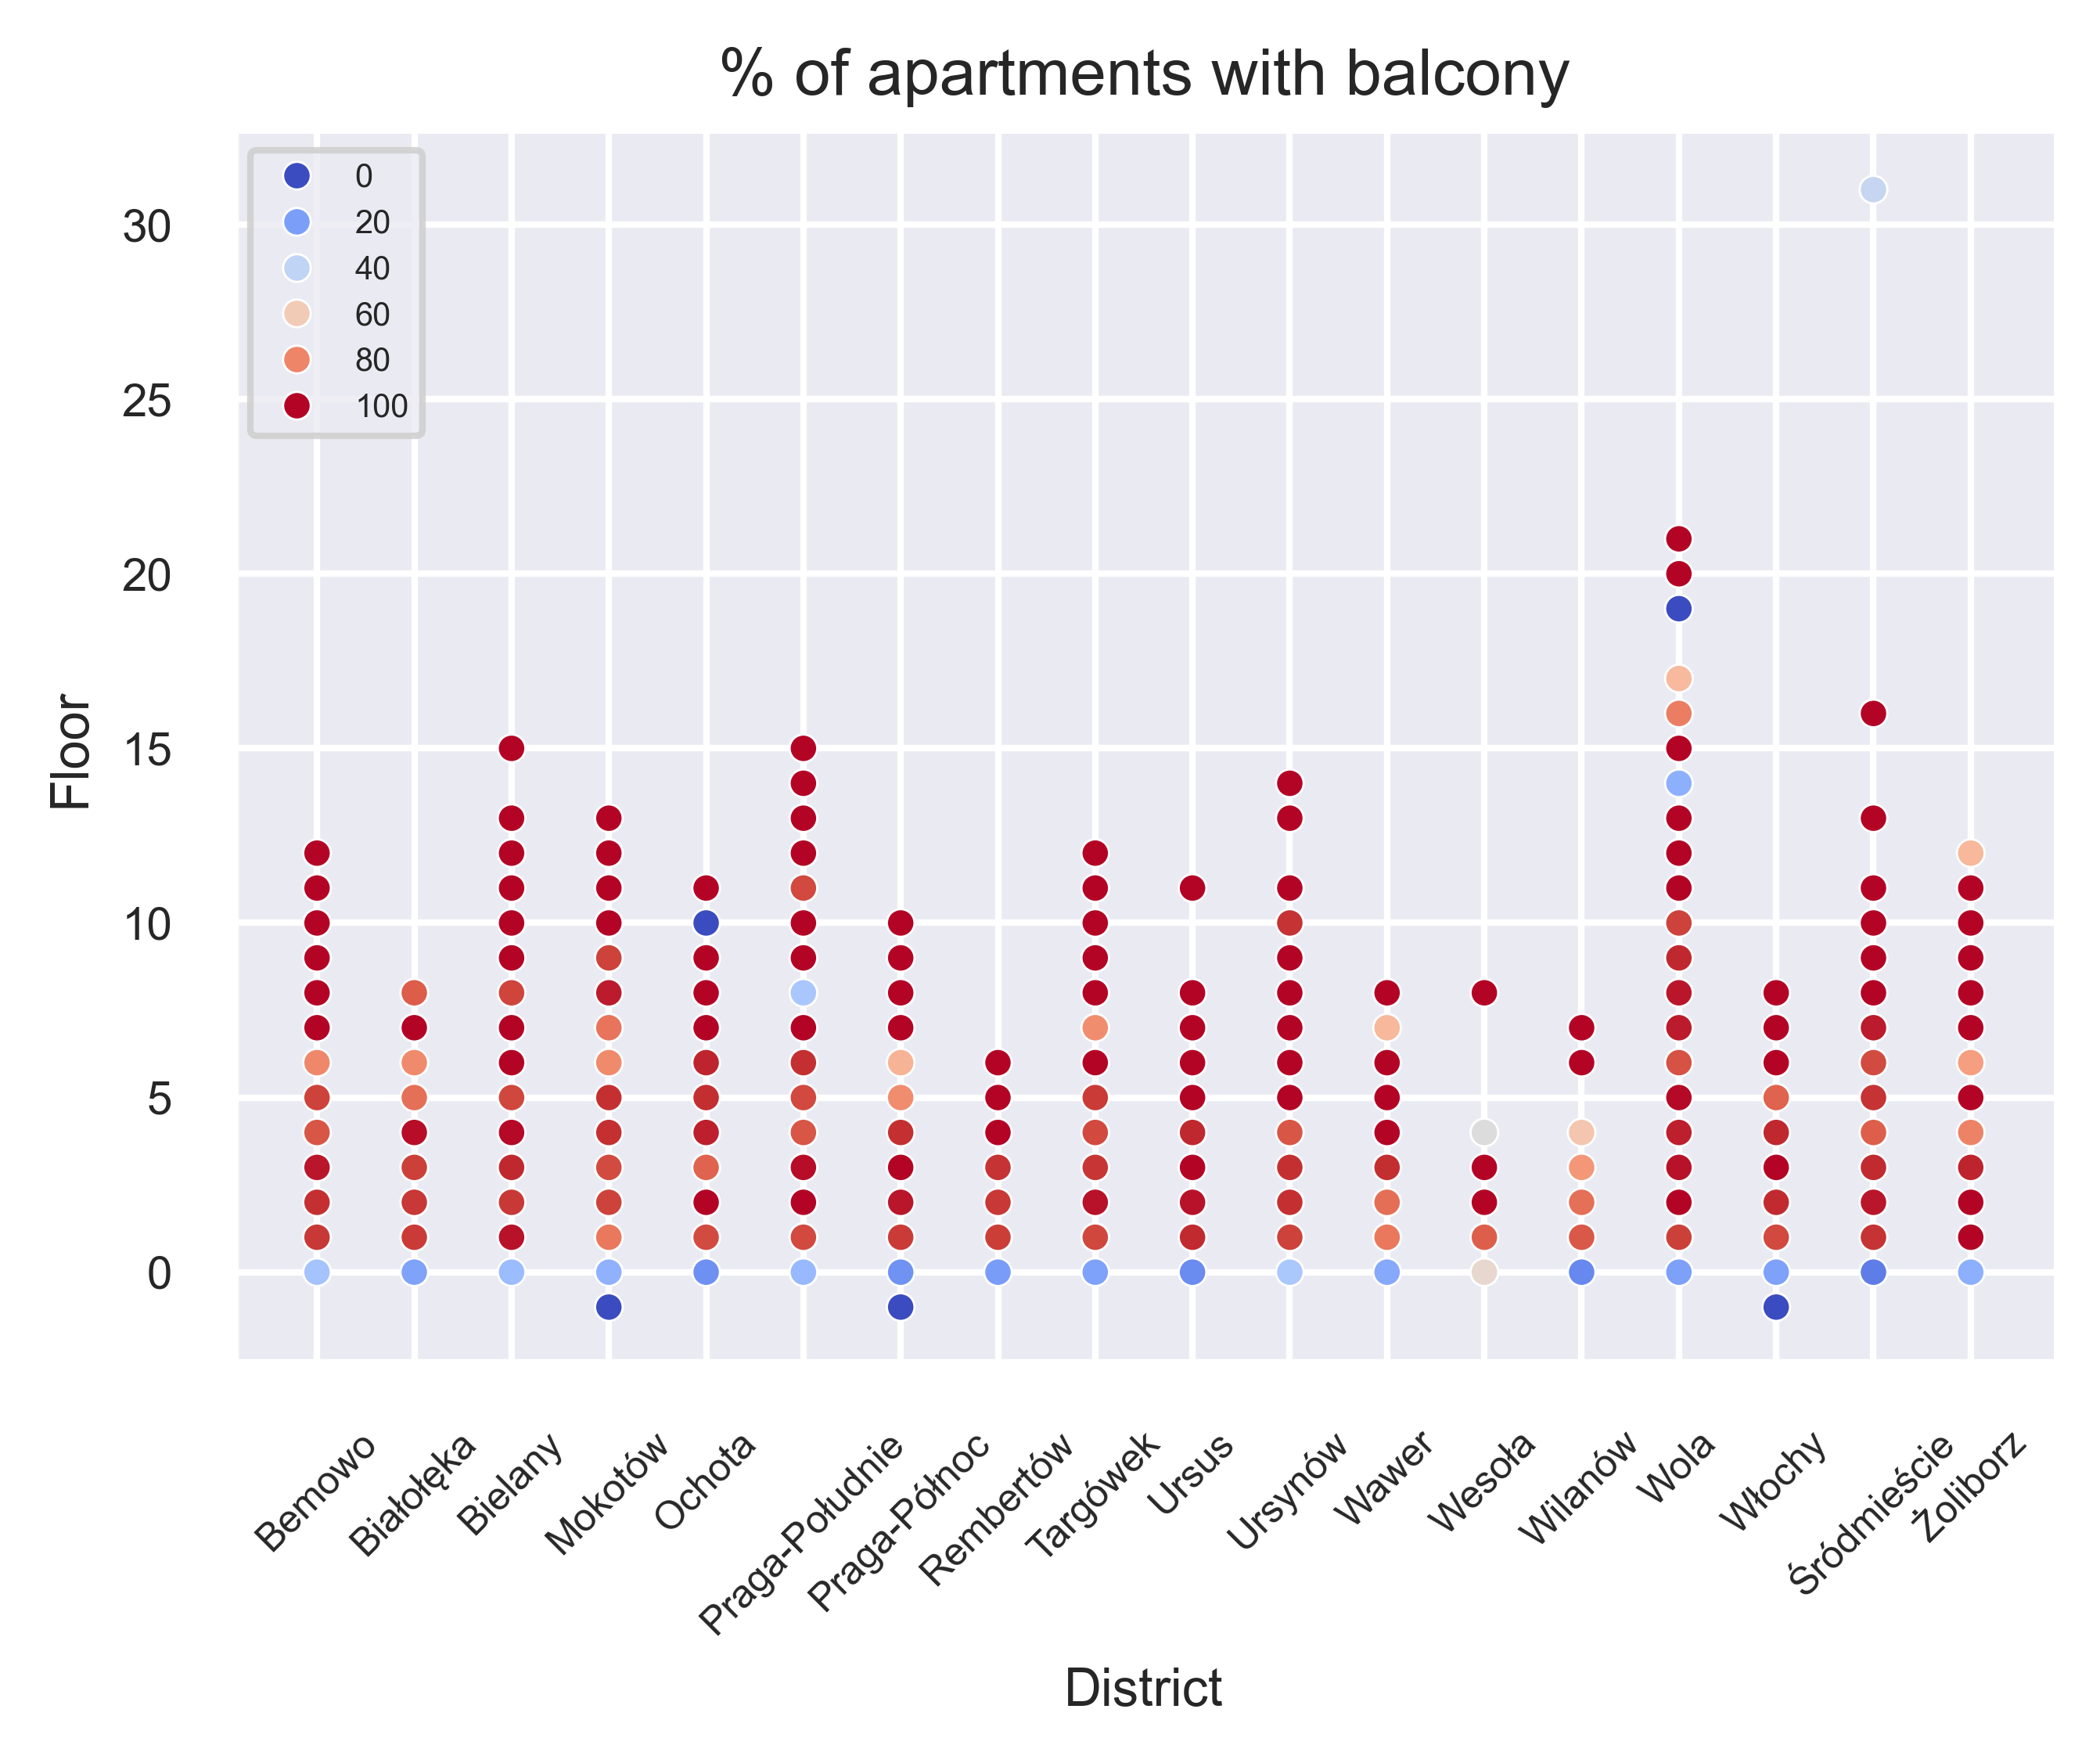

In [43]:
grouped = df.groupby(['district', 'floor'])['balcony']
w_balcony = grouped.sum()
no_balcony = grouped.apply(lambda x: (x == 0.0).sum())
ht = w_balcony/(no_balcony+w_balcony)*100

sns.scatterplot(data=ht.reset_index(), x='district', y='floor', hue='balcony', palette='coolwarm', s=18)
plt.xticks(rotation=45, fontsize=6);
plt.xlabel('District', fontsize=8);
plt.ylabel('Floor', fontsize=8);
plt.title("% of apartments with balcony", fontsize=10);
plt.legend(title='', fontsize=5);


First of all we can see that some of the apartments that are on ``floor=0`` have balconies, we should convert those into terraces. 

In [44]:
condition = (df['floor'] == 0) & (df['balcony'] == 1)
df.loc[condition, 'balcony'] = 0
df.loc[condition, 'terrace'] = 1

Let's repeat the proccess for ``terrace`` and ``garden``.

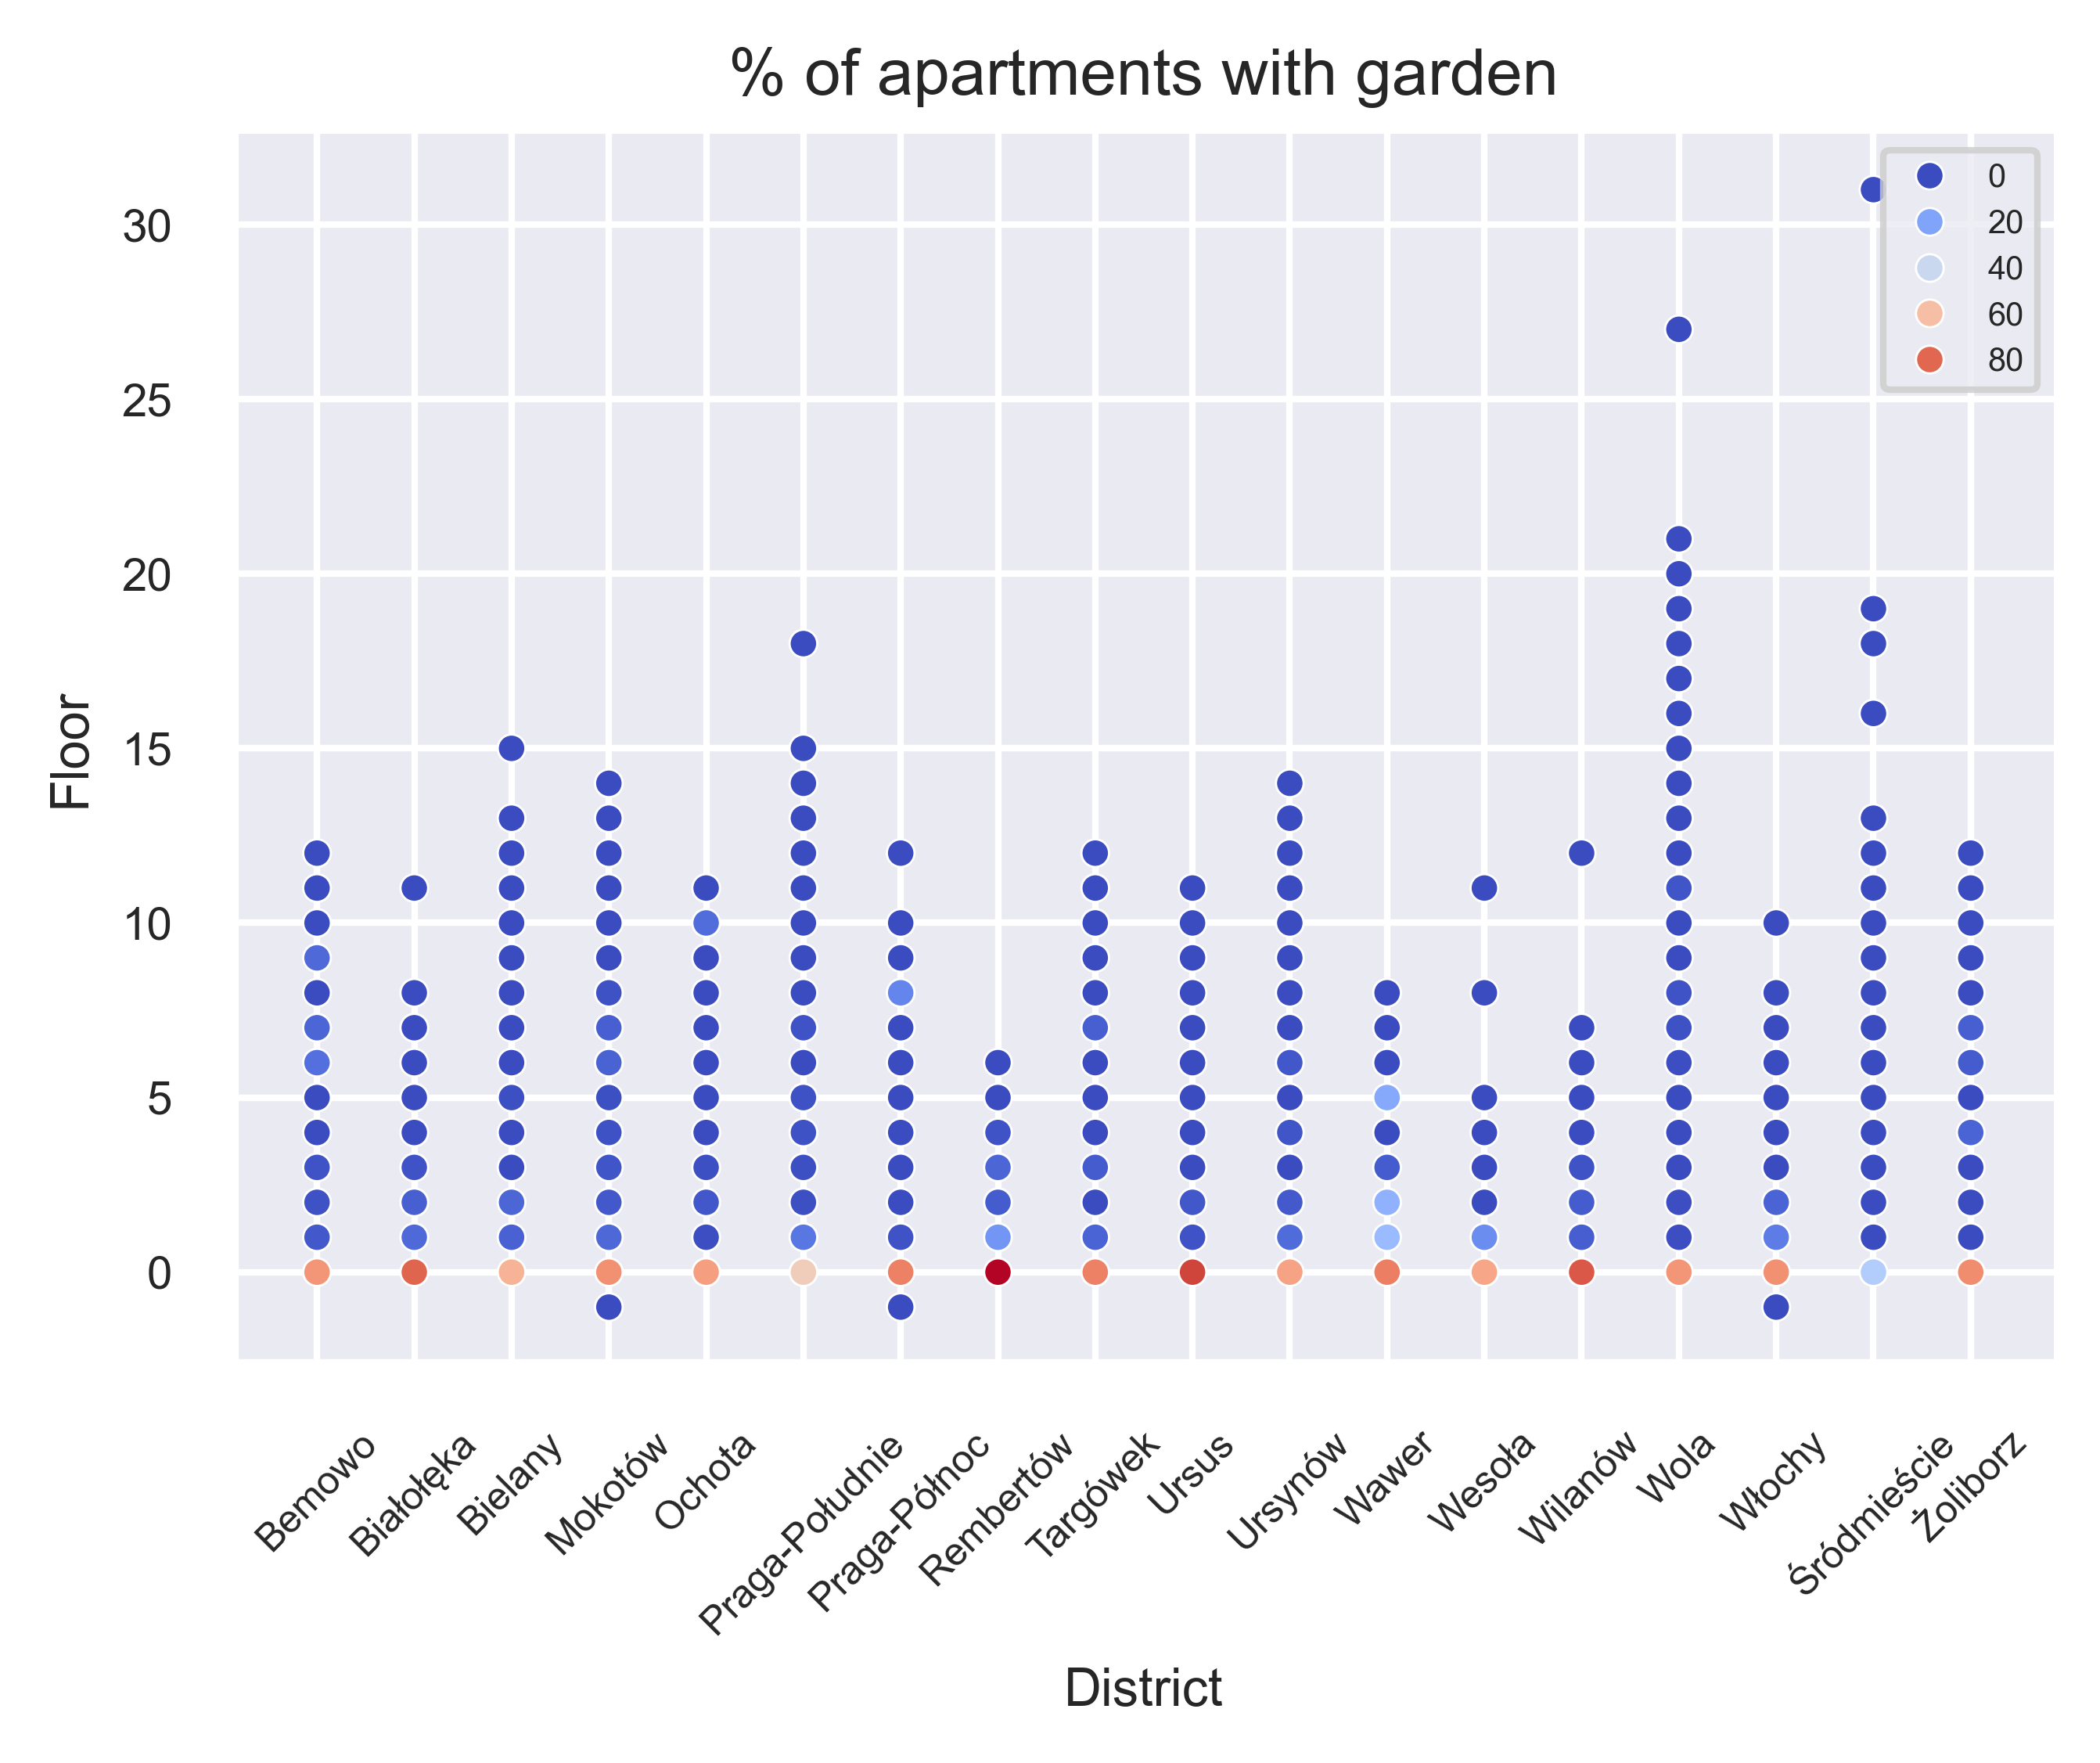

In [45]:
grouped = df.groupby(['district', 'floor'])['garden']
w_balcony = grouped.sum()
no_balcony = grouped.apply(lambda x: (x == 0.0).sum())
ht = w_balcony/(no_balcony+w_balcony)*100

sns.scatterplot(data=ht.reset_index(), x='district', y='floor', hue='garden', palette='coolwarm', s=18)
plt.xticks(rotation=45, fontsize=6);
plt.xlabel('District', fontsize=8);
plt.ylabel('Floor', fontsize=8);
plt.title("% of apartments with garden", fontsize=10);
plt.legend(title='', fontsize=5);


In [46]:
condition = (df['garden']==1) & (df['floor']!=0)
df.loc[condition, 'garden'] = 0
df.loc[condition, 'balcony'] = 1

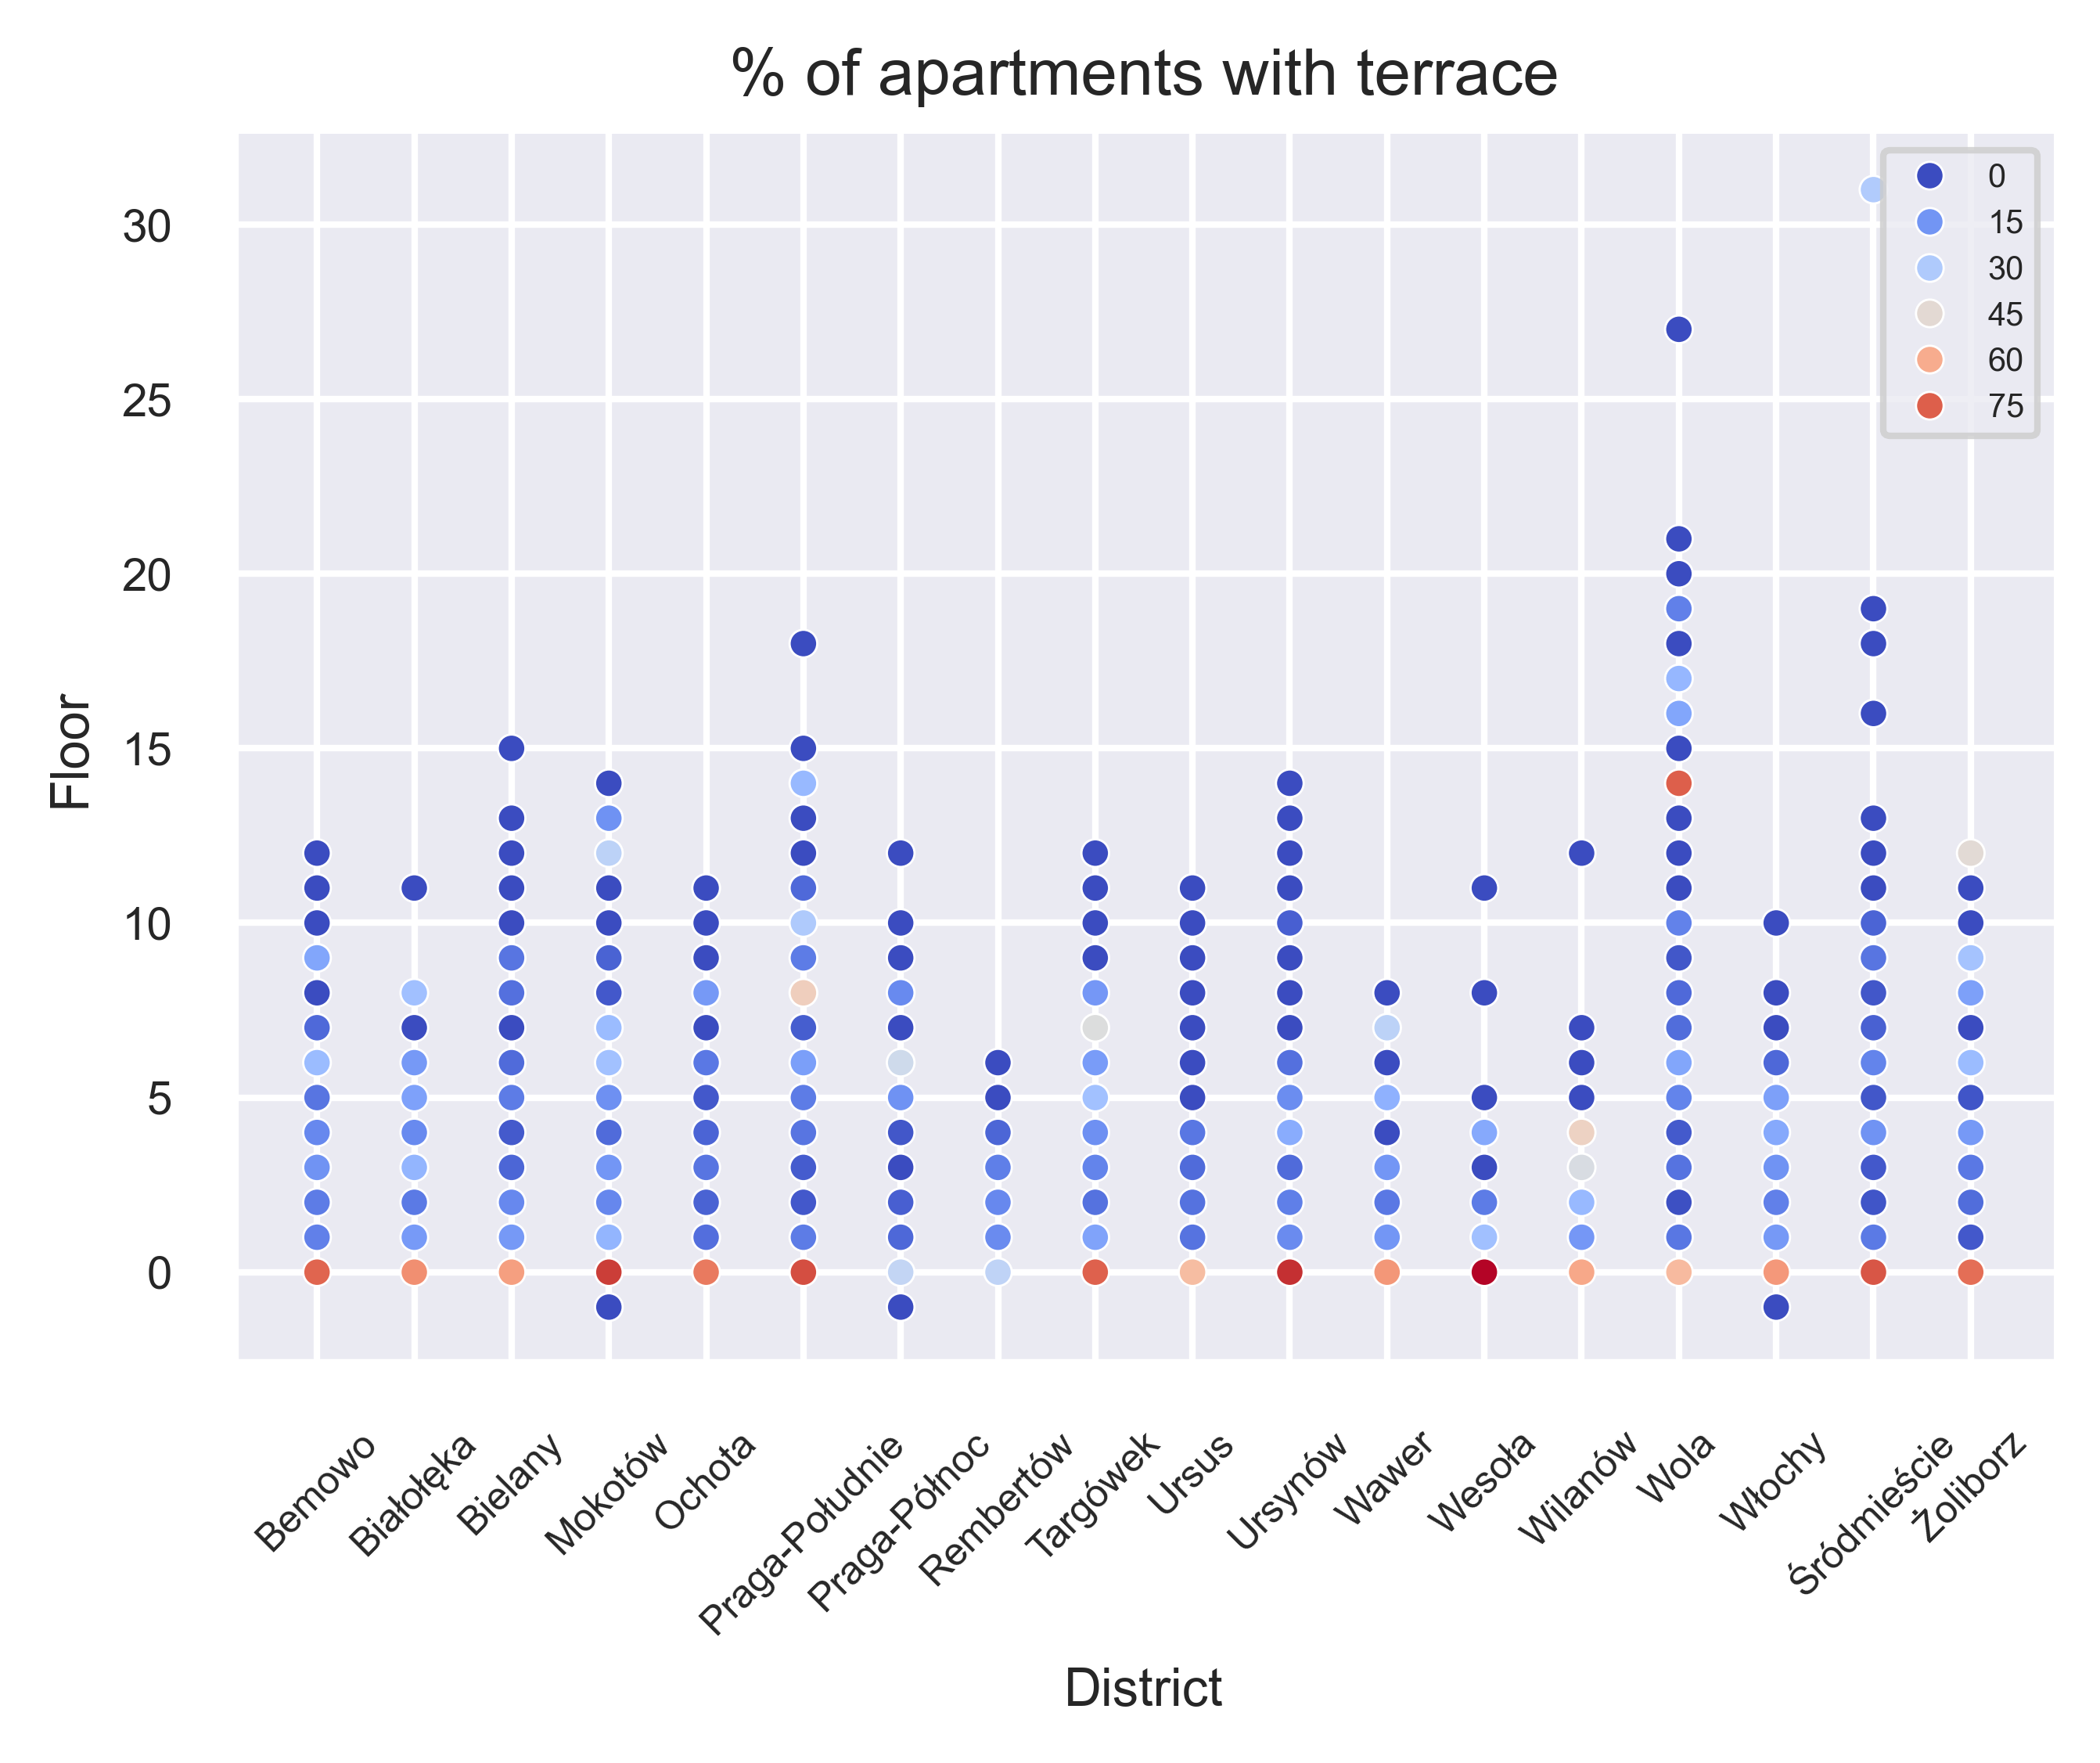

In [47]:
grouped = df.groupby(['district', 'floor'])['terrace']
w_balcony = grouped.sum()
no_balcony = grouped.apply(lambda x: (x == 0.0).sum())
ht = w_balcony/(no_balcony+w_balcony)*100

sns.scatterplot(data=ht.reset_index(), x='district', y='floor', hue='terrace', palette='coolwarm', s=18)
plt.xticks(rotation=45, fontsize=6);
plt.xlabel('District', fontsize=8);
plt.ylabel('Floor', fontsize=8);
plt.title("% of apartments with terrace", fontsize=10);
plt.legend(title='', fontsize=5);


In [48]:
condition = (df['terrace']==1) & (df['floor']!=0)
df.loc[condition, 'terrace'] = 0
df.loc[condition, 'balcony'] = 1

Now the data should make more sense, let's input the missing values. 
I think it'd be reasonable to calculate probability for each ``floor`` and ``district`` of having a balcony, garden or terrace and input the values accordingly.

In [49]:
df.isna().sum()

total_price         0
price_per_sqm       0
area                0
rooms               0
floor             426
rent              133
elevator         1693
built            4864
b_type           5996
link                0
max_floor        1213
balcony          6795
terrace          1331
garden           1331
street           7551
district          299
subdistrict       757
dtype: int64

In [50]:
def calculate_probability(df, feature):
    prob = df.groupby(['district', 'floor'])[feature].mean().reset_index()
    prob.rename(columns = {feature : f'{feature}_prob'}, inplace=True)
    df = df.merge(prob, on=['district', 'floor'], how='left')
    return df

df = calculate_probability(df, 'balcony')
df = calculate_probability(df, 'terrace')
df = calculate_probability(df, 'garden')

def impute_missing_values(row, feature, prob_feature):
    if pd.isna(row[feature]):
        if pd.notna(row['district']) and pd.notna(row['floor']):
            prob = row[prob_feature]
            return 1 if np.random.rand() < prob else 0
    return row[feature]

df['balcony'] = df.apply(impute_missing_values, feature='balcony', prob_feature='balcony_prob', axis=1)
df['terrace'] = df.apply(impute_missing_values, feature='terrace', prob_feature='terrace_prob', axis=1)
df['garden'] = df.apply(impute_missing_values, feature='garden', prob_feature='garden_prob', axis=1)
df.drop(columns=['balcony_prob', 'terrace_prob', 'garden_prob'], inplace=True)

In [51]:
df.isna().sum()

total_price         0
price_per_sqm       0
area                0
rooms               0
floor             426
rent              133
elevator         1693
built            4864
b_type           5996
link                0
max_floor        1213
balcony           276
terrace            19
garden             19
street           7551
district          299
subdistrict       757
dtype: int64

For missing values in ``max_floor`` we will use median in each district+ noise.

In [52]:
median_max_floor = df.groupby('district')['max_floor'].median().reset_index()
median_max_floor.rename(columns={'max_floor': 'median_max_floor'}, inplace=True)
df = df.merge(median_max_floor, on='district', how='left')

def impute_max_floor(row):
    if pd.isna(row['max_floor']):
        median_value = row['median_max_floor']
        if pd.notna(median_value):
            noise = np.random.uniform(-0.15, 0.15)
            imputed_value = median_value * (1 + noise)
            return np.ceil(imputed_value)
    return row['max_floor']

df['max_floor'] = df.apply(impute_max_floor, axis=1)
df.drop(columns=['median_max_floor'], inplace=True)

In [53]:
df.isna().sum()

total_price         0
price_per_sqm       0
area                0
rooms               0
floor             426
rent              133
elevator         1693
built            4864
b_type           5996
link                0
max_floor           1
balcony           276
terrace            19
garden             19
street           7551
district          299
subdistrict       757
dtype: int64

Now let's take care of missing values in ``built`` and ``b_type``. 

In [54]:
print(df['b_type'].unique())
print((df['b_type']=='dom wolnostojący').sum())
df = df[df['b_type']!='dom wolnostojący']

[nan 'apartamentowiec' 'blok' 'kamienica' 'szeregowiec' 'dom wolnostojący'
 'plomba' 'loft']
324


Since we want to focus on apartments, we had to drop all rows that are houses. Building type is connected to the year it was built. Let's visualize this relation in order to input missing values in a smart way. 

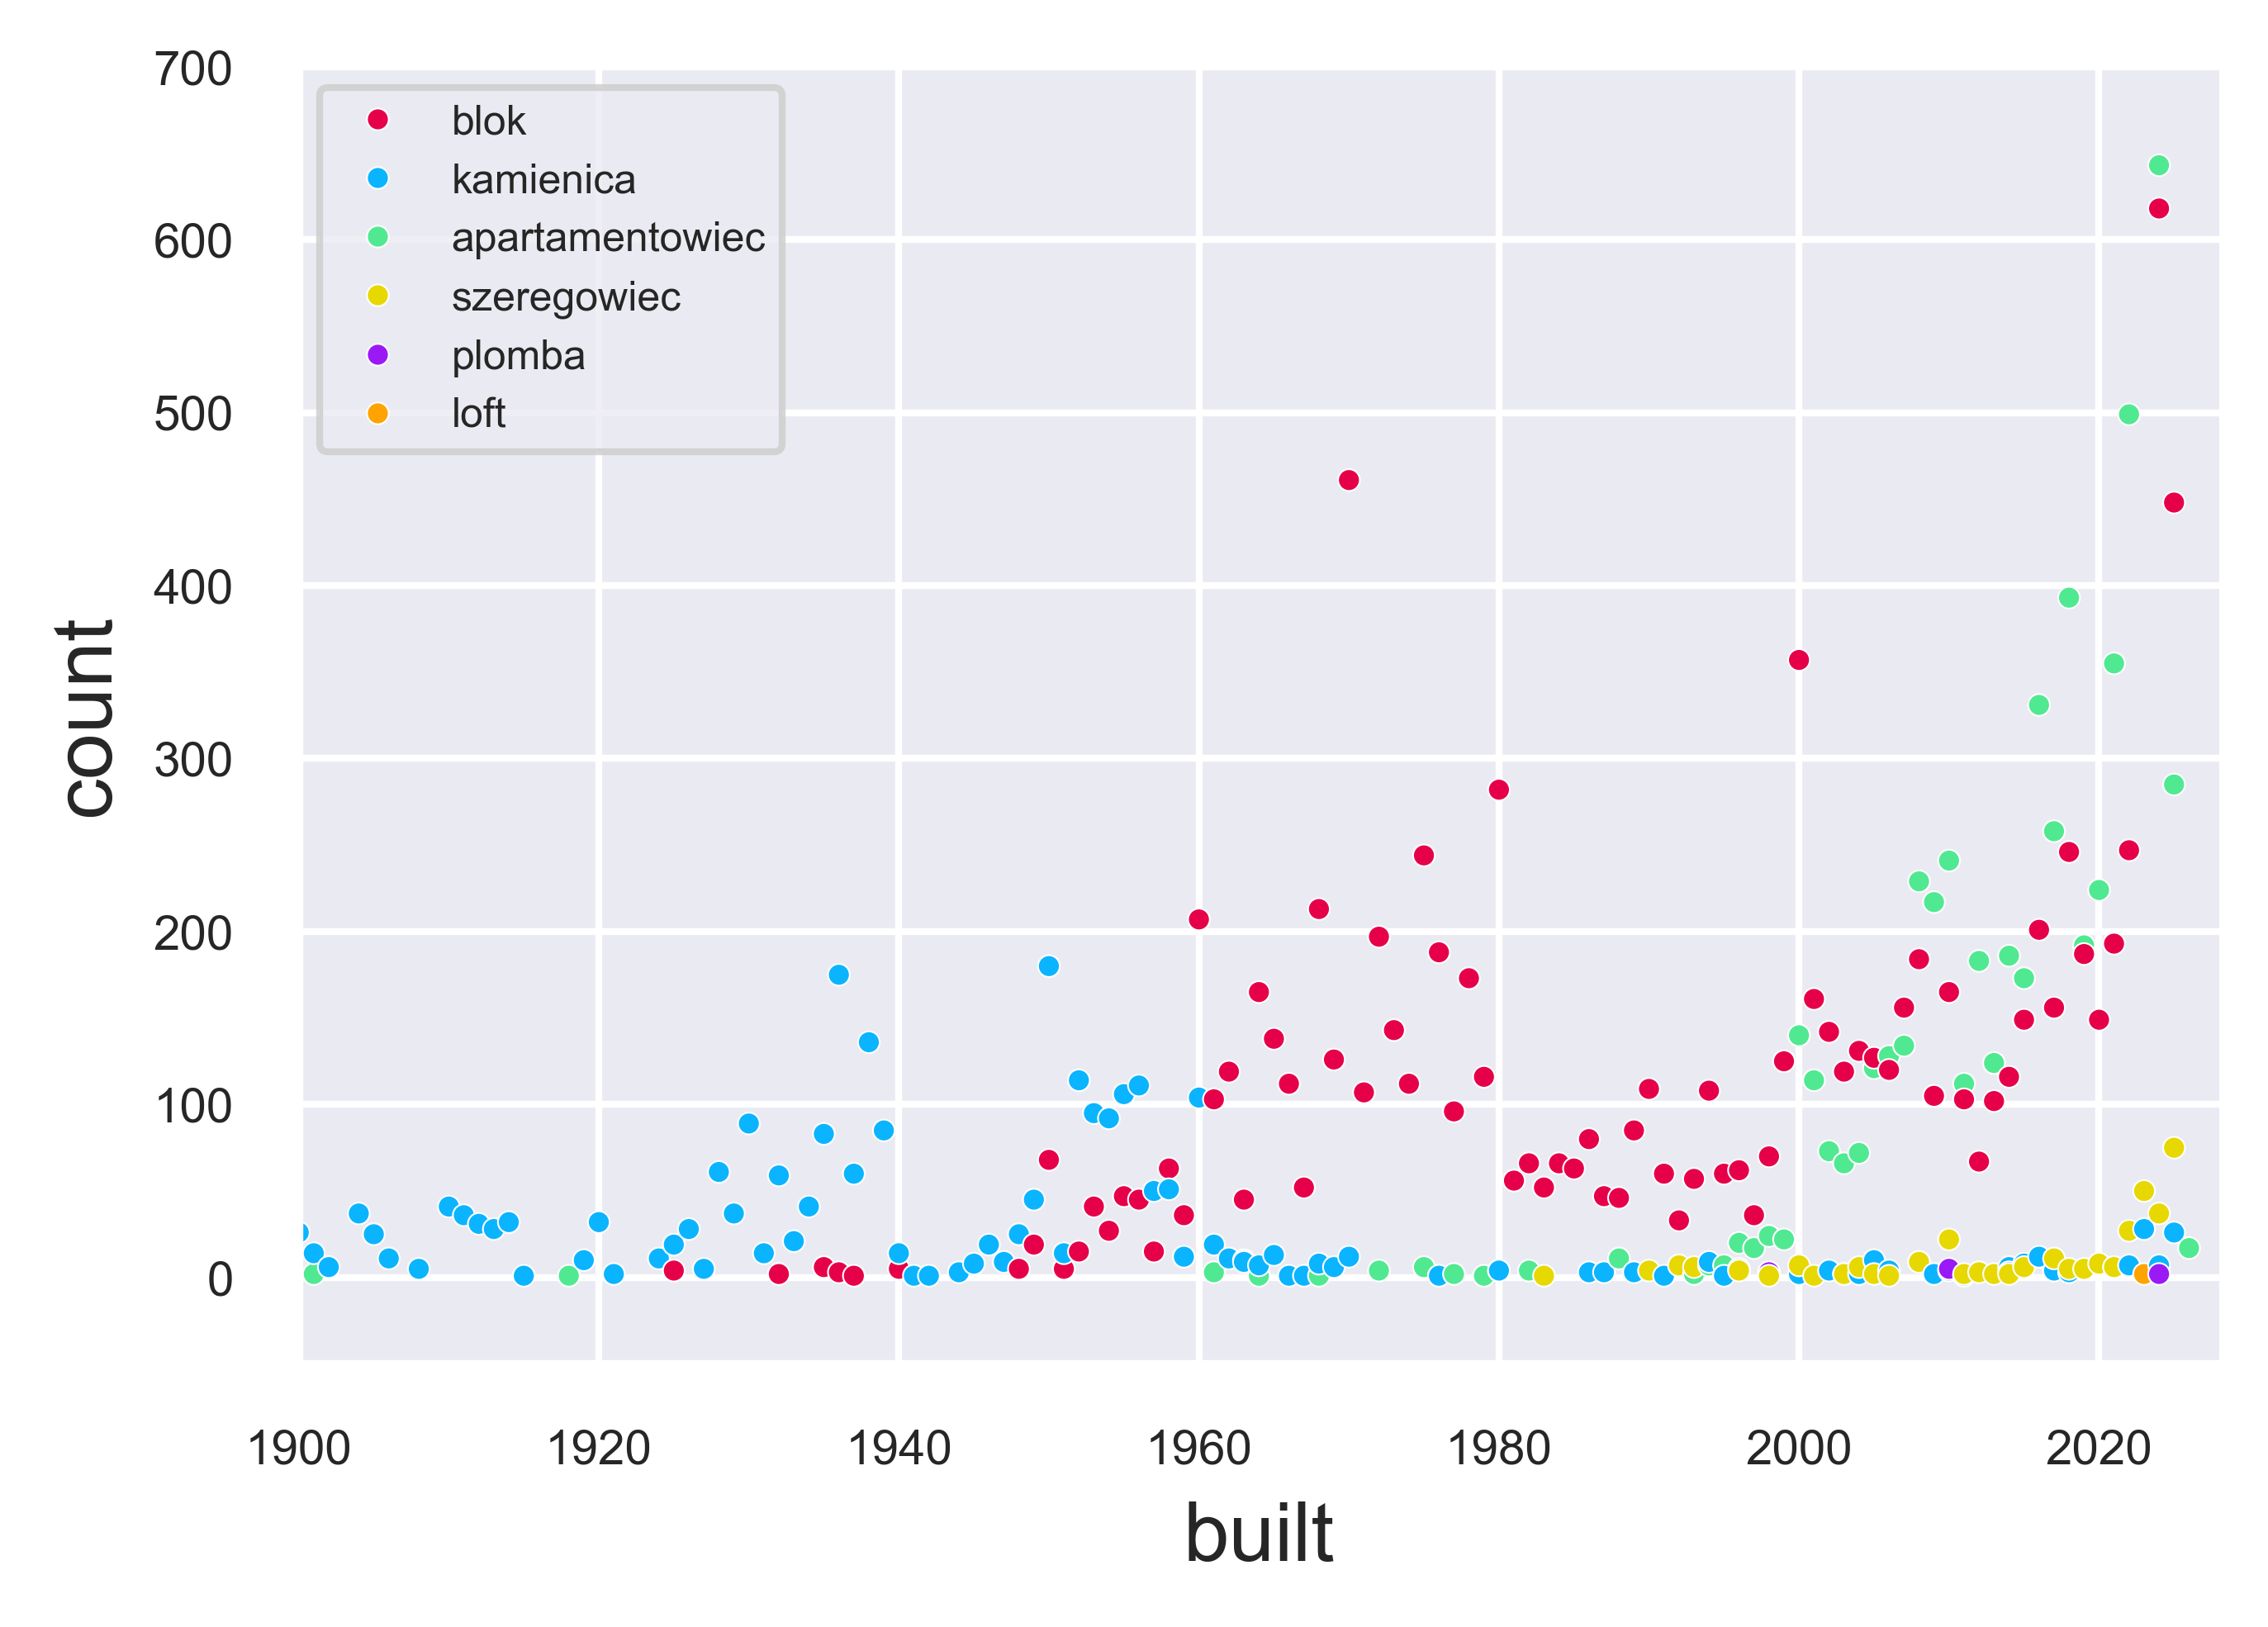

In [55]:
agg_data = df.groupby(['built', 'b_type']).size().reset_index(name='count')

sns.scatterplot(data=agg_data, x='built', y='count', hue='b_type', s=10)
plt.xlim(1900, 2028);
plt.ylim(-50, 700);
plt.legend(fontsize=6);

##### Now we will input missing values basing on this plot, we will use the following rules:
* If the building was built in year <= 1945 then it will be *kamienica*
* If it was built in 1945 < year <= 1960 then there'll be 65% chance it's a *kamienica* and 35% it's *blok*
* If 1960 < year <= 2000 it's *block*
* If 2000 < year <= 2020 there'll be 50% chance it's *blok* and 50% chance it's *apartamentowiec*
* If 2020 < year there'll be 45% chance it's *blok*, 45% chance it's *apartamentowiec* and 10% chance it's *szergowiec*

In [56]:
condition = (df['built']<=1945) & (df['b_type'].isna())
df.loc[condition, 'b_type'] = 'kamienica'

condition = (df['built'] > 1945) & (df['built'] <= 1960) & (df['b_type'].isna())
probabilities = [0.65, 0.35]
b_types = ['kamienica', 'blok']
df.loc[condition, 'b_type'] = np.random.choice(b_types, size=condition.sum(), p=probabilities)

condition = (df['built'] > 1960) & (df['built'] <= 2000) & (df['b_type'].isna())
df.loc[condition, 'b_type'] = 'blok'

condition = (df['built'] > 2000) & (df['built'] <= 2020) & (df['b_type'].isna())
probabilities = [0.50, 0.50]
b_types = ['apartamentowiec', 'blok']
df.loc[condition, 'b_type'] = np.random.choice(b_types, size=condition.sum(), p=probabilities)

condition = (df['built']>2020) & (df['b_type'].isna())
b_types = ['apartamentowiec', 'blok', 'szeregowiec']
probabilities = [0.45, 0.45, 0.1]
df.loc[condition, 'b_type'] = np.random.choice(b_types, size=condition.sum(), p=probabilities)

Now let's check if there's any connection between ``b_type`` and ``district``.

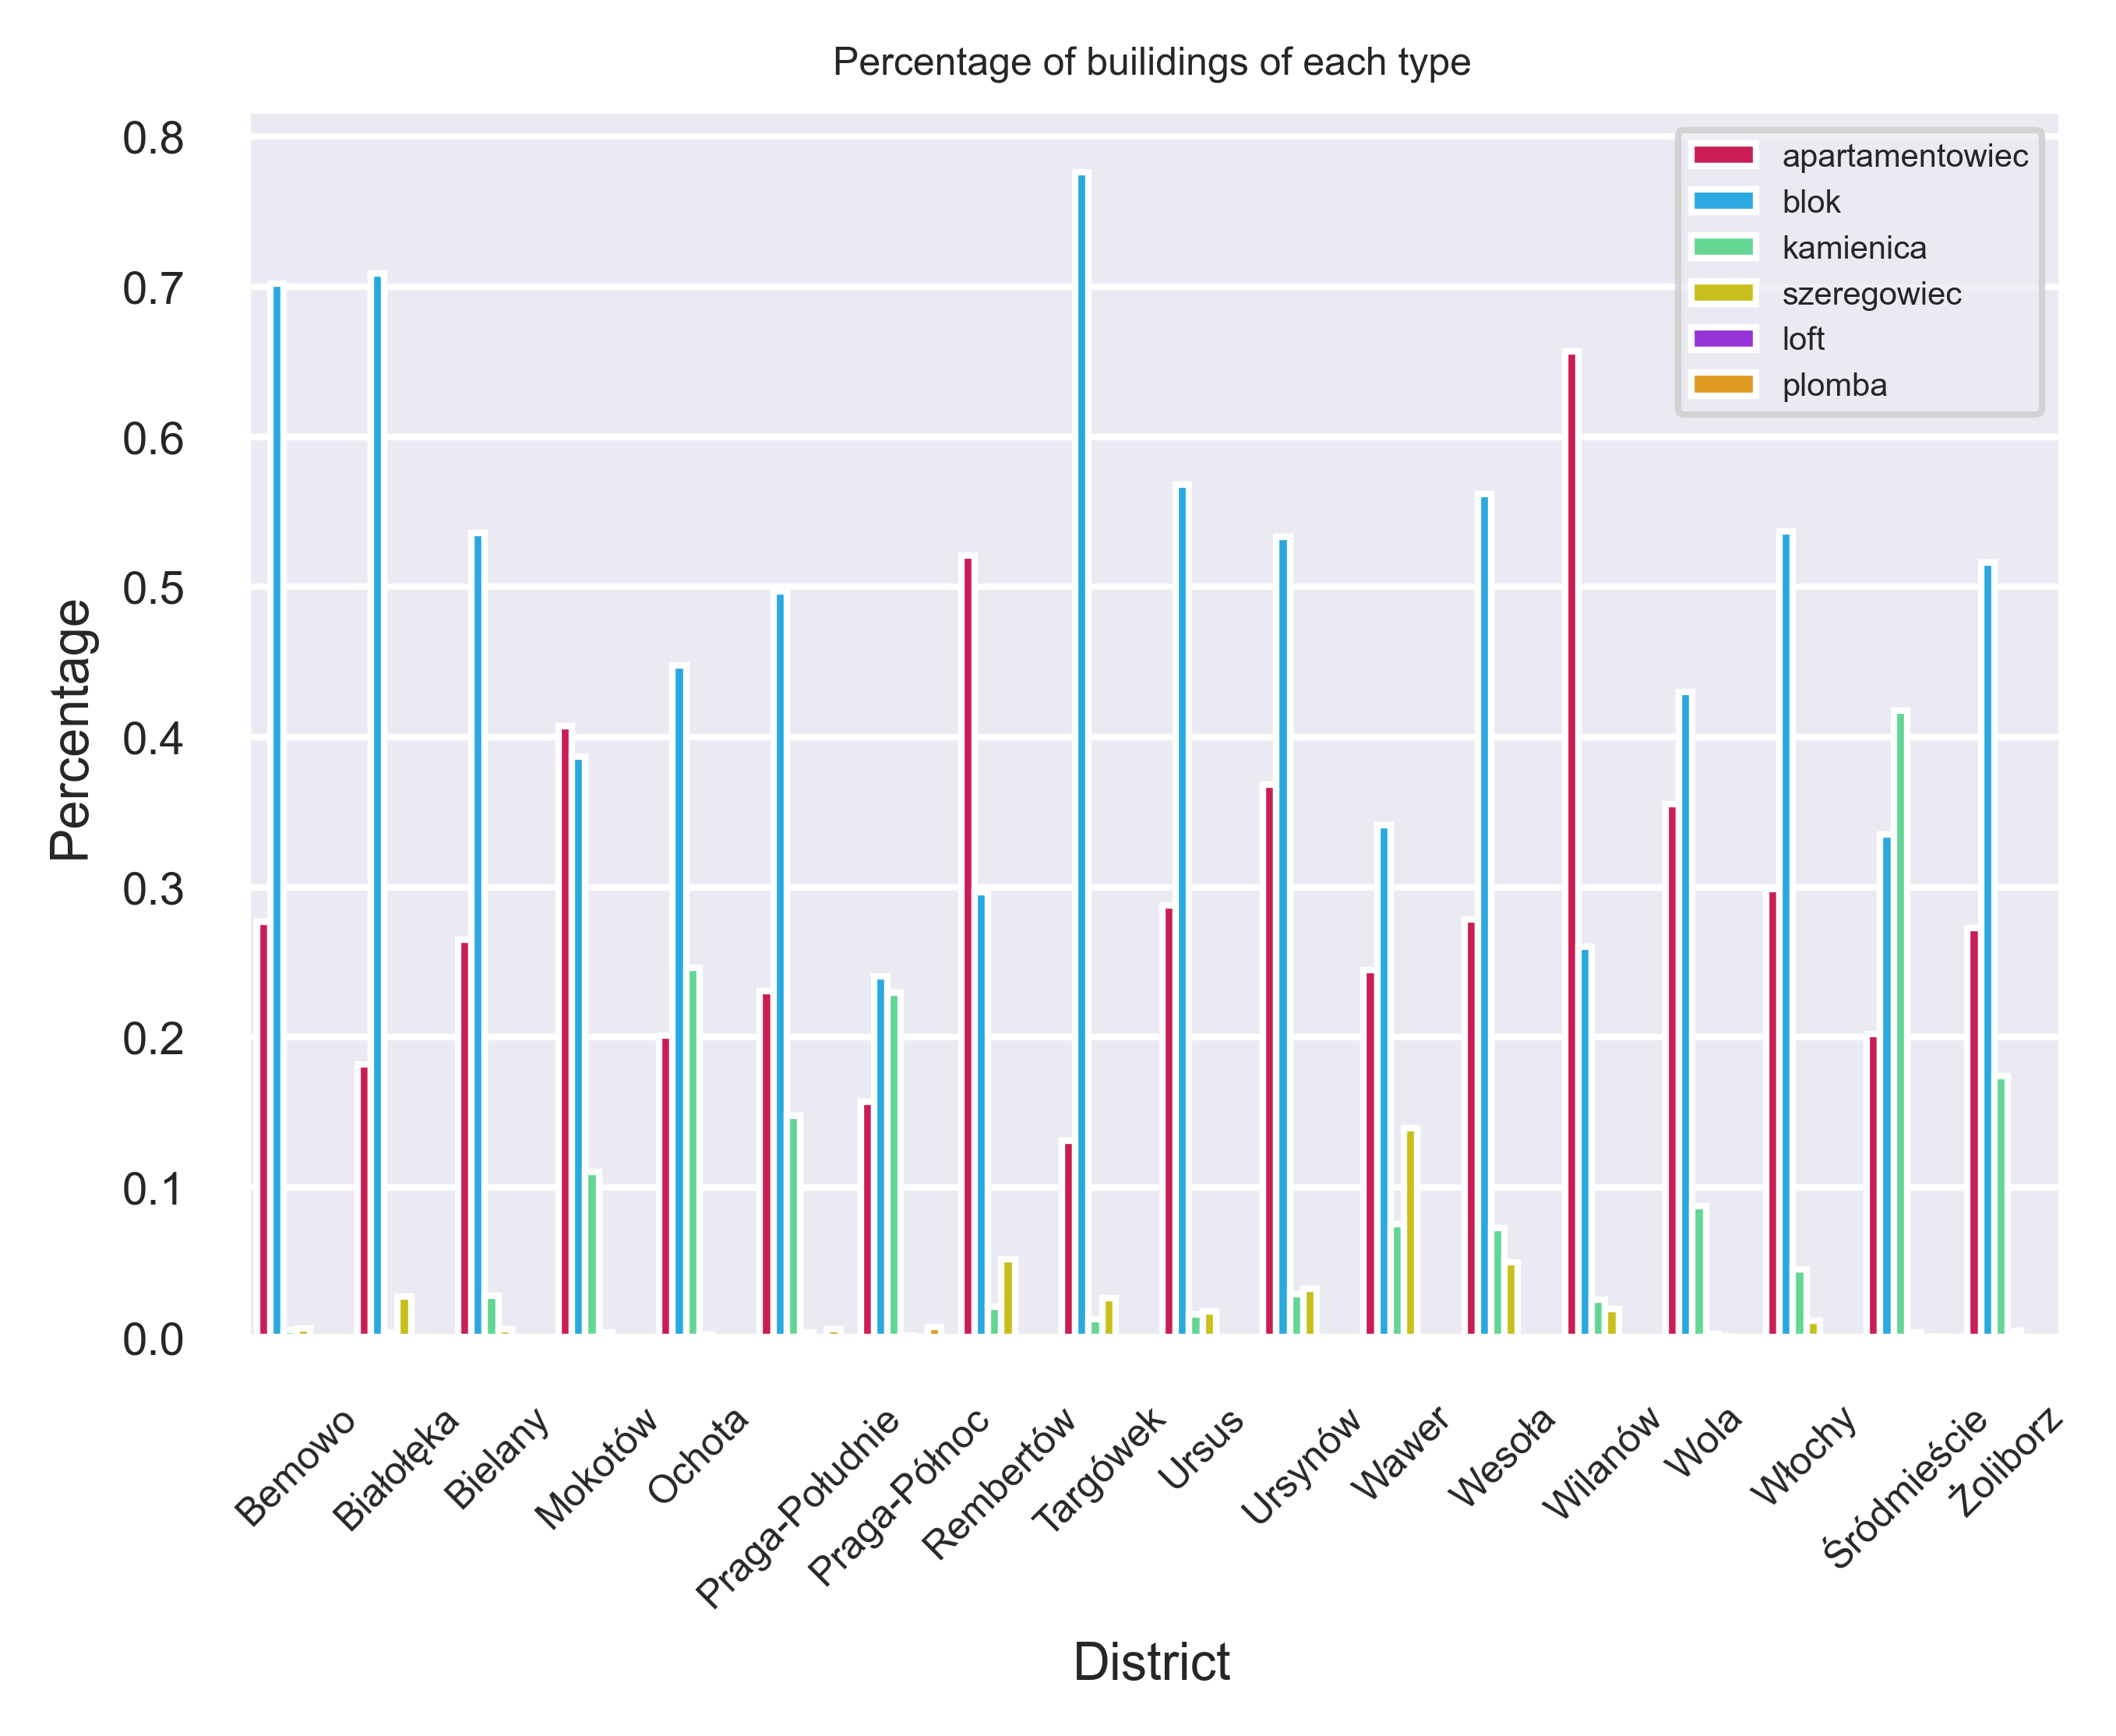

In [57]:
type_cnt = df.groupby(['district', 'b_type']).size().reset_index(name='count')
total_cnt = df.groupby('district').size().reset_index(name='total')
merged_df = pd.merge(type_cnt, total_cnt, on='district')
merged_df['percentage'] = merged_df['count'] / merged_df['total']

sns.barplot(data=merged_df, x='district', y='percentage', hue='b_type');
plt.xlabel('District', fontsize=8);
plt.ylabel('Percentage', fontsize=8);
plt.legend(fontsize=5);
plt.xticks(rotation=45, fontsize=6);
plt.title('Percentage of builidings of each type', fontsize=6);

Now we will input missing values using mean values for each district, because we can see that distribution of b_types can be very different between two districts. 

In [58]:
percentage_mapping = merged_df.pivot(index='district', columns='b_type', values='percentage').fillna(0)
percentage_mapping = percentage_mapping.div(percentage_mapping.sum(axis=1), axis=0).fillna(0)

def impute_b_type(row):
    if pd.isna(row['b_type']):
        district = row['district']
        if pd.notna(district) and district in percentage_mapping.index:
            probabilities = percentage_mapping.loc[district]
            b_type = np.random.choice(percentage_mapping.columns, p=probabilities)
            return b_type
    return row['b_type']

df['b_type'] = df.apply(impute_b_type, axis=1)

There's very few missing values left, so I will impute them 'randomly'.

In [59]:
b_types = ['kamienica', 'blok', 'apartamentowiec', 'szeregowiec']
probabilities = [0.25, 0.4, 0.25, 0.1]

mask = df['b_type'].isna()
df.loc[mask, 'b_type'] = np.random.choice(b_types, size=mask.sum(), p=probabilities)

In [60]:
distribution = df.dropna(subset=['built']).groupby(['b_type', 'built']).size().unstack(fill_value=0)
distribution = distribution.cumsum(axis=1)

def impute_built(row):
    if pd.isna(row['built']) and pd.notna(row['b_type']):
        b_type = row['b_type']
        if b_type in distribution.index:
            dist = distribution.loc[b_type]
            total = dist.iloc[-1]
            if total > 0:
                r = np.random.rand() * total
                year = dist[dist >= r].index[0]
                return year
    return row['built']

df['built'] = df.apply(impute_built, axis=1)

In [61]:
print(df['b_type'].value_counts())
df = df[(df['b_type']!='loft') & (df['b_type']!='plomba')]

b_type
blok               15547
apartamentowiec     9491
kamienica           3536
szeregowiec          481
plomba                29
loft                   4
Name: count, dtype: int64


Since there's very little rows where ``b_type`` is *loft* or *plomba* we dropped these rows, to not confuse the model in the future.

In [62]:
df.isna().sum()

total_price         0
price_per_sqm       0
area                0
rooms               0
floor             417
rent              121
elevator         1689
built               0
b_type              0
link                0
max_floor           1
balcony           272
terrace            11
garden             11
street           7456
district          287
subdistrict       744
dtype: int64

Now let's imput the missing values in ``elevator``. There must be a relation between ``elevator`` and ``max_floor``. Let's visualise it.

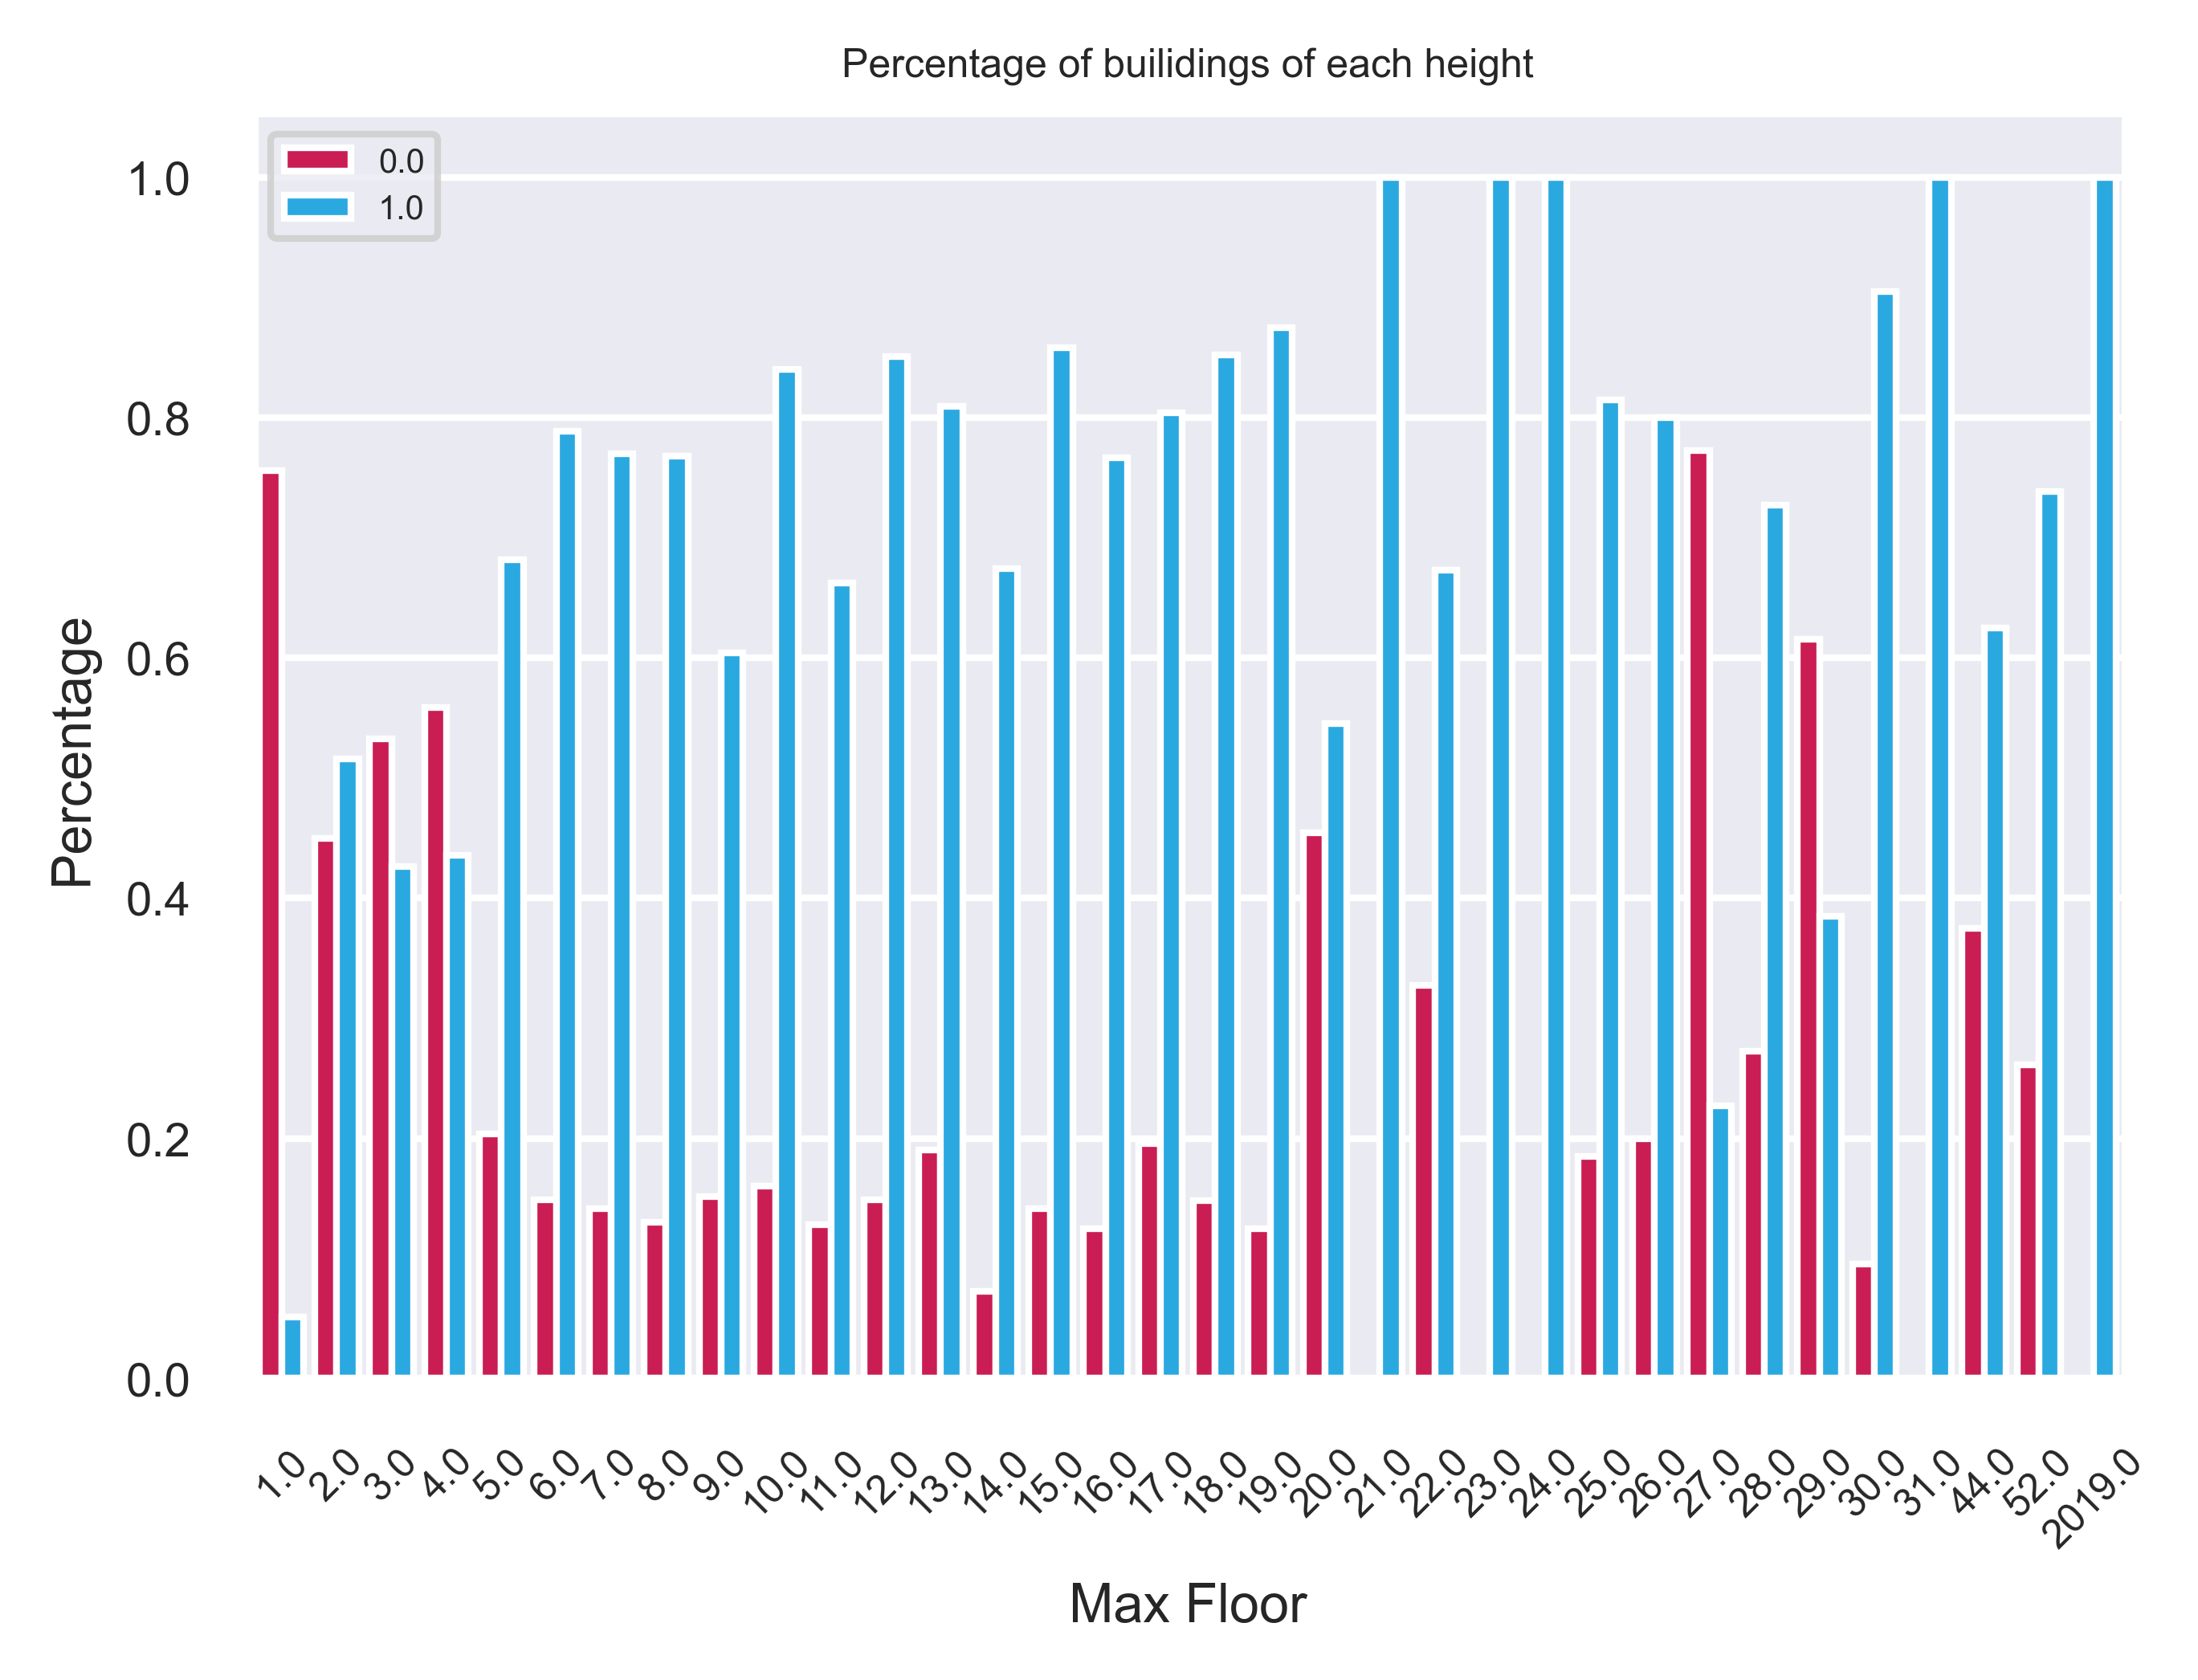

In [63]:
# percentage w ele vs w/o ele
type_cnt = df.groupby(['max_floor', 'elevator']).size().reset_index(name='count')
total_cnt = df.groupby('max_floor').size().reset_index(name='total')
merged_df = pd.merge(type_cnt, total_cnt, on='max_floor')
merged_df['percentage'] = merged_df['count'] / merged_df['total']

sns.barplot(data=merged_df, x='max_floor', y='percentage', hue='elevator');
plt.xlabel('Max Floor', fontsize=8);
plt.ylabel('Percentage', fontsize=8);
plt.legend(fontsize=5);
plt.xticks(rotation=45, fontsize=6);
plt.title('Percentage of builidings of each height', fontsize=6);

I think that the data I got is inaccurate, in my opinion all builidngs that have 15+ floors must have elevators. I will update the data. If building has <15 floors, there will be 85% chance it has an elevator. If it's kamienica or szergowiec, it won't have elevator. For now I will ignore the fact that some builings have max_floor = 1.

In [64]:
condition = df['max_floor']>=15
df.loc[condition, 'elevator'] = 1

condition = df['max_floor'] < 15
df.loc[condition, 'elevator'] = np.random.choice([1, 0], size=condition.sum(), p=[0.85, 0.15])

condition = (df['b_type']=='kamienica') | (df['b_type']=='szeregowiec')
df.loc[condition, 'elevator'] = 0

It's difficult to imput missing values in ``floor`` in a reasonable way, so I will just use random number between 1 and ``max_floor``. 

In [65]:
def fill_missing_floor(row):
    if pd.isna(row['floor']):
        max_f = row['max_floor']
        return np.random.randint(1, max_f + 1)
    return row['floor']

df['floor'] = df.apply(fill_missing_floor, axis=1)

Now we have a small number of missing values in columns: ``rent``, ``max_floor``, ``balcony``, ``terrace`` and ``garden``. I will use techniques that are more random than previously. 

In [66]:
rent_per_sqm = df['rent'] / df['area']
rent_per_sqm = np.mean(rent_per_sqm)

def set_rent(row):
    if pd.isna(row['rent']):
        return row['area']*rent_per_sqm
    return row['rent']

df['rent'] = df.apply(set_rent, axis=1)

In [67]:
condition = df['max_floor'].isna()
df.loc[condition, 'max_floor'] = 7

In [68]:
def calculate_probability(df, feature):
    prob = df.groupby(['floor'])[feature].mean().reset_index()
    prob.rename(columns = {feature : f'{feature}_prob'}, inplace=True)
    df = df.merge(prob, on=['floor'], how='left')
    return df

df = calculate_probability(df, 'balcony')
df = calculate_probability(df, 'terrace')
df = calculate_probability(df, 'garden')

def impute_missing_values(row, feature, prob_feature):
    if pd.isna(row[feature]):
        if pd.notna(row['floor']):
            prob = row[prob_feature]
            return 1 if np.random.rand() < prob else 0
    return row[feature]

df['balcony'] = df.apply(impute_missing_values, feature='balcony', prob_feature='balcony_prob', axis=1)
df['terrace'] = df.apply(impute_missing_values, feature='terrace', prob_feature='terrace_prob', axis=1)
df['garden'] = df.apply(impute_missing_values, feature='garden', prob_feature='garden_prob', axis=1)
df.drop(columns=['balcony_prob', 'terrace_prob', 'garden_prob'], inplace=True)

Now let's focus on missing values in columns: ``street``, ``subdistrict`` and ``district``. Ultimately, I want add a new column containing distance to the center. In order to do that, I need to find the coordinates of each location and calculate the distance. Then I will imput missing values into this column. It won't be possible to imput missing values to ``street`` and ``subdistrict``, but I'd like to have all values in ``district`` so model can use them. 

In [69]:
df[(df['street'].notna()) & (df['district'].isna())]['street'].value_counts()

street
Warszawska                                    31
Wieluńska                                     17
Trasa Bohaterów Bitwy Warszawskiej 1920 r.    16
Józefa Piłsudskiego                            6
Wschodnia                                      4
Słoneczna                                      4
Szkolna                                        4
Główna                                         3
Centralna                                      1
Józefa Piłsudskiego 11                         1
Name: count, dtype: int64

These values I will add manually and drop some of them due to being located outside of Warsaw.

In [70]:
df = df[~df['street'].isin([
    'Warszawska',
    'Trasa Bohaterów Bitwy Warszawskiej 1920 r.',
    'Józefa Piłsudskiego',
    'Józefa Piłsudskiego 11'
])]

df.loc[df['street'] == 'Wieluńska', 'subdistrict'] = 'Moczydło'
df.loc[df['street'] == 'Wieluńska', 'district'] = 'Wola'

df.loc[df['street'] == 'Wschodnia', 'subdistrict'] = 'Groszowka'
df.loc[df['street'] == 'Wschodnia', 'district'] = 'Wesoła'

df.loc[df['street'] == 'Słoneczna', 'subdistrict'] = 'Stary Mokotów'
df.loc[df['street'] == 'Słoneczna', 'district'] = 'Mokotów'

df.loc[df['street'] == 'Szkolna', 'subdistrict'] = 'Centrum'
df.loc[df['street'] == 'Szkolna', 'district'] = 'Śródmieście'

df.loc[df['street'] == 'Główna', 'subdistrict'] = 'Nowodwory'
df.loc[df['street'] == 'Główna', 'district'] = 'Białołęka'

df.loc[df['street'] == 'Centralna', 'subdistrict'] = 'Opacz Wielka'
df.loc[df['street'] == 'Centralna', 'district'] = 'Włochy'


In [71]:
df[(df['street'].notna()) & (df['subdistrict'].isna())]['street'].value_counts()

street
Powstańców Śląskich            74
Szeligowska                    66
Górczewska                     38
Kazimierza Wyki                13
Drogomilska                    10
Siemiatycka                     8
Generała Waleriana Czumy        8
Wacława Borowego                7
Kruszyńska 40A                  7
Strzelców                       6
Lajosa Kossutha                 5
Rozłogi                         5
Eugeniusza Szwankowskiego       4
Karabeli                        4
Bracławska 4                    3
Stanisława Szobera 6            3
Zenona Klemensiewicza           3
Sternicza                       3
Muszlowa                        3
Świetlików                      2
Okrętowa                        2
Lazurowa 18                     2
Jana Olbrachta 122              2
Drogomilska 25                  2
Aleksandra Świętochowskiego     2
Józefa Chłopickiego             2
Stanisława Konarskiego          2
Lazurowa 4                      1
Cokołowa                        1
Name: c

I will also fill some of these values manually. The rest will be dropped.

In [72]:
subdistricts = ['Jelonki Południowe', 'Jelonki Północne', 'Lotnisko Bemowo', 'Fort Bema']
condition = df['street'] == 'Powstańców Śląskich'
df.loc[condition, 'district'] = 'Bemowo'
df.loc[condition, 'subdistrict'] = np.random.choice(subdistricts, size=condition.sum())

df.loc[df['street'] == 'Szeligowska', 'district'] = 'Bemowo'
df.loc[df['street'] == 'Szeligowska', 'subdistrict'] = 'Chrzanów'

df.loc[df['street'] == 'Górczewska', 'district'] = 'Wola'
df.loc[df['street'] == 'Górczewska', 'subdistrict'] = 'Ulrychów'

df.loc[df['street'] == 'Kazimierza Wyki', 'district'] = 'Bemowo'
df.loc[df['street'] == 'Kazimierza Wyki', 'subdistrict'] = 'Jelonki Północne'

df.loc[df['street'] == 'Drogomilska', 'district'] = 'Bemowo'
df.loc[df['street'] == 'Drogomilska', 'subdistrict'] = 'Jelonki Północne'

df.loc[df['street'] == 'Siemiatycka', 'district'] = 'Bemowo'
df.loc[df['street'] == 'Siemiatycka', 'subdistrict'] = 'Jelonki Południowe'

df.loc[df['street'] == 'Waleriana Czumy', 'district'] = 'Bemowo'
df.loc[df['street'] == 'Waleriana Czumy', 'subdistrict'] = 'Jelonki Północne'

streets_to_drop = [
    'Wacława Borowego', 'Kruszyńska 40A', 'Strzelców', 'Lajosa Kossutha', 'Rozłogi',
    'Eugeniusza Szwankowskiego', 'Karabeli', 'Bracławska 4', 'Stanisława Szobera 6',
    'Zenona Klemensiewicza', 'Sternicza', 'Muszlowa', 'Świetlików', 'Okrętowa',
    'Lazurowa 18', 'Jana Olbrachta 122', 'Drogomilska 25', 'Aleksandra Świętochowskiego',
    'Józefa Chłopickiego', 'Stanisława Konarskiego', 'Lazurowa 4', 'Cokołowa'
]

df_filtered = df[~df['street'].isin(streets_to_drop)]

df = df.dropna(subset=['subdistrict'])

In [73]:
df.isna().sum()

total_price         0
price_per_sqm       0
area                0
rooms               0
floor               0
rent                0
elevator            0
built               0
b_type              0
link                0
max_floor           0
balcony             0
terrace             0
garden              0
street           7086
district            0
subdistrict         0
dtype: int64

So we've handled all missing data that we needed to. Now it's time to create a column with distance to city center. Because subdistritcs are relatively small, I will use their centers as apartments' localizations. 

In [74]:
api_key = 'XXXXX'

def get_coordinates(subdistrict, api_key):
    url = f'https://maps.googleapis.com/maps/api/geocode/json?address={subdistrict}+Warszawa&region=pl&key={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        results = response.json().get('results', [])
        if results:
            location = results[0]['geometry']['location']
            return location['lat'], location['lng']
    return None, None

lats = []
lngs = []

unique_subdistricts = df['subdistrict'].unique()
for subdistrict in unique_subdistricts:
    lat, lng = get_coordinates(subdistrict, api_key)
    lats.append(lat)
    lngs.append(lng)
    time.sleep(1)

coordinates_df = pd.DataFrame({'subdistrict': unique_subdistricts, 'latitude': lats, 'longitude': lngs})

print(coordinates_df)


            subdistrict   latitude  longitude
0      Grochów-Północny  52.245589  21.092121
1             Służewiec  52.179914  20.994052
2                 Raków  52.196113  20.950352
3                Okęcie  52.179871  20.978116
4         Stary Imielin  52.144751  21.025094
..                  ...        ...        ...
142  Targówek Fabryczny  52.267117  21.076522
143           Groszowka  52.230000  21.230000
144         Aleksandrów  52.300000  21.030000
145       Nowa Jeziorna  52.188023  21.071605
146         Choszczówka  52.353641  20.970255

[147 rows x 3 columns]


Now we can calculate the distances.

In [75]:
df = pd.merge(df, coordinates_df, on='subdistrict', how='left')
reference_point = (52.2304991, 21.0108289)

def euclidean_distance(lat1, lon1, lat2, lon2):
    x = (lon2 - lon1) * np.cos(np.radians((lat1 + lat2) / 2))
    y = lat2 - lat1
    return 111.32 * np.sqrt(x ** 2 + y ** 2)

def calculate_distance_with_noise_euclidean(lat, lon, ref_point, noise_level=0.1):
    if pd.isna(lat) or pd.isna(lon):
        return np.nan
    distance = euclidean_distance(lat, lon, ref_point[0], ref_point[1])
    noise = np.random.uniform(-noise_level, noise_level) * distance
    return round((distance + noise)*1000, 3)

df['distance'] = df.apply(lambda row: calculate_distance_with_noise_euclidean(row['latitude'], row['longitude'], reference_point), axis=1)


In [76]:
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [77]:
df.isna().sum()

total_price         0
price_per_sqm       0
area                0
rooms               0
floor               0
rent                0
elevator            0
built               0
b_type              0
link                0
max_floor           0
balcony             0
terrace             0
garden              0
street           7086
district            0
subdistrict         0
distance            0
dtype: int64

We now have all information we need for the model. As a last step I will visualise each column in order to find any weird values or outliers. 

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28552 entries, 0 to 28551
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_price    28552 non-null  object 
 1   price_per_sqm  28552 non-null  float64
 2   area           28552 non-null  float64
 3   rooms          28552 non-null  int64  
 4   floor          28552 non-null  float64
 5   rent           28552 non-null  float64
 6   elevator       28552 non-null  float64
 7   built          28552 non-null  float64
 8   b_type         28552 non-null  object 
 9   link           28552 non-null  object 
 10  max_floor      28552 non-null  float64
 11  balcony        28552 non-null  float64
 12  terrace        28552 non-null  float64
 13  garden         28552 non-null  float64
 14  street         21466 non-null  object 
 15  district       28552 non-null  object 
 16  subdistrict    28552 non-null  object 
 17  distance       28552 non-null  float64
dtypes: flo

In [79]:
df['total_price'] = df['total_price'].str.replace(',', '.')
df['total_price'] = df['total_price'].str.replace(r'[^\d.]', '', regex=True)
df['total_price'] = df['total_price'].astype(float)

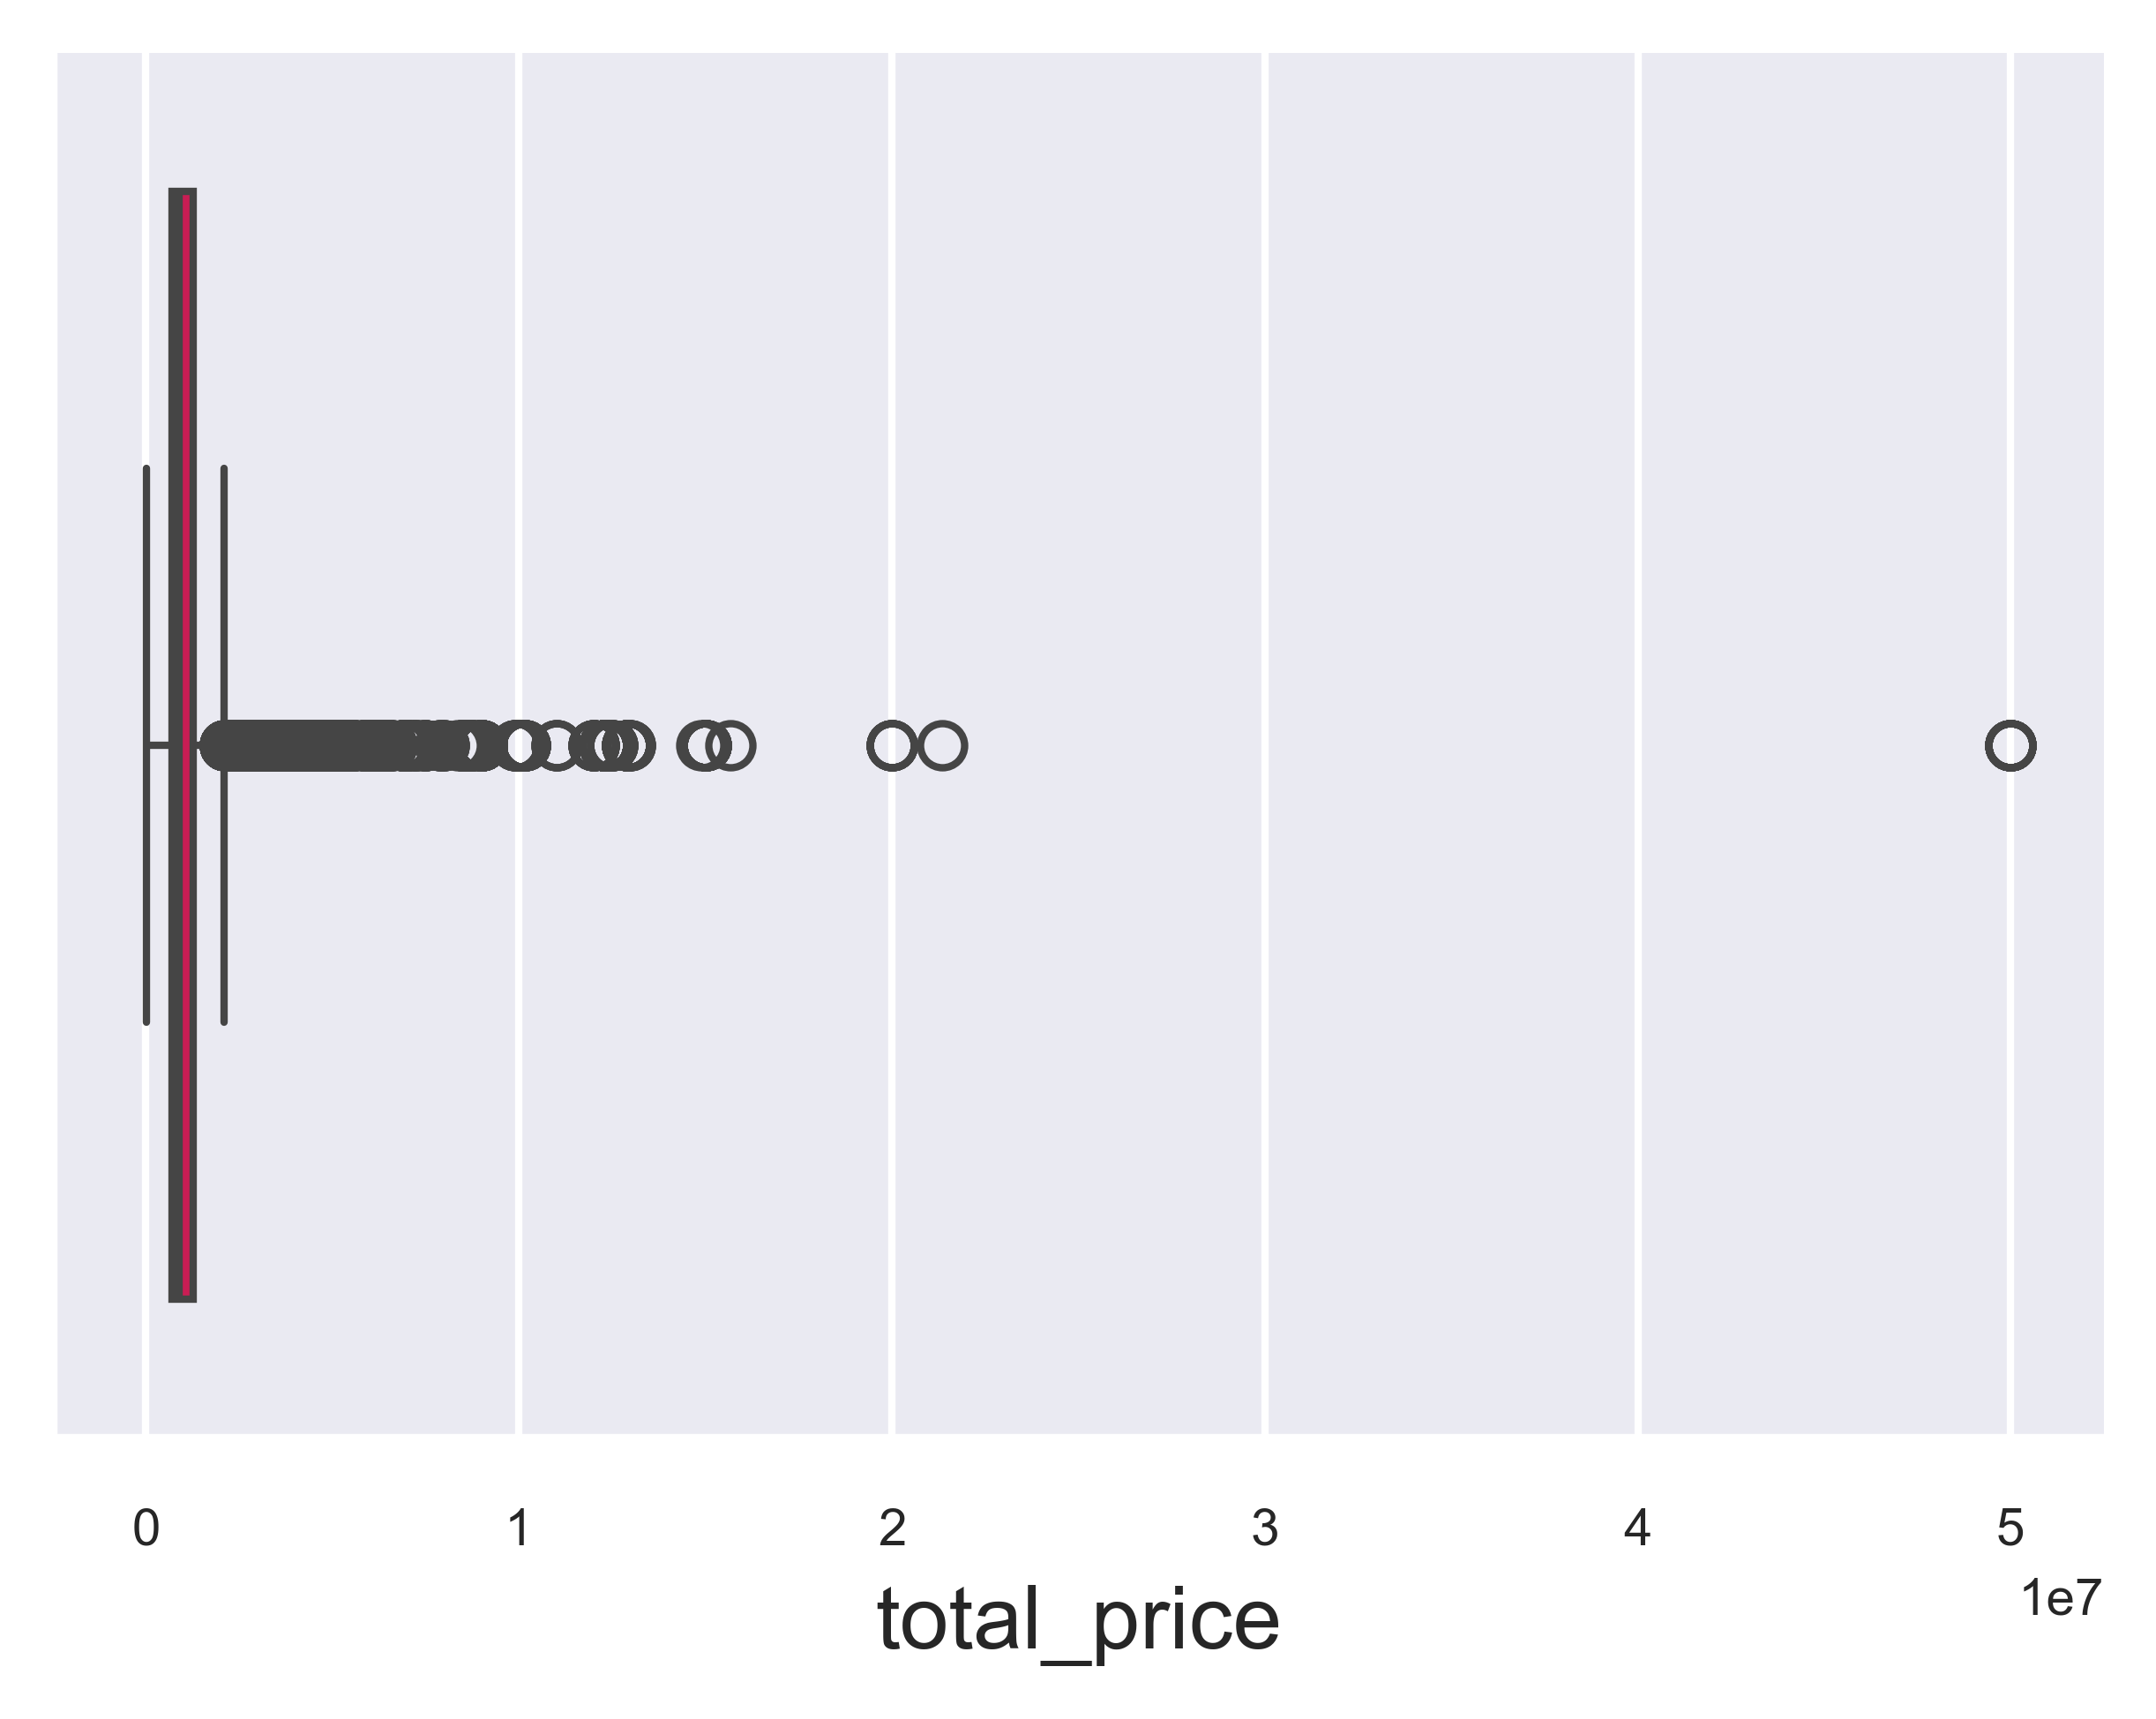

In [80]:
sns.boxplot(x=df['total_price']);

After checking the apartments with very high ``total_price`` I noticed that they are just located in a very expensive building, so we will leave them in the dataset. Let's zoom in to find apartments that are impossibly cheap.

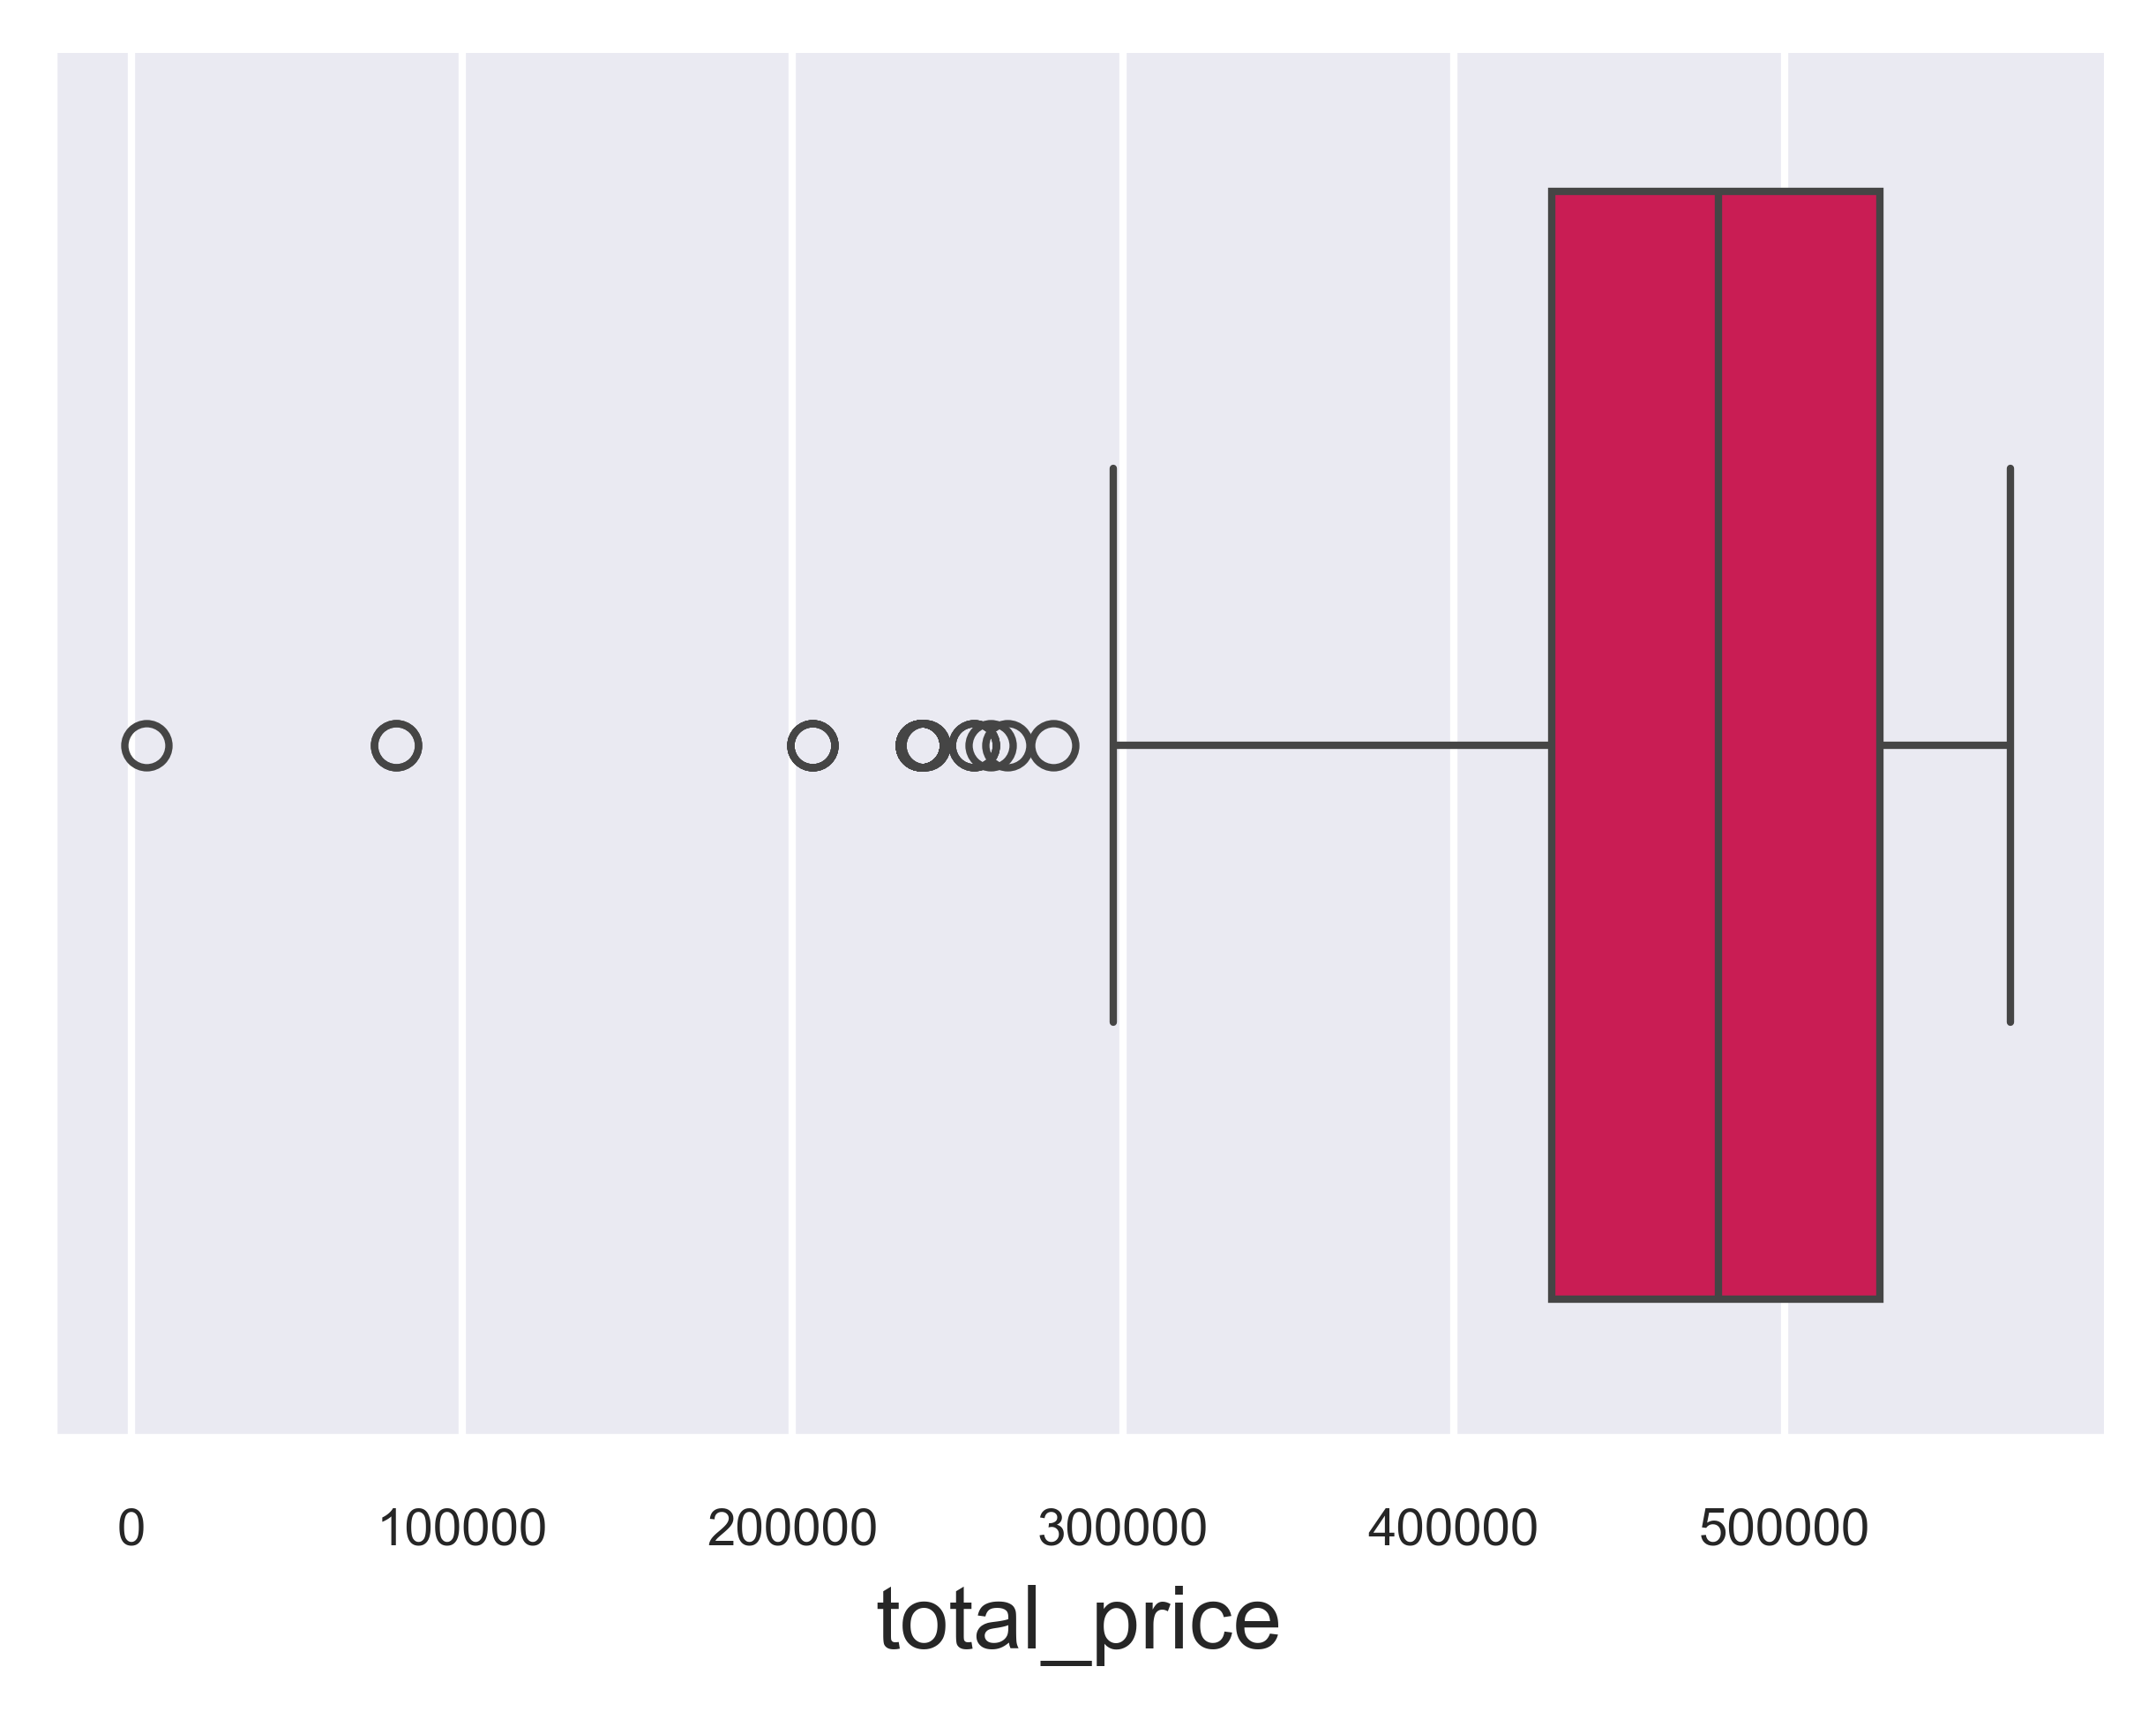

In [81]:
threshold = df['total_price'].quantile(0.1)
df_no_outliers = df[df['total_price'] <= threshold]
sns.boxplot(x=df_no_outliers['total_price']);

In [82]:
print(df[df['total_price']<=300000])
df = df[(df['total_price']!=80000) & (df['total_price']!=4500)]

       total_price  price_per_sqm    area  rooms  floor         rent  \
412       299000.0        16447.0   18.18      1    0.0   250.000000   
718       239000.0        14059.0   17.00      1    4.0   247.000000   
3508      265000.0        10508.0   25.22      1    0.0   250.000000   
3977      260000.0         6842.0   38.00      1    0.0   110.000000   
6288      297000.0         6319.0   47.00      2   -1.0   350.000000   
7137      239000.0        14059.0   17.00      1    4.0   247.000000   
7805       80000.0          259.0  309.00      2    1.0  4289.407434   
8042      239000.0        14372.0   16.63      1    4.0    15.000000   
8821      206000.0         3962.0   52.00      3    0.0   721.842028   
9122      239000.0        14372.0   16.63      1    4.0    15.000000   
9276      239000.0        14372.0   16.63      1    4.0    15.000000   
9603      300000.0        13953.0   21.50      1    1.0   298.453915   
9694      299000.0        16447.0   18.18      1    0.0   250.00

I've removed three rows, because they included some incorrect data.

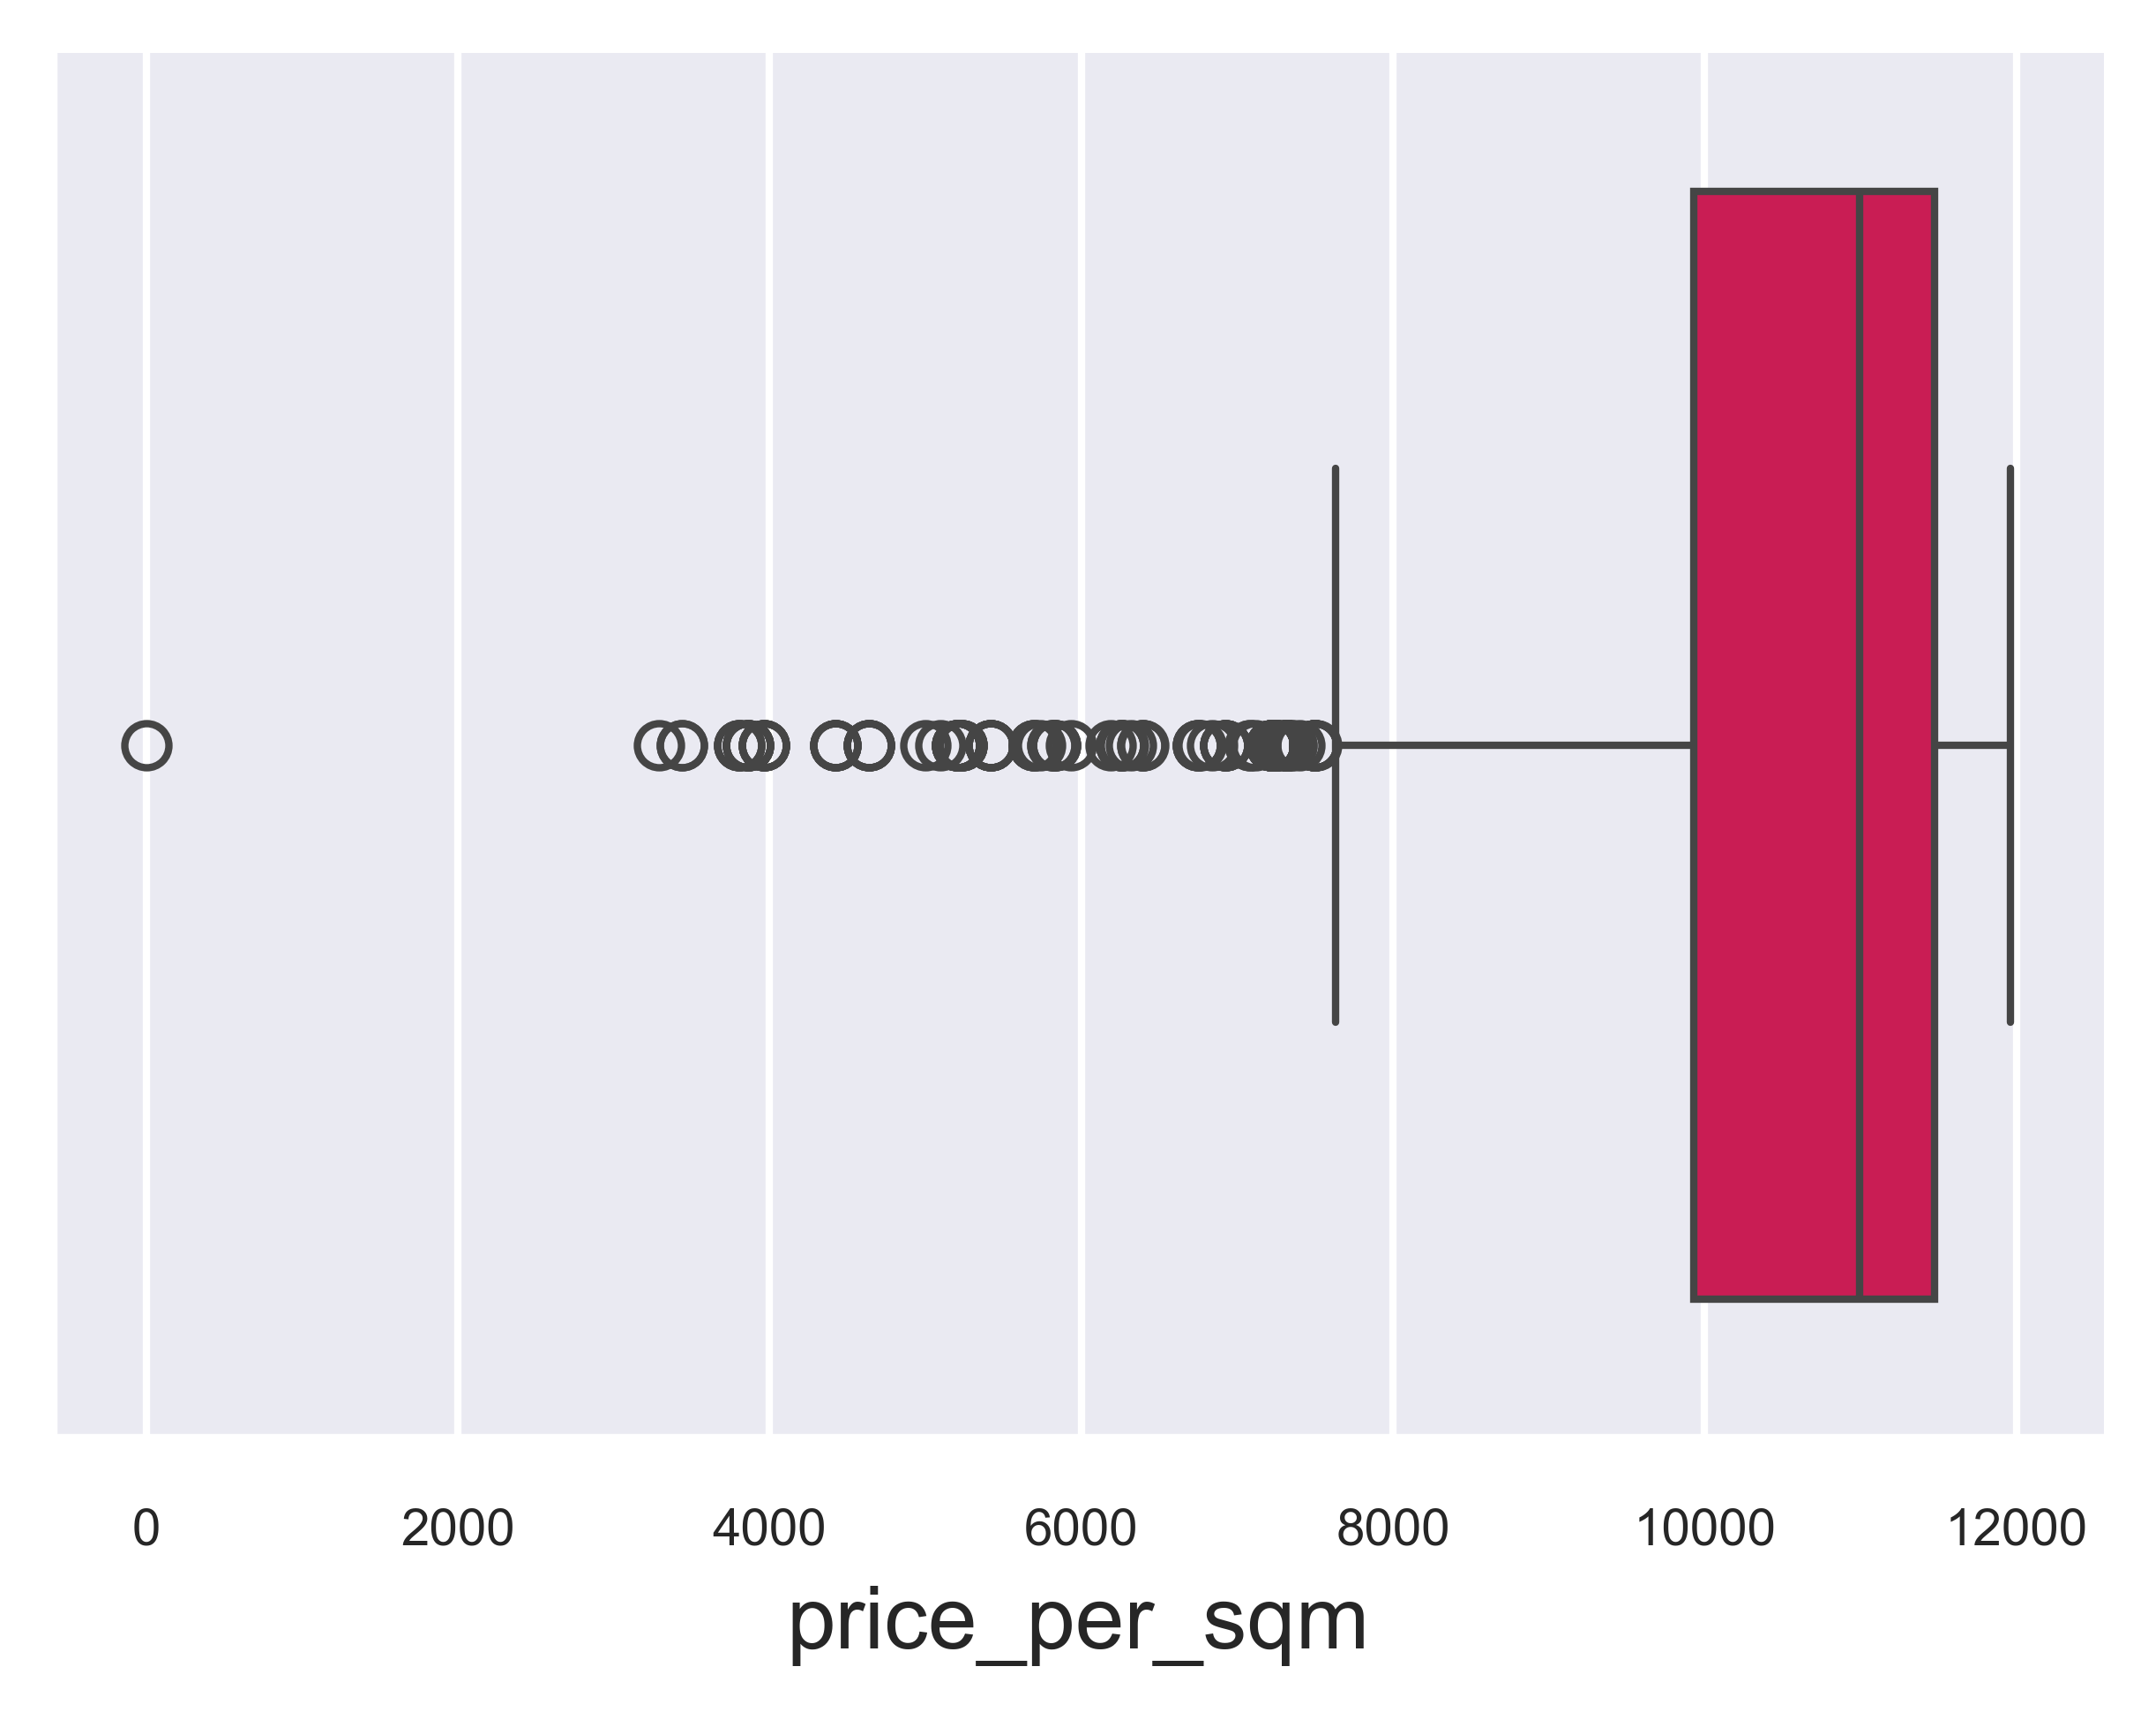

In [83]:
threshold = df['price_per_sqm'].quantile(0.1)
df_no_outliers = df[df['price_per_sqm'] <= threshold]
sns.boxplot(x=df_no_outliers['price_per_sqm']);

In [84]:
df = df[df['price_per_sqm']>2000]

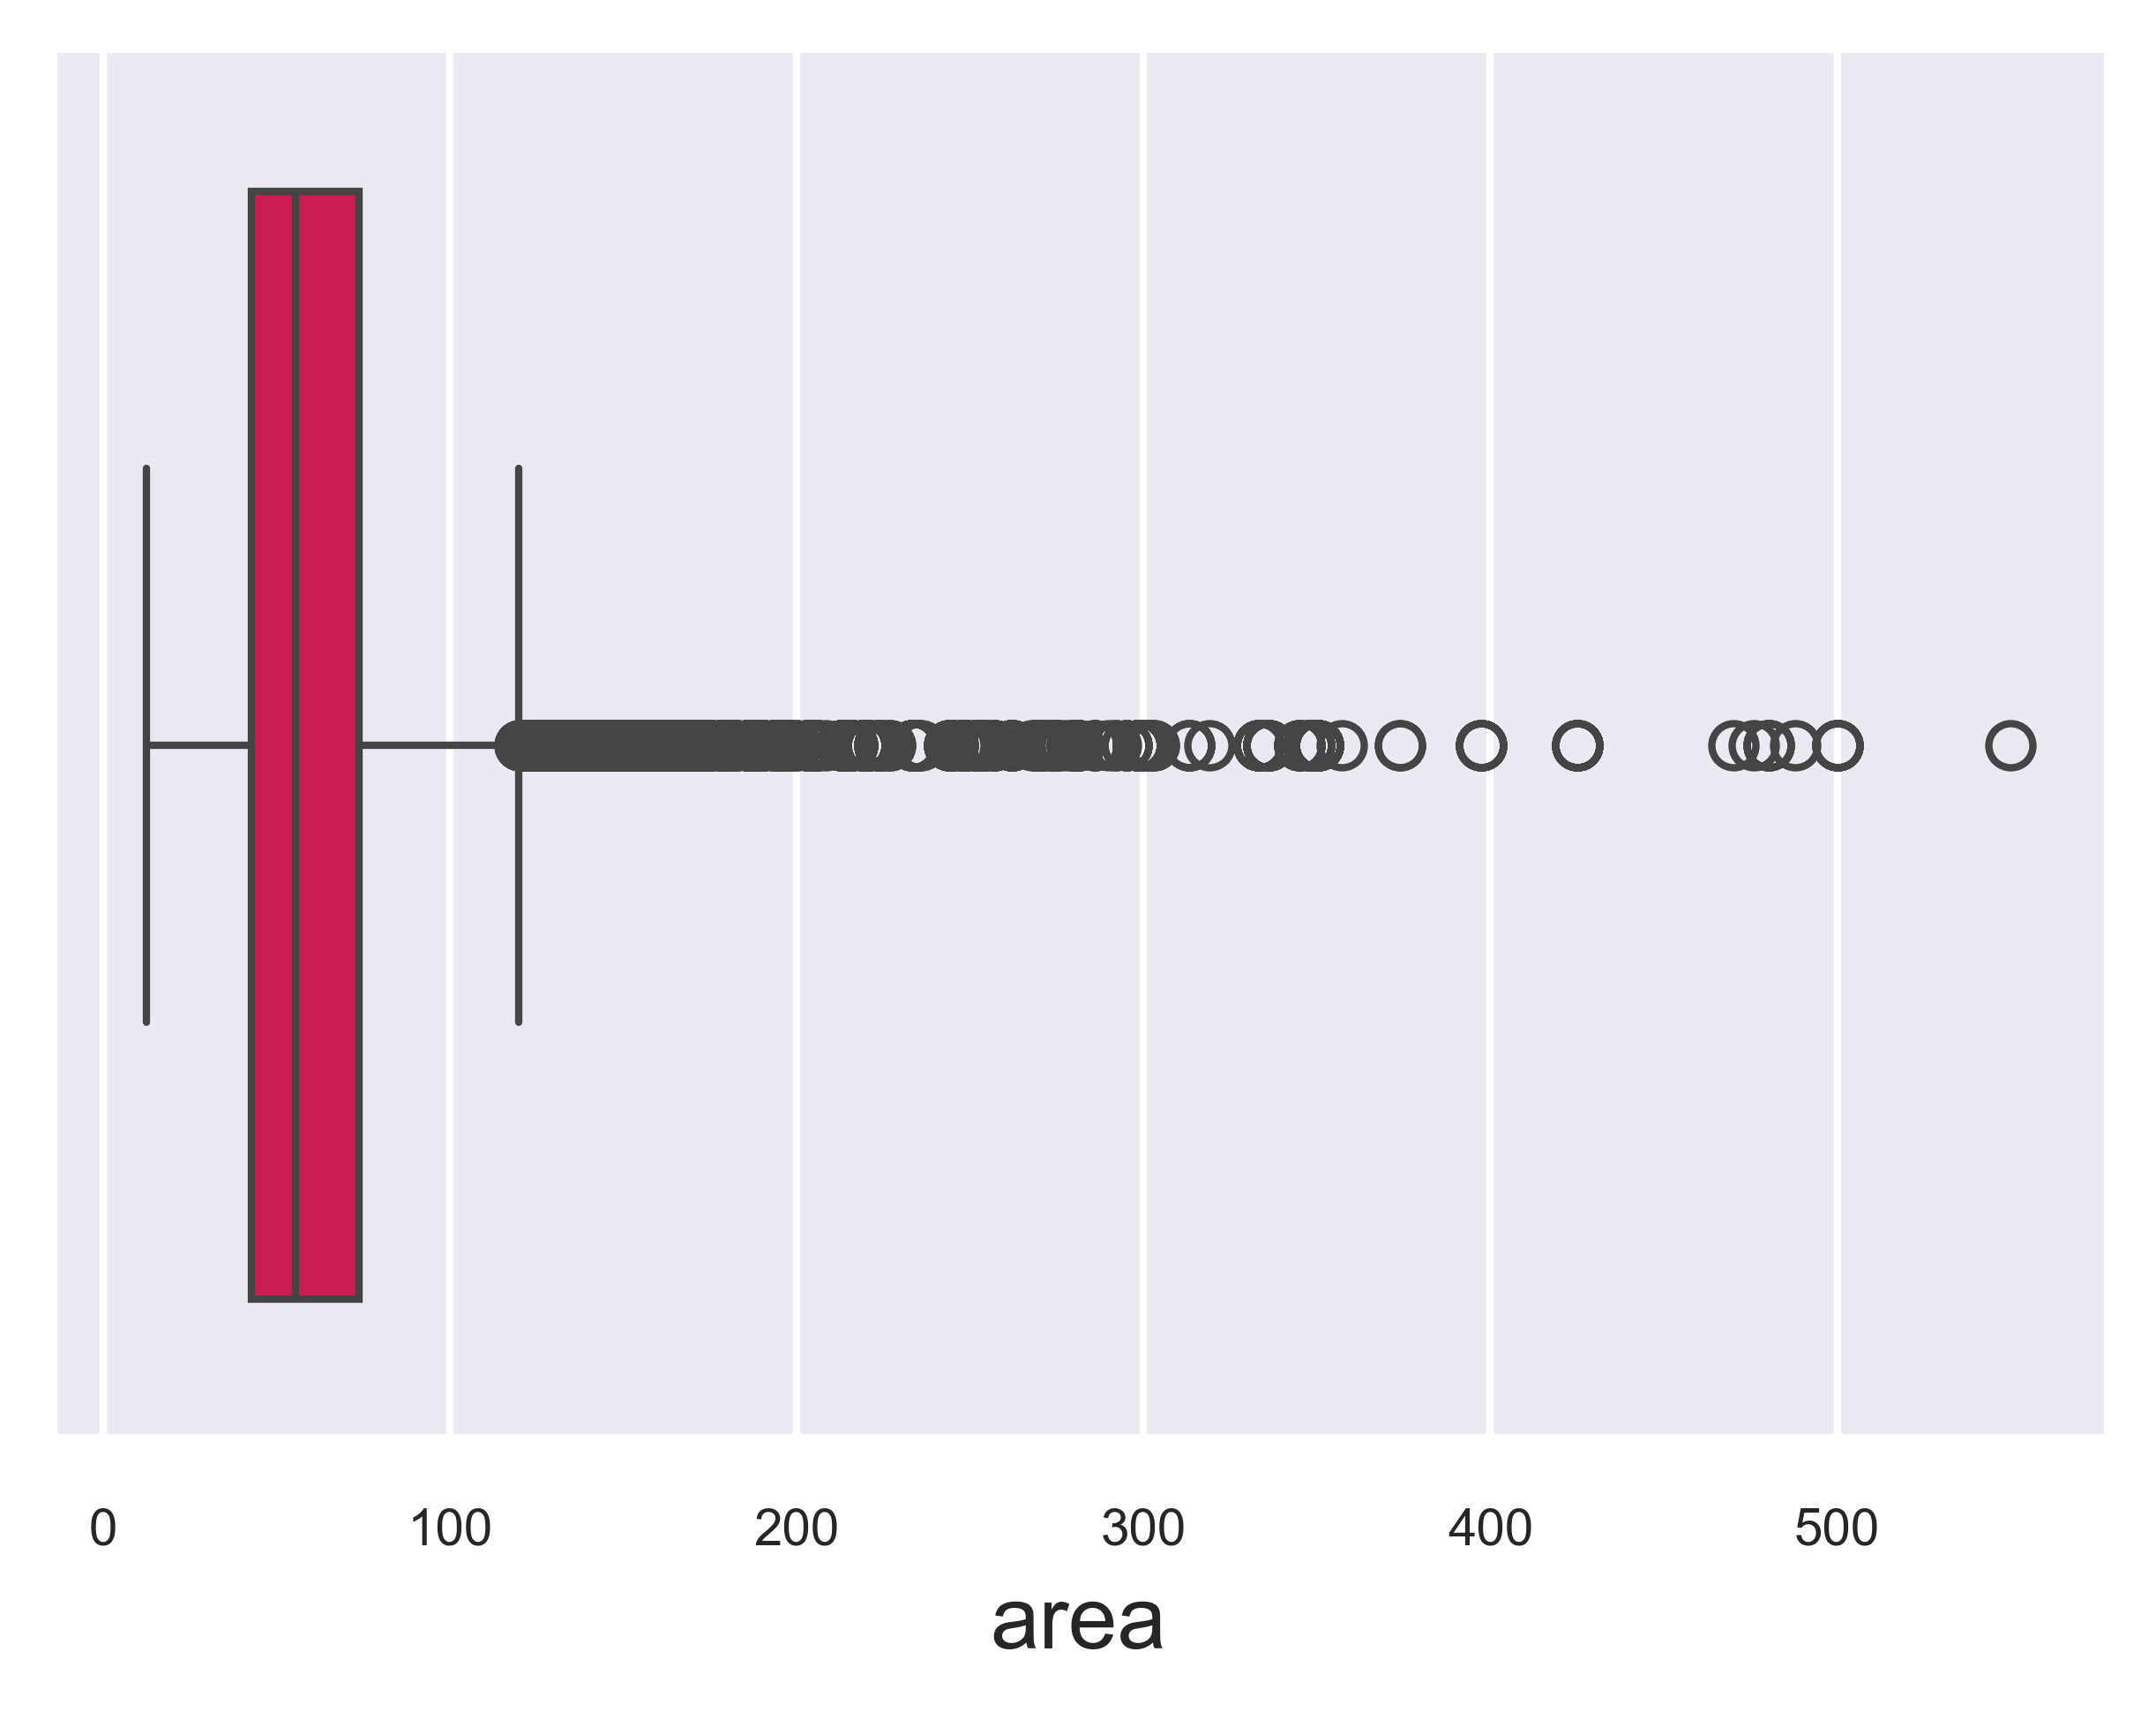

In [85]:
sns.boxplot(x=df['area']);

This time we have to investigate apartments with very big areas and also the one with very small ones. 

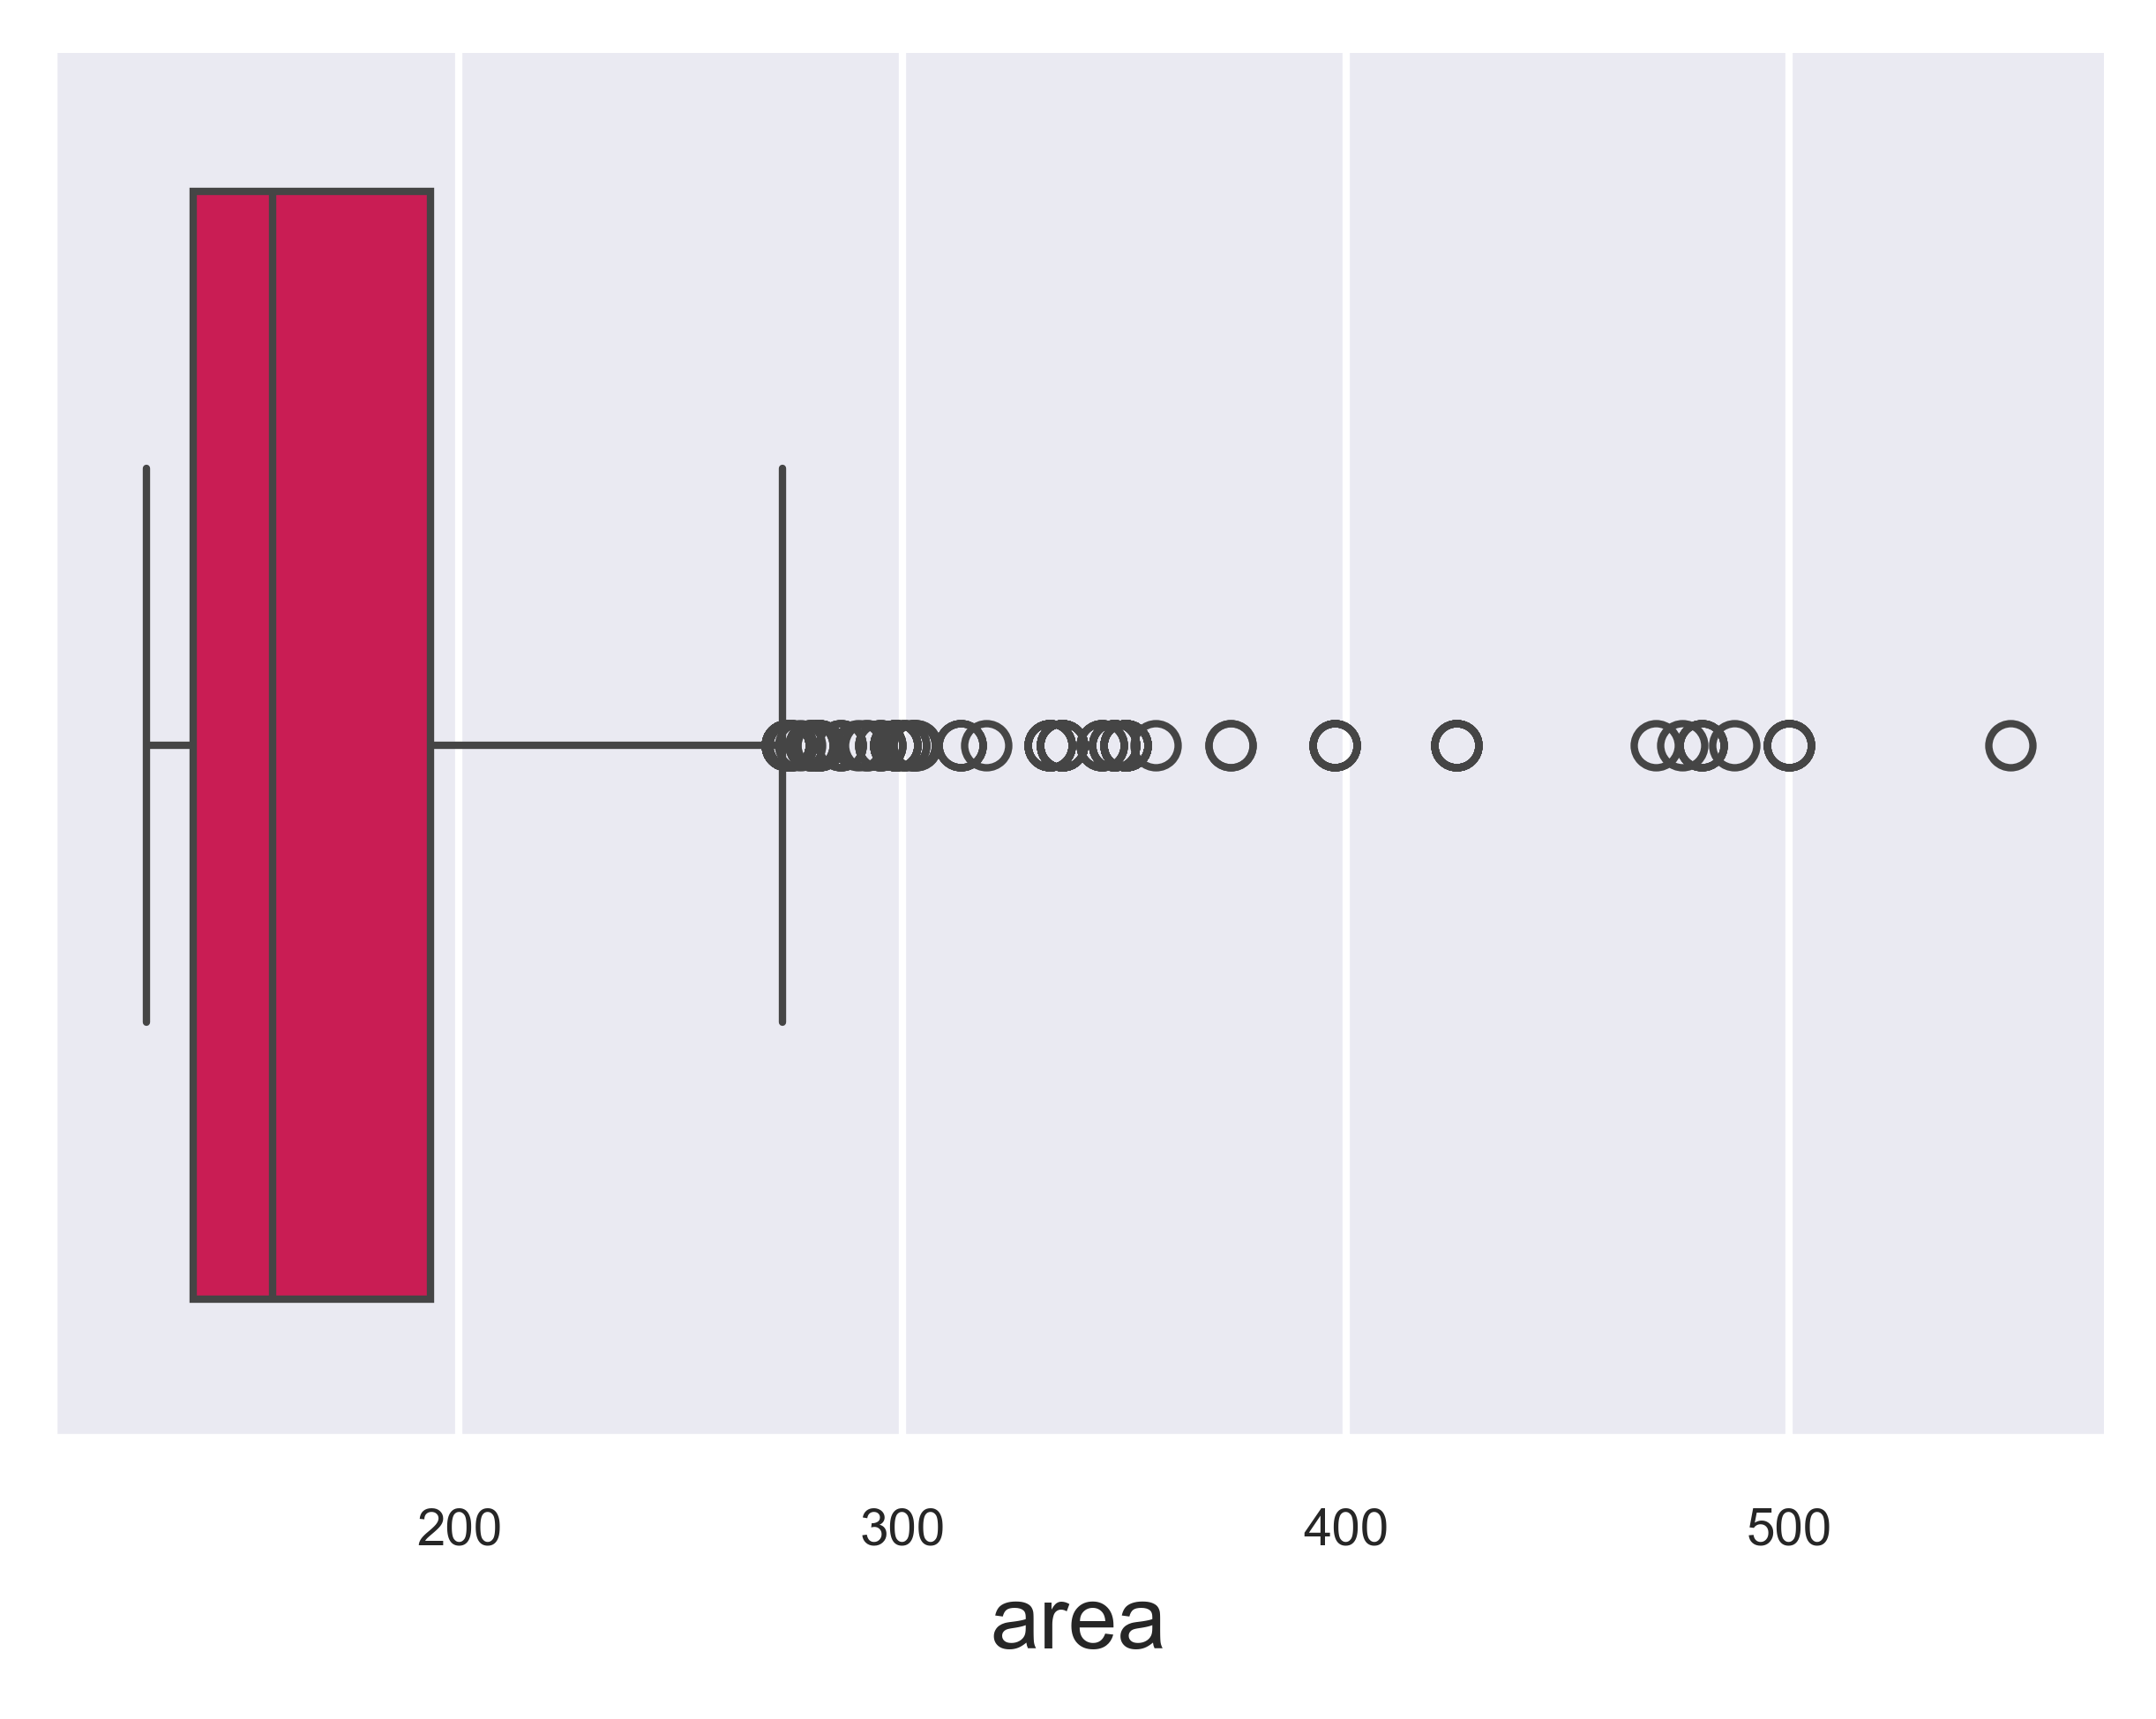

In [86]:
threshold = df['area'].quantile(0.95)
df_no_outliers = df[df['area'] >= threshold]
sns.boxplot(x=df_no_outliers['area']);

In [87]:
print(df[df['area']>=250])
df = df[df['area']!=3950000.0]

       total_price  price_per_sqm    area  rooms  floor         rent  \
68      10161310.0        28999.0  350.40      6    3.0  3500.000000   
69       8654760.0        29000.0  298.44      5    1.0  2980.000000   
243      2990000.0        10136.0  295.00      6    2.0  4095.065349   
421      4600000.0        16974.0  271.00      5    8.0  3728.678482   
422      6500000.0        24809.0  262.00      4    4.0  3746.262690   
...            ...            ...     ...    ...    ...          ...   
27110    6500000.0        24809.0  262.00      6    4.0  3746.262690   
27541    3450000.0        12825.0  269.00      6    2.0  3684.306460   
28225    9950000.0        35409.0  281.00      5    2.0  3848.662139   
28365    1599999.0         4638.0  345.00      7    1.0   300.000000   
28438    3000000.0        30669.0  425.00      5    6.0  5350.000000   

       elevator   built           b_type  \
68          1.0  2016.0  apartamentowiec   
69          1.0  2016.0  apartamentowiec   
243

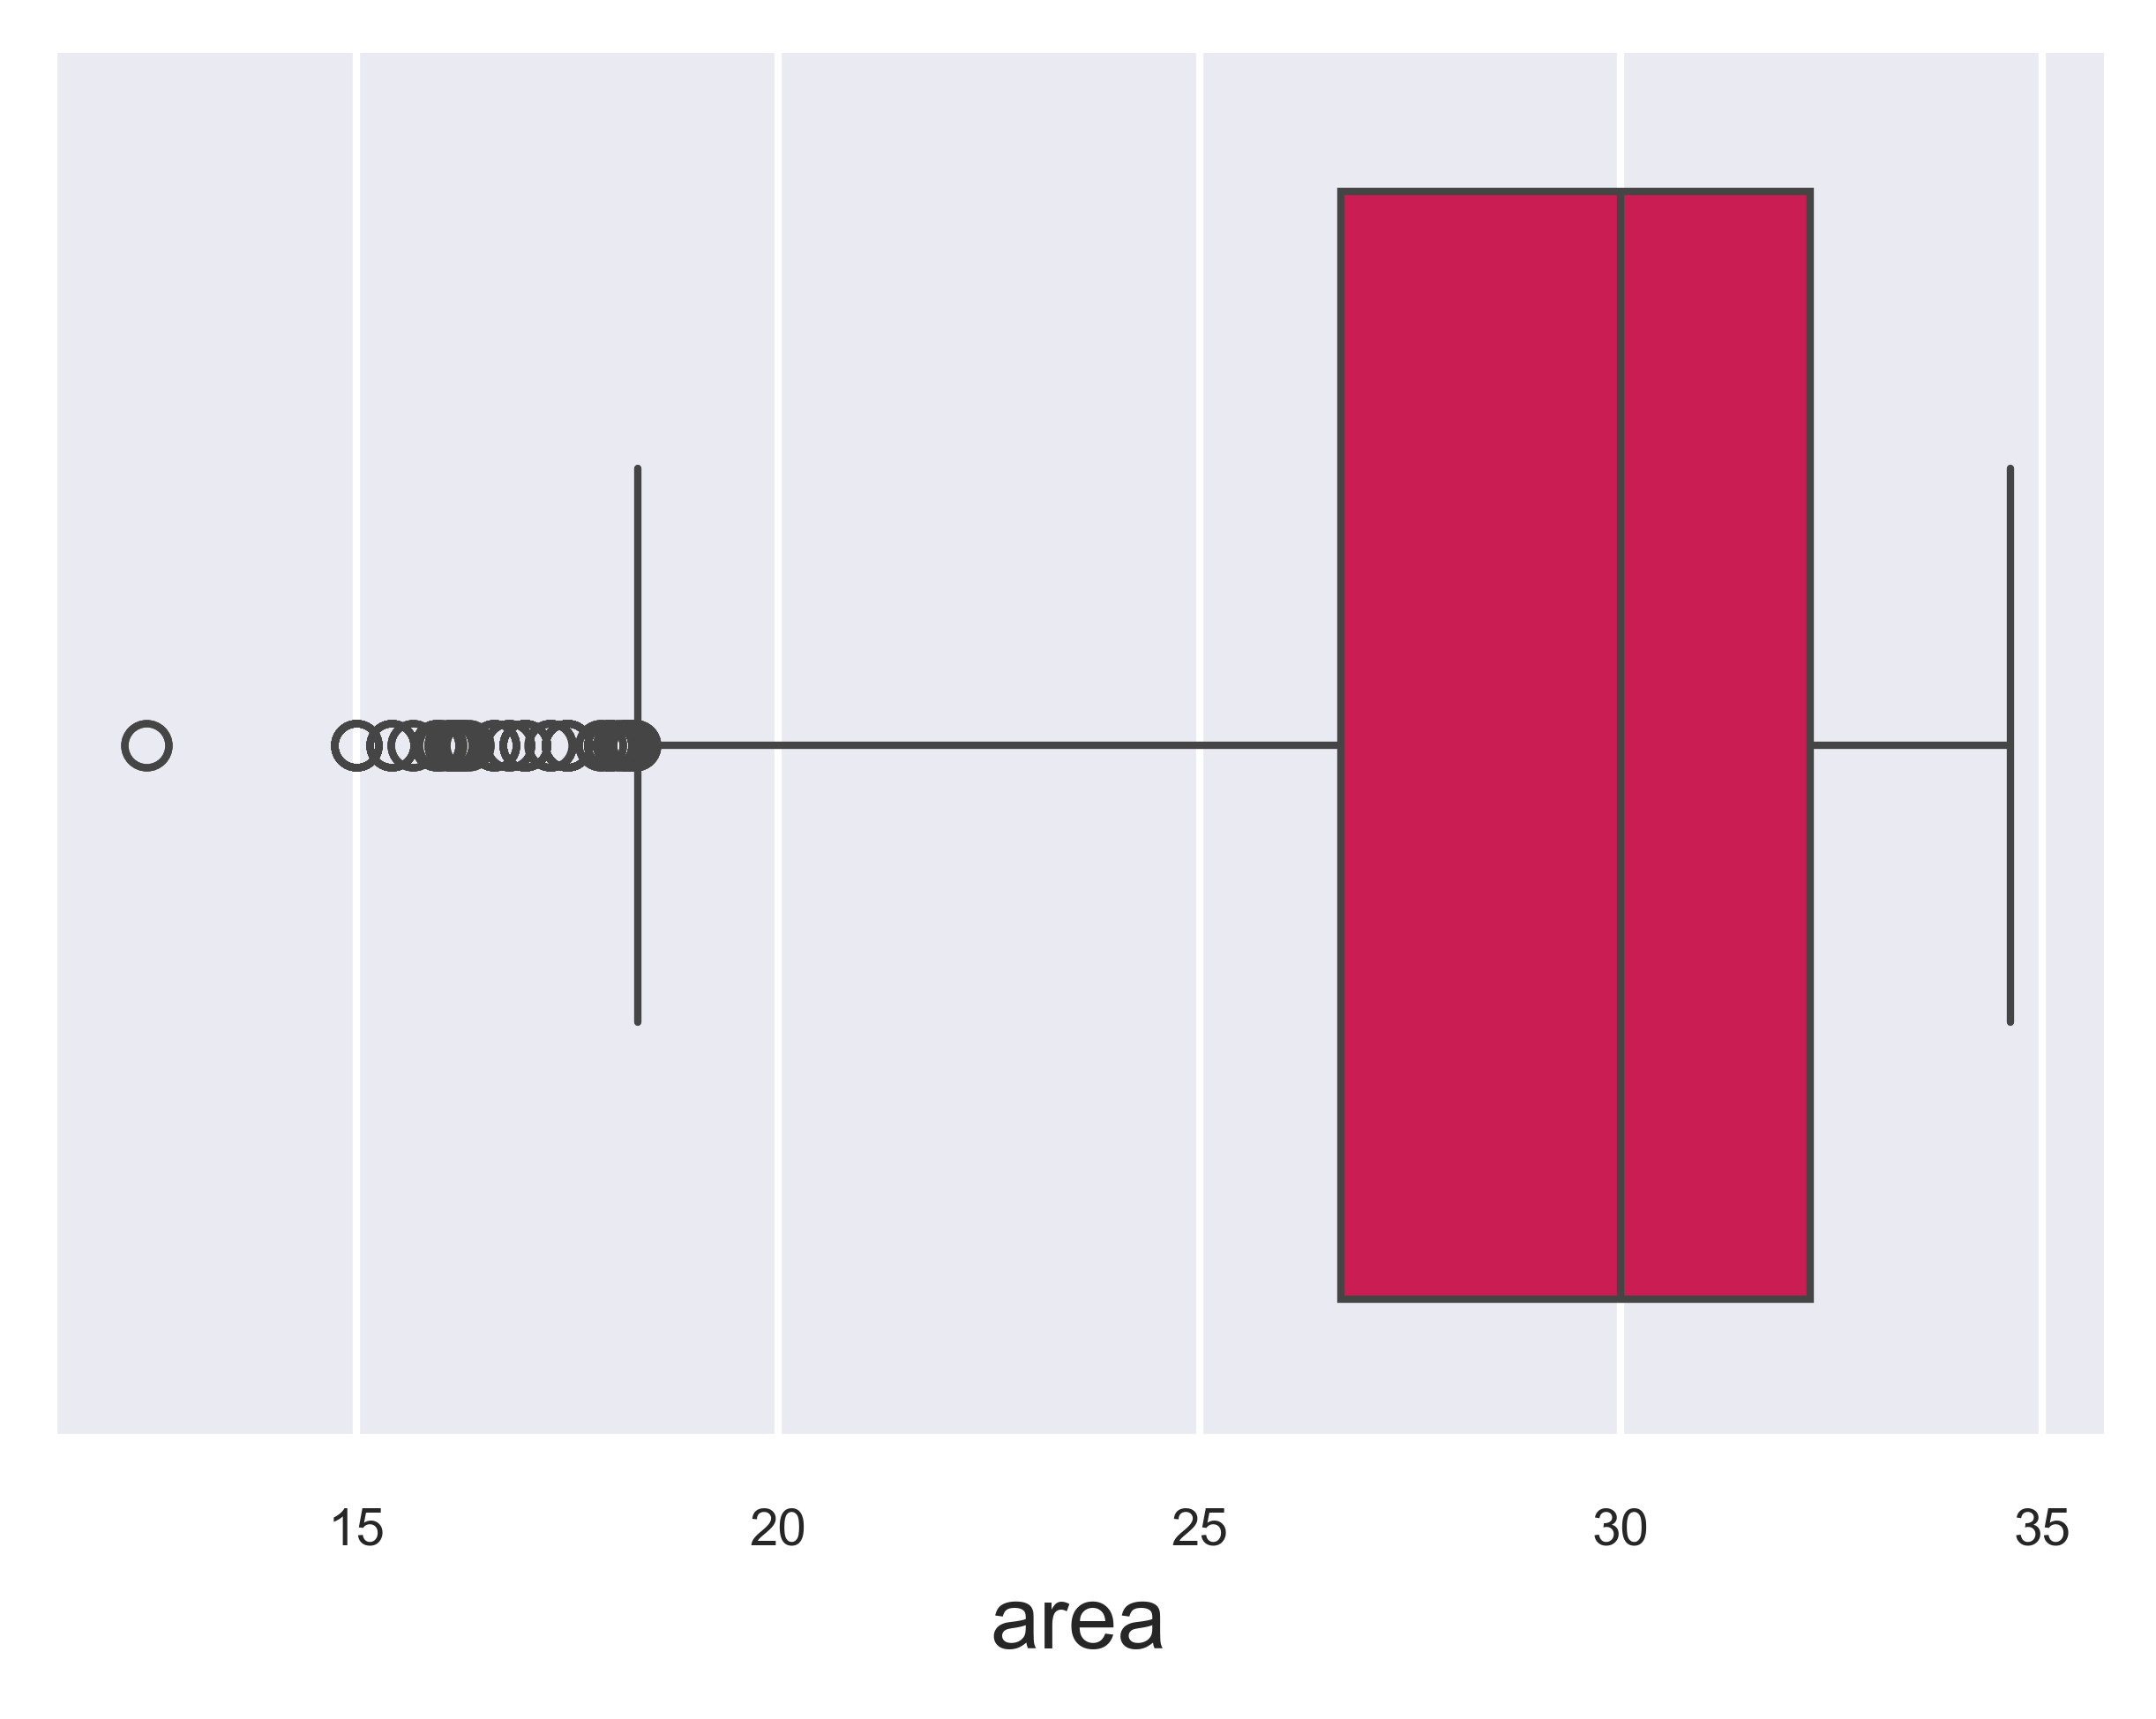

In [88]:
threshold = df['area'].quantile(0.1)
df_no_outliers = df[df['area'] <= threshold]
sns.boxplot(x=df_no_outliers['area']);

In [89]:
df[df['area']<=17]

,total_price,price_per_sqm,area,rooms,floor,rent,elevator,built,b_type,link,max_floor,balcony,terrace,garden,street,district,subdistrict,distance
233,390000.0,24375.0,16.00,1,4.0,350.000000,0.0,1953.0,kamienica,https://www.otodom.pl/pl/oferta/gotowiec-inwes...,5.0,1.0,0.0,0.0,Puławska 10,Mokotów,Stary Mokotów,3234.908
718,239000.0,14059.0,17.00,1,4.0,247.000000,0.0,1920.0,kamienica,https://www.otodom.pl/pl/oferta/kamienica-metr...,4.0,1.0,0.0,0.0,Zachariasza,Praga-Północ,Szmulowizna,4658.643
895,349000.0,27920.0,12.50,1,2.0,420.000000,0.0,1933.0,kamienica,https://www.otodom.pl/pl/oferta/ul-dolna-mokot...,5.0,1.0,0.0,0.0,NaN,Mokotów,Sielce,3280.982
2384,328000.0,21285.0,15.41,1,0.0,220.000000,1.0,1970.0,blok,https://www.otodom.pl/pl/oferta/lokal-16m-pod-...,2.0,0.0,0.0,1.0,Stefana Batorego,Mokotów,Stary Mokotów,3110.384
3615,428350.0,26606.0,16.10,1,1.0,600.000000,1.0,1994.0,blok,https://www.otodom.pl/pl/oferta/apartament-inw...,15.0,1.0,0.0,0.0,Skierniewicka 21,Wola,Czyste,3018.882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27636,310000.0,18983.0,16.33,1,2.0,226.686160,1.0,2003.0,blok,https://www.otodom.pl/pl/oferta/praga-studio-m...,3.0,1.0,0.0,0.0,Darłowska 2,Praga-Południe,Grochów-Południowy,5208.662
27637,310000.0,19171.0,16.17,1,2.0,224.465107,1.0,2021.0,apartamentowiec,https://www.otodom.pl/pl/oferta/praga-studio-m...,3.0,1.0,0.0,0.0,Darłowska 2,Praga-Południe,Grochów-Południowy,5048.945
27688,310000.0,19089.0,16.24,1,1.0,225.436818,1.0,1993.0,blok,https://www.otodom.pl/pl/oferta/praga-studio-m...,3.0,1.0,0.0,0.0,Darłowska 2,Praga-Południe,Grochów-Południowy,4814.721
27698,369000.0,21706.0,17.00,1,0.0,300.000000,1.0,1954.0,blok,https://www.otodom.pl/pl/oferta/kawalerka-na-p...,3.0,0.0,1.0,0.0,NaN,Praga-Południe,Grochów-Centrum,5486.467


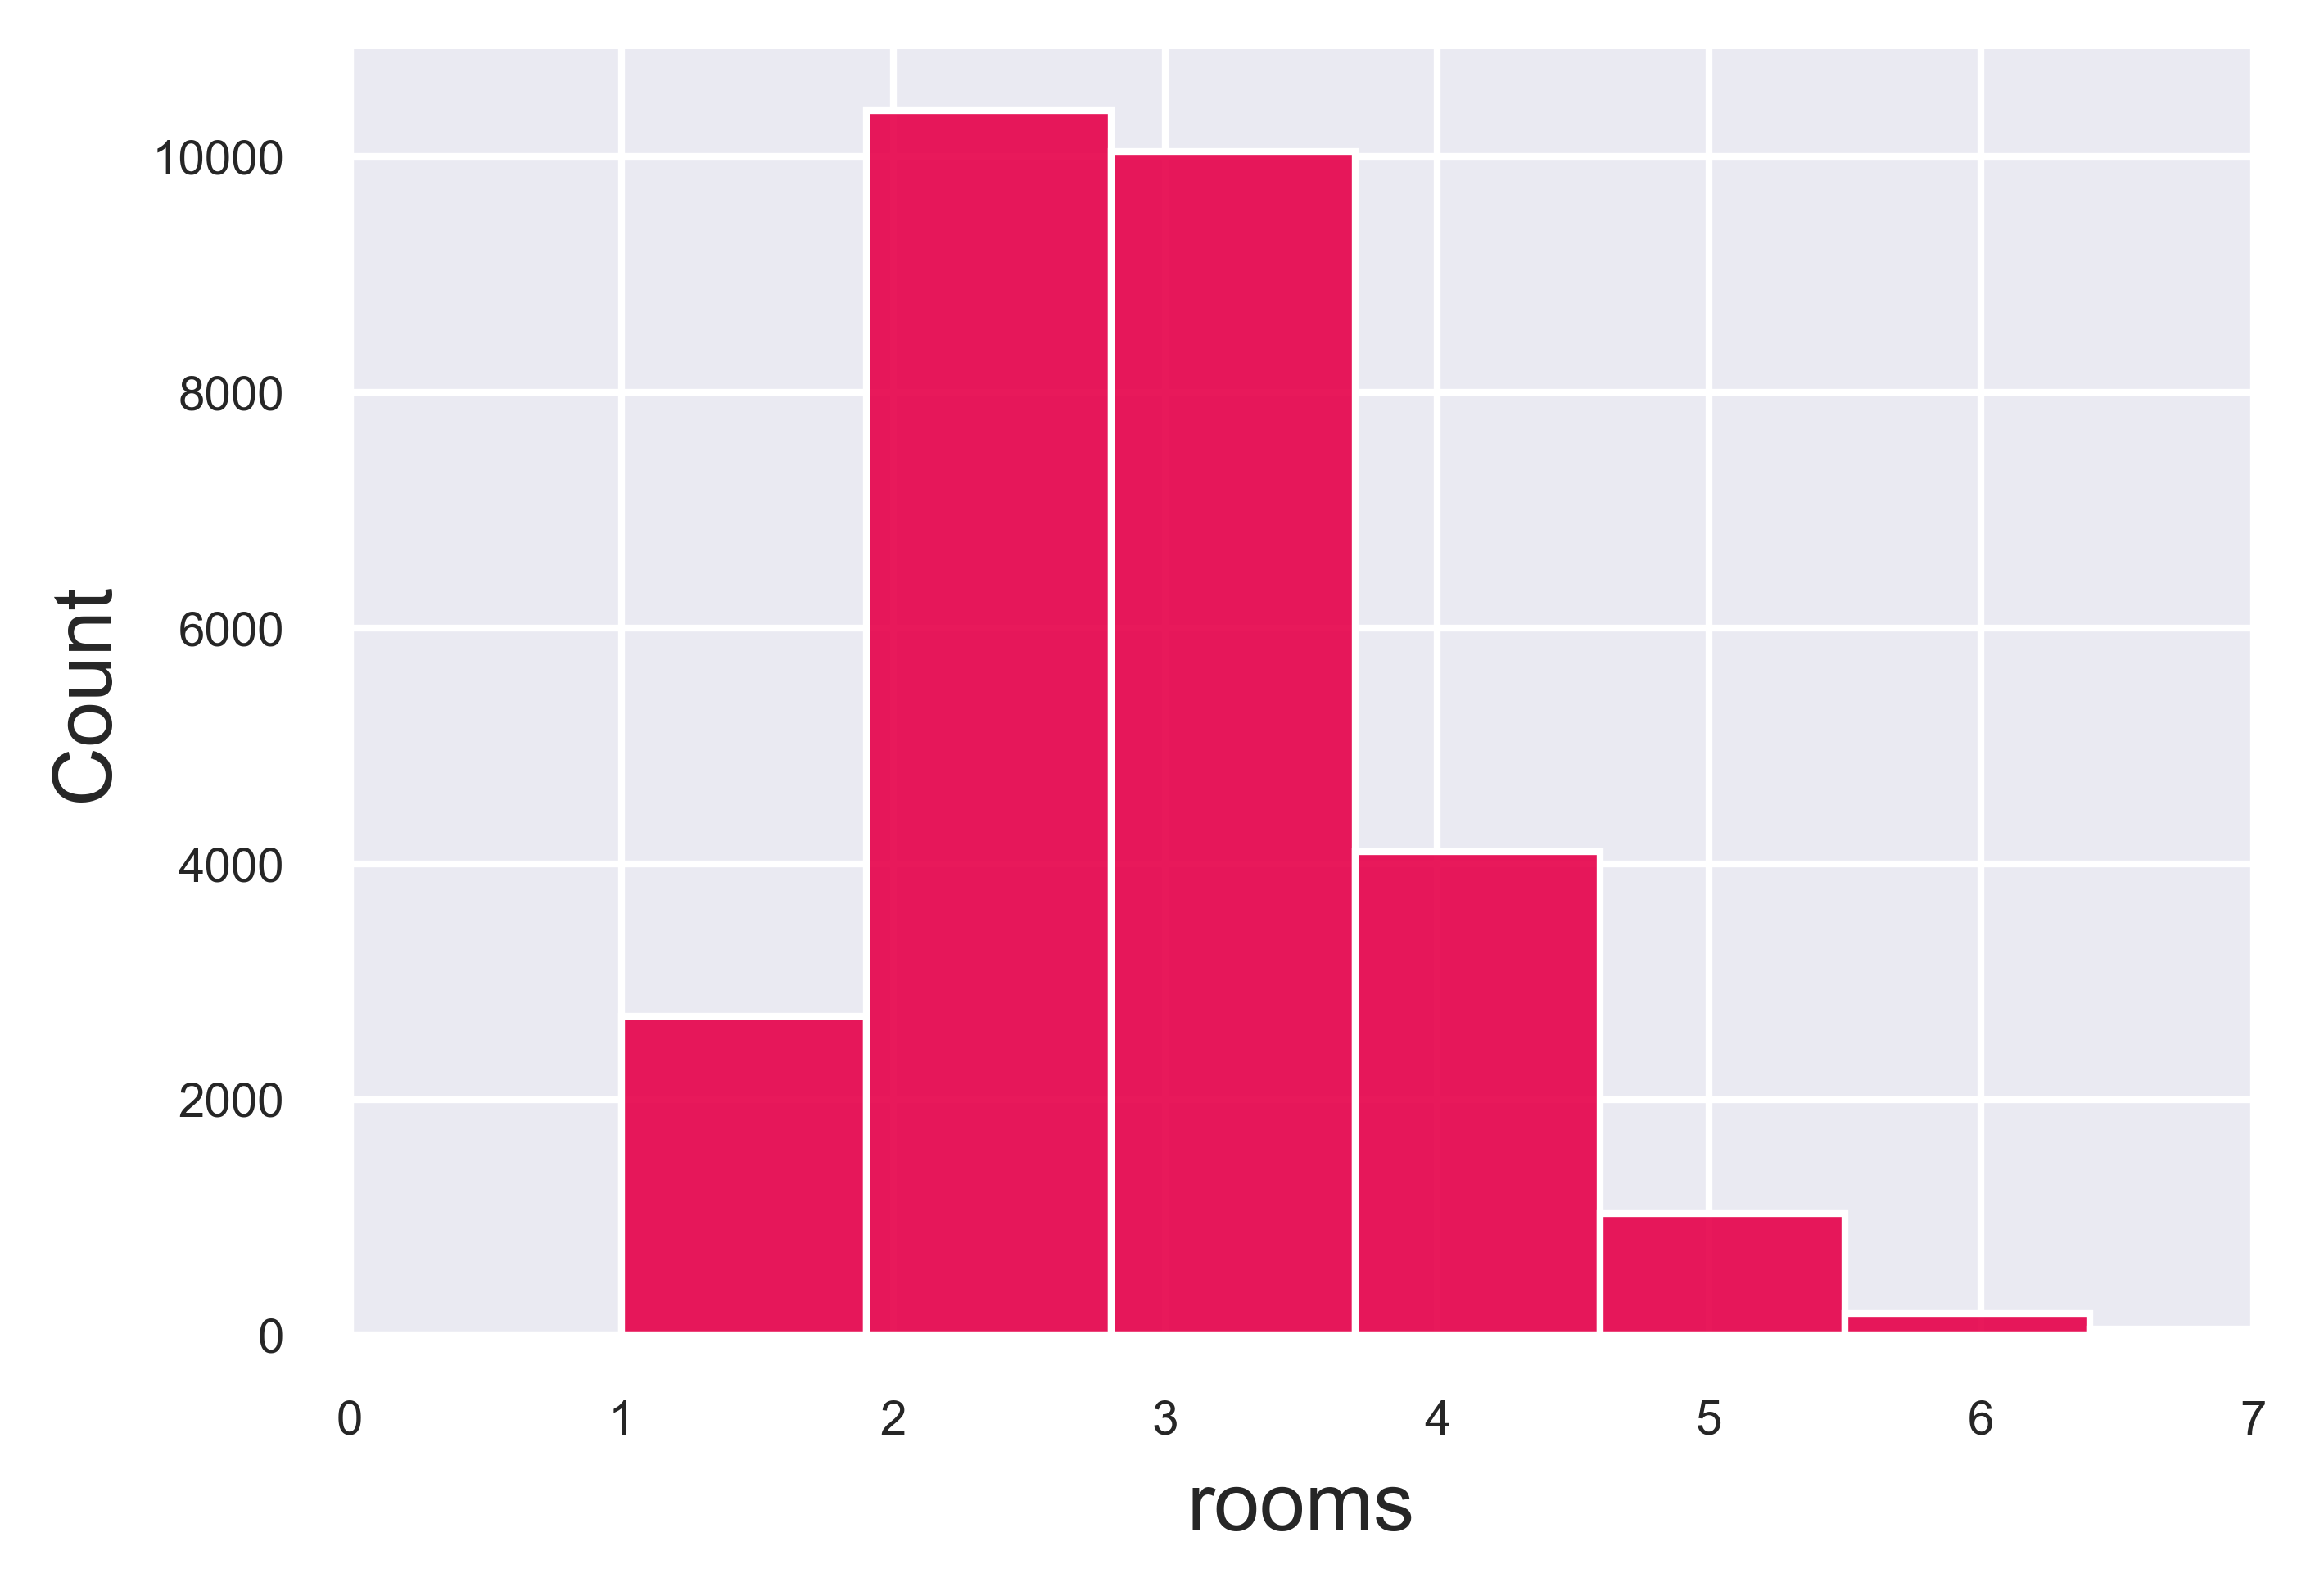

In [90]:
sns.histplot(df['rooms'], bins=10, alpha=0.9);
plt.xlim(0, 7);

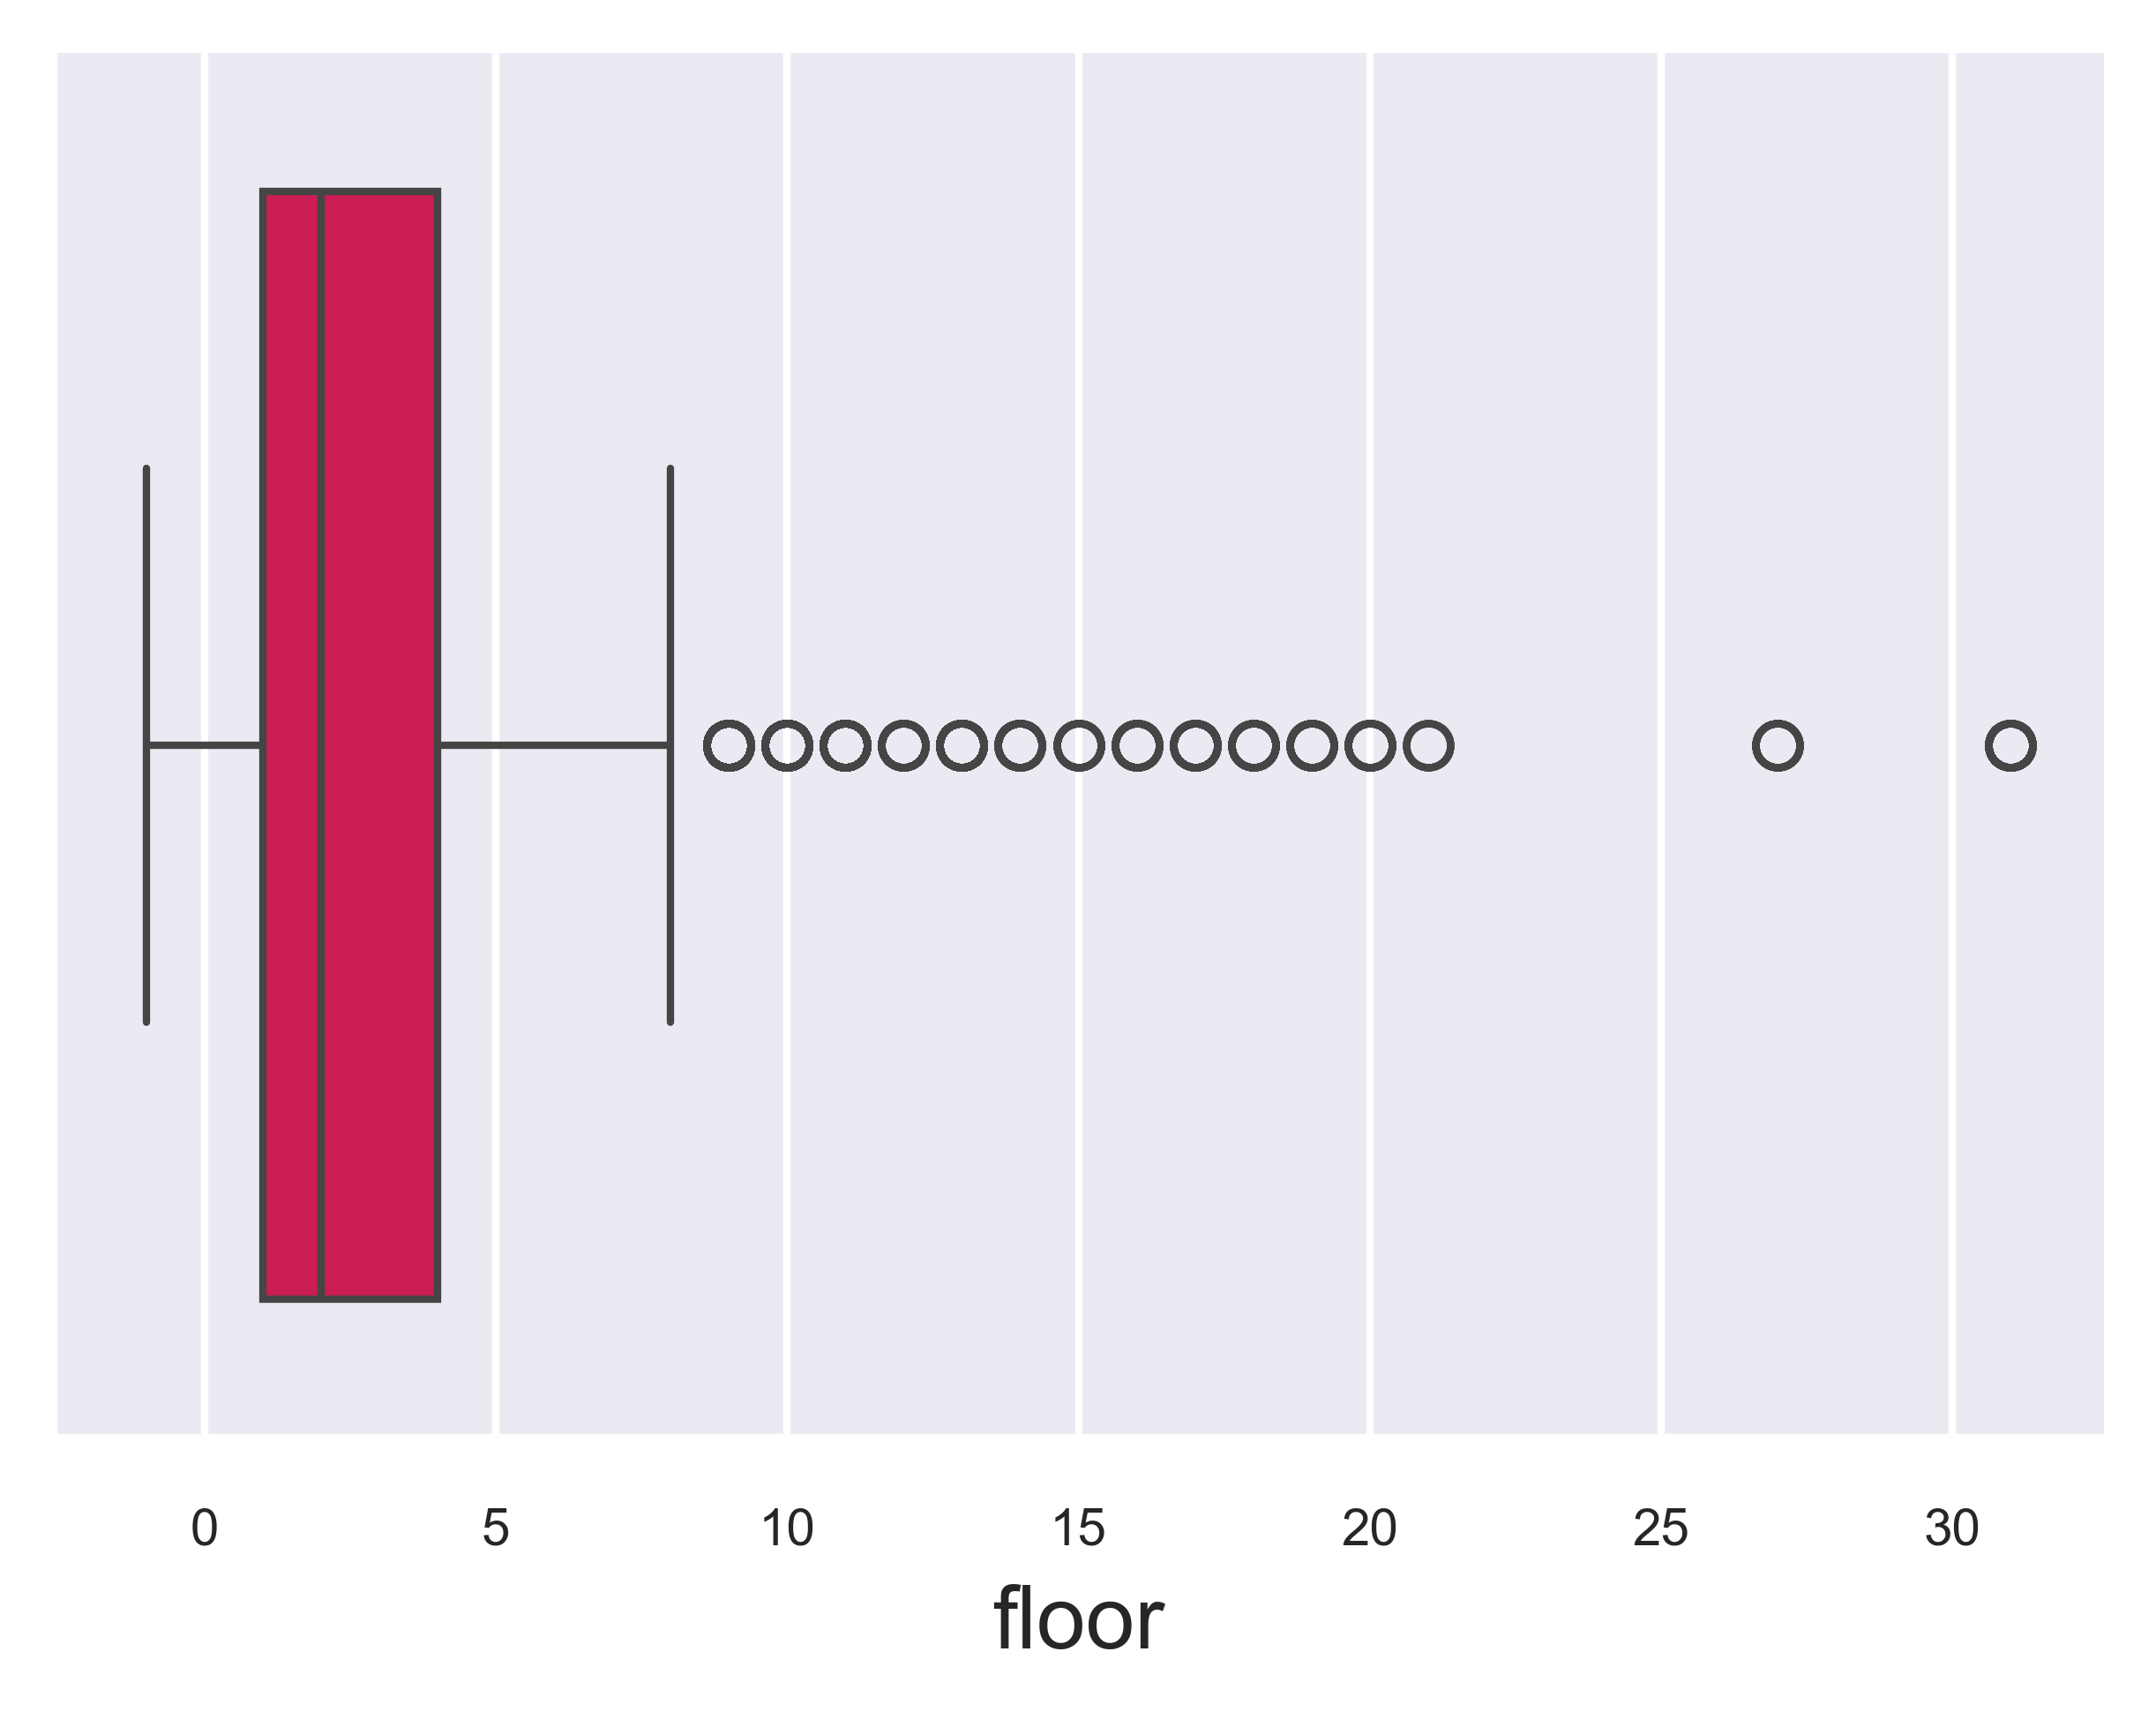

In [91]:
sns.boxplot(x=df['floor']);

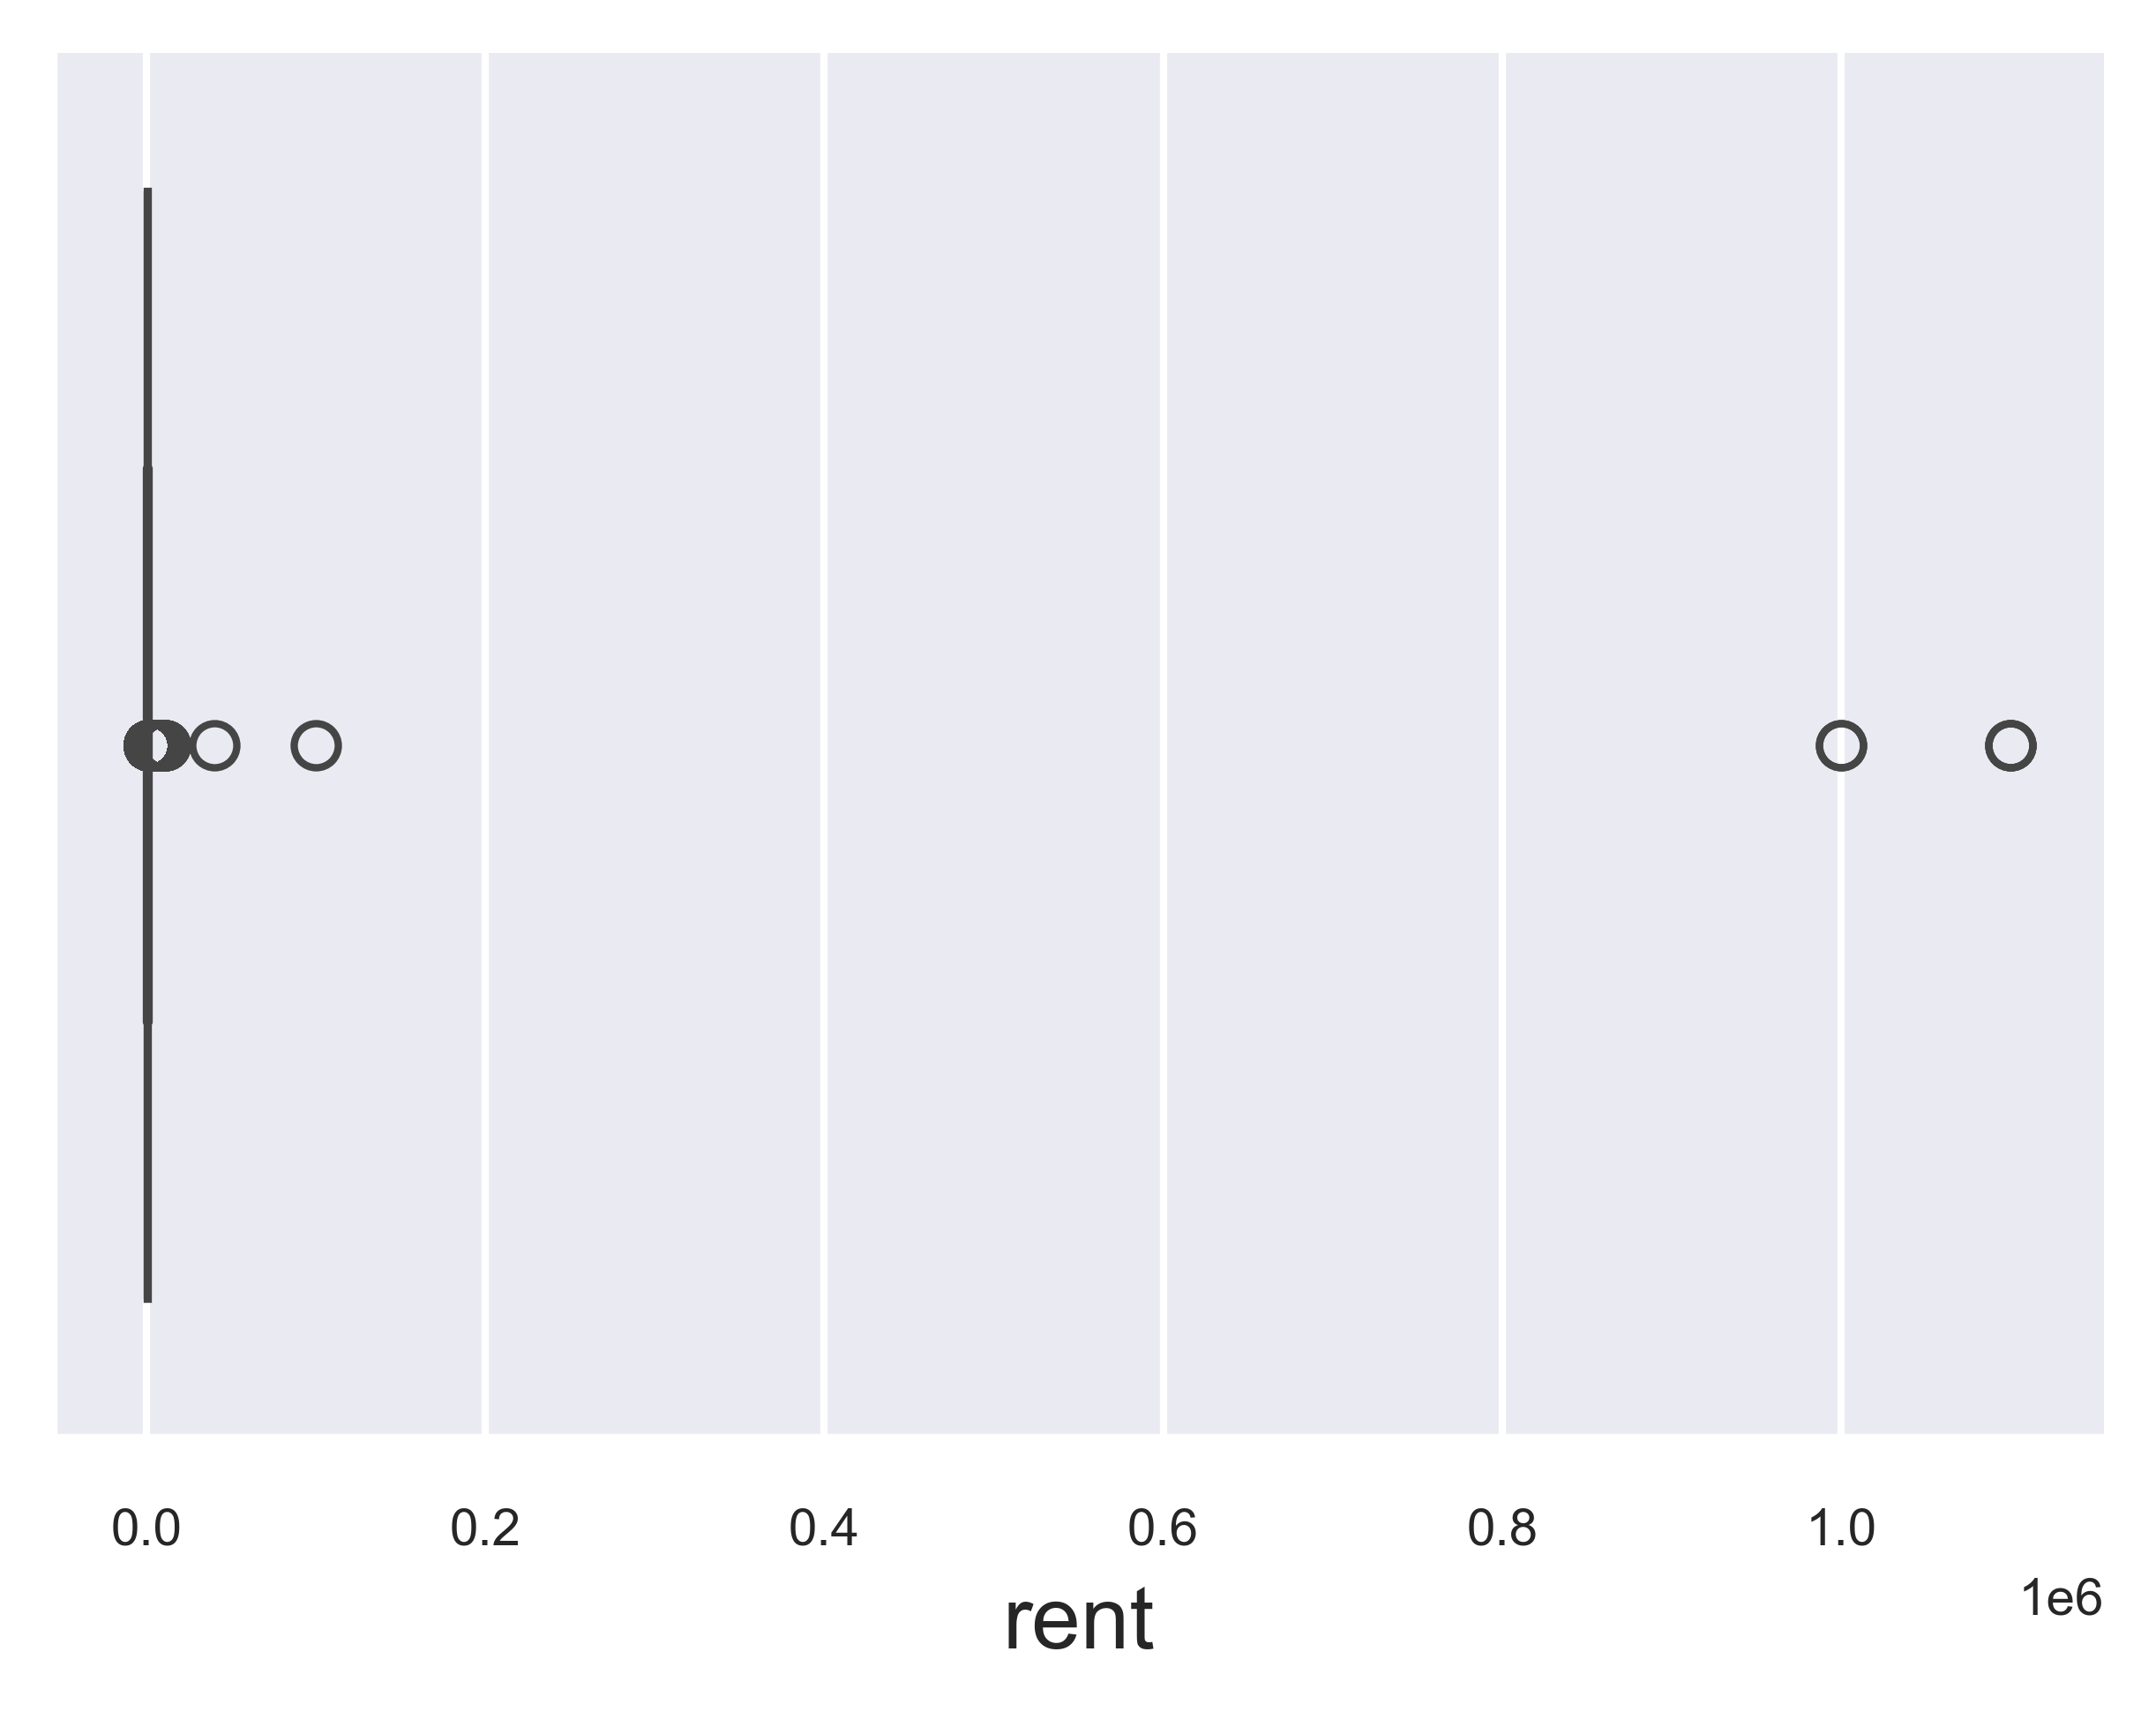

In [92]:
sns.boxplot(x=df['rent']);

In [93]:
print(df[df['rent']>=8000])

       total_price  price_per_sqm    area  rooms  floor          rent  \
733     12300000.0        44856.0  274.21      5    1.0  1.000000e+04   
736      6378017.5        25750.0  247.69      5   11.0  9.619962e+03   
1120     5200000.0        13083.0  397.45      6   13.0  1.107704e+04   
1204     1420000.0        22188.0   64.00      2    2.0  1.000000e+06   
2056    15000000.0        44643.0  336.00      5    2.0  9.364411e+03   
2556    15000000.0        44643.0  336.00      5    2.0  9.364411e+03   
4347     6123600.0        24300.0  252.00      5   10.0  9.787357e+03   
4432     8996130.0        26999.0  333.20      5    3.0  9.286374e+03   
4467     7224562.0        24211.0  298.40      6    1.0  8.316489e+03   
4489    15000000.0        44643.0  336.00      5    2.0  9.364411e+03   
5301     8482534.0        24208.0  350.40      5    2.0  9.765743e+03   
5392      694407.0        13102.0   53.00      3    2.0  9.999999e+04   
5522    10161310.0        29000.0  350.39      5   

In [94]:
condition = ((df['rent']>=8000) & (df['area']<100)) | (df['rent']<200)
noise = np.random.uniform(-0.1, 0.1, size=df[condition].shape[0])
df.loc[condition, 'rent'] = 850 + noise*df.loc[condition, 'area']

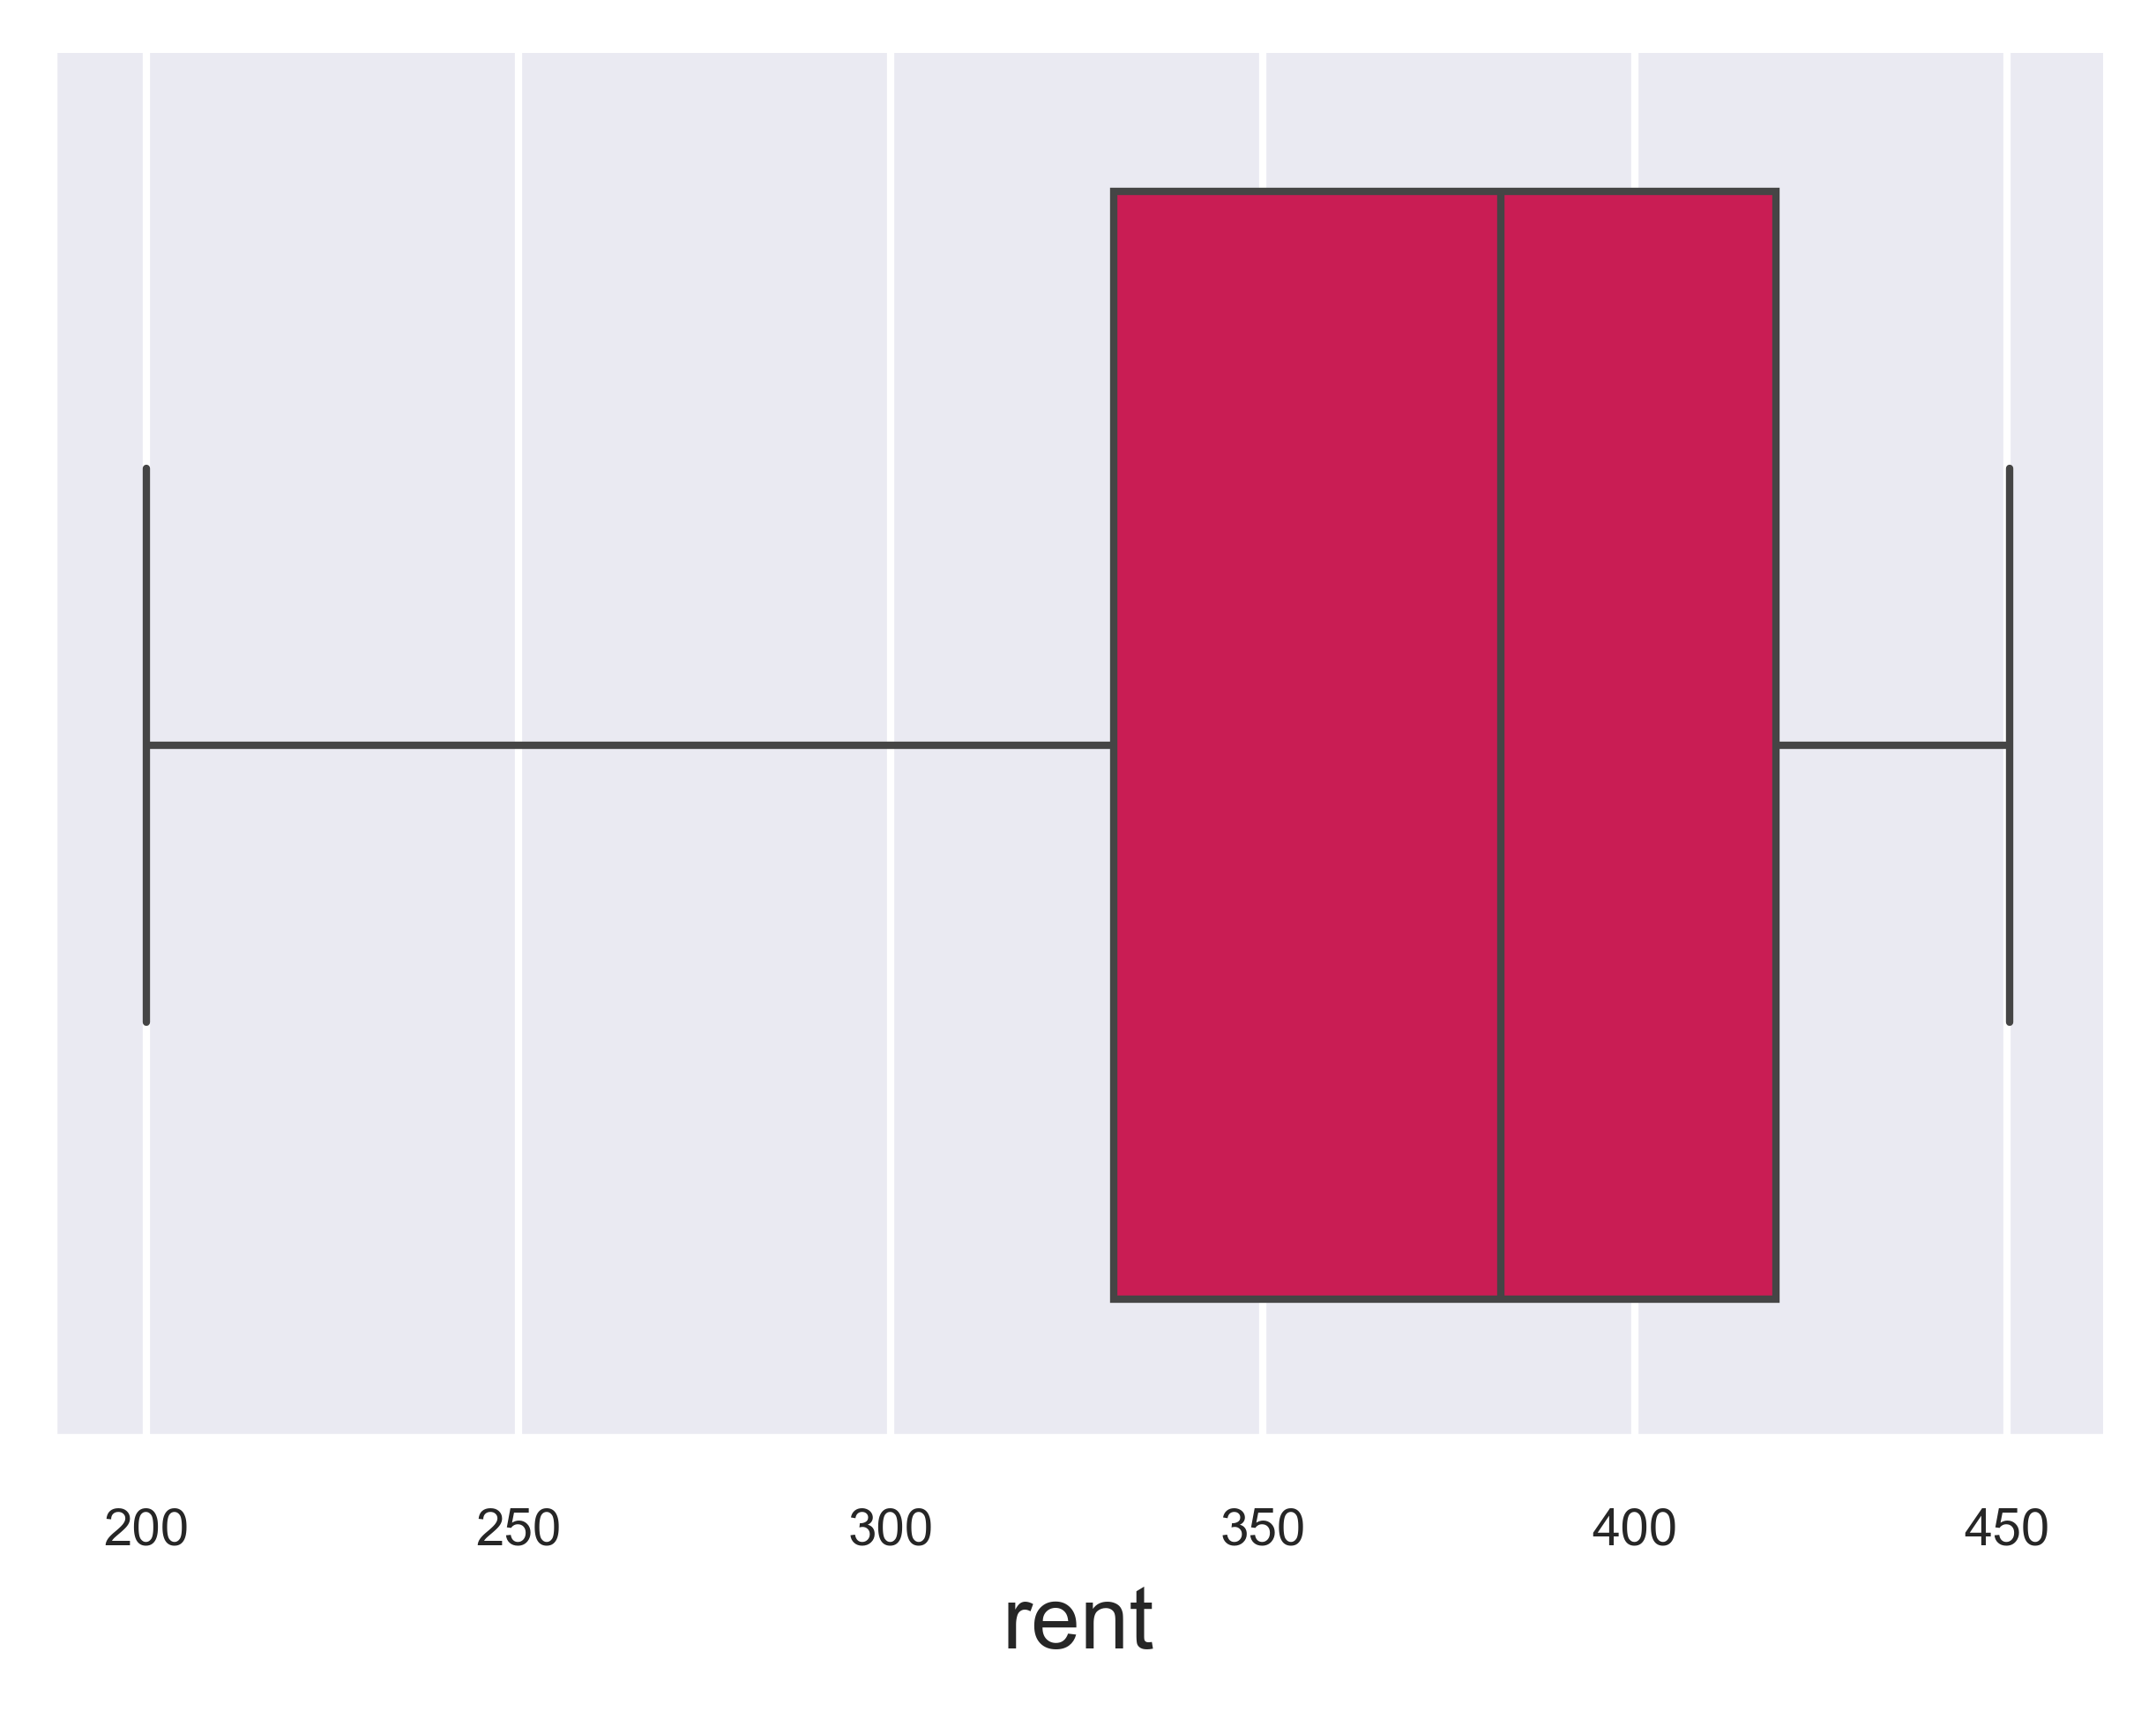

In [95]:
threshold = df['rent'].quantile(0.1)
df_no_outliers = df[df['rent'] <= threshold]
sns.boxplot(x=df_no_outliers['rent']);

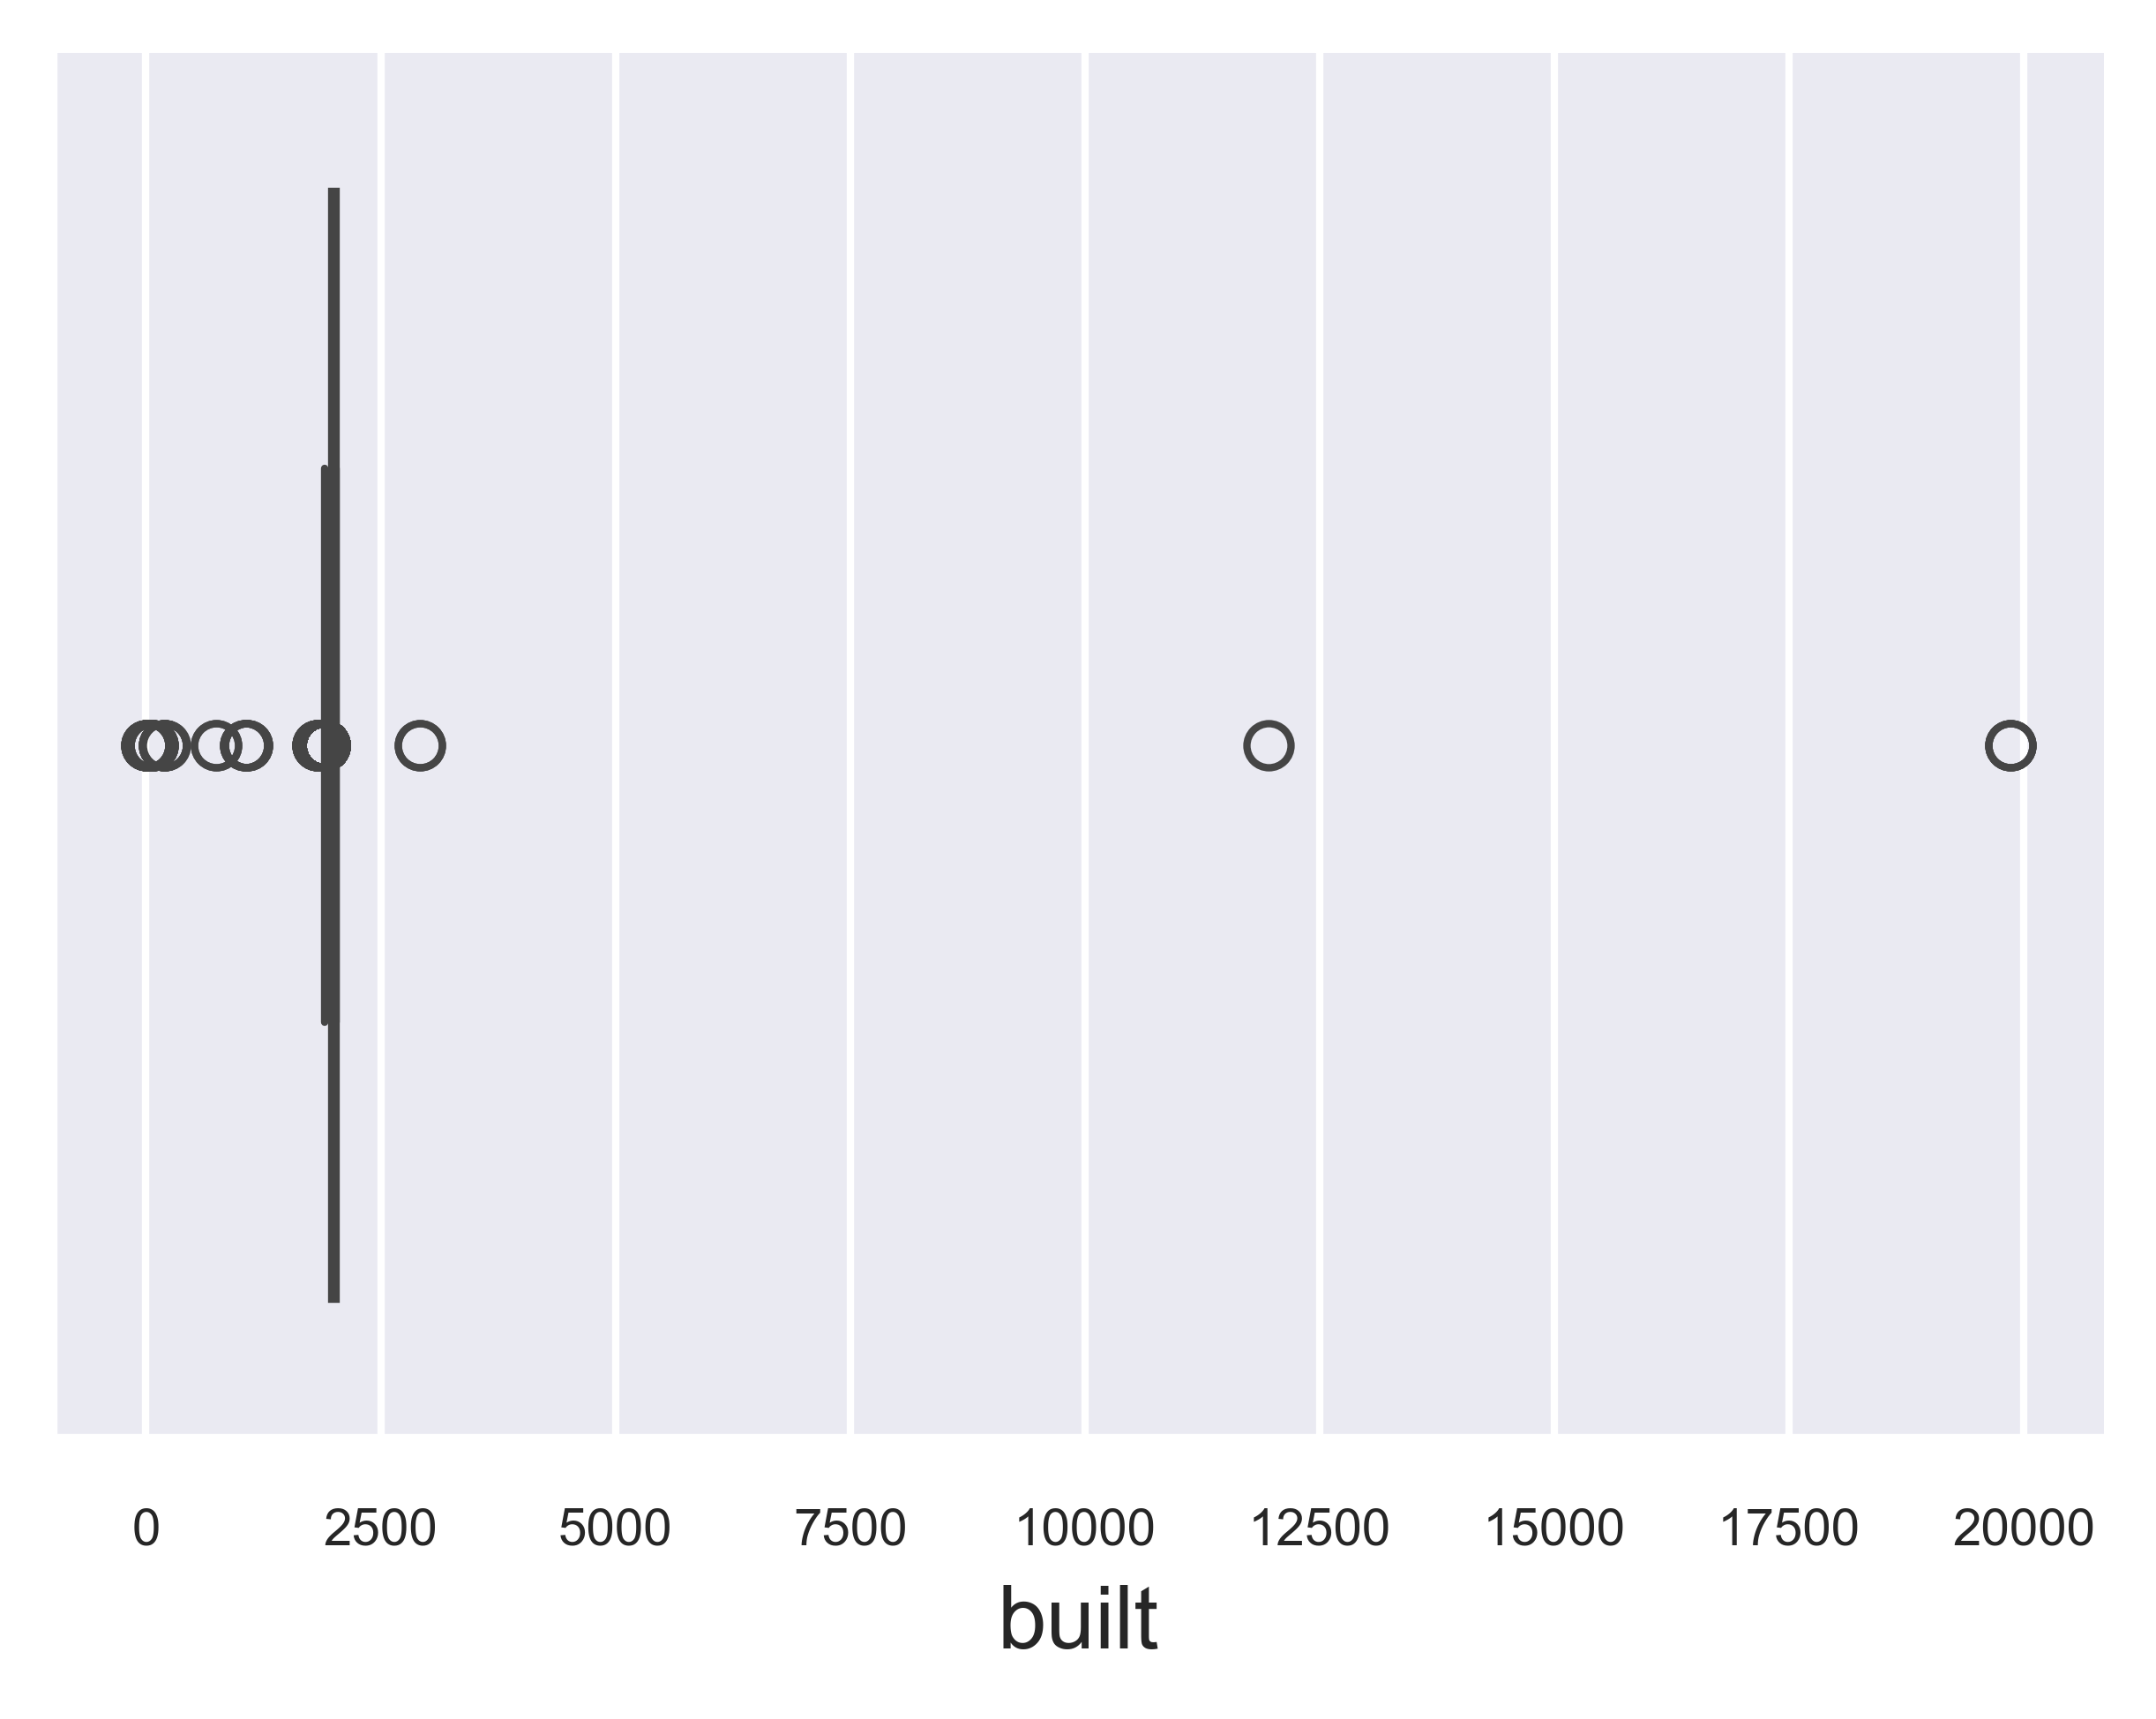

In [98]:
sns.boxplot(x=df['built']);

In [106]:
condition = ((df['built']>2027) | (df['built']<1850))
c = condition & (df['b_type']=='kamienica')

df.loc[c, 'built'] = 1950

c = condition & (df['b_type']=='blok')
df.loc[c, 'built'] = 2000

c = condition & (df['b_type']=='apartamentowiec')
df.loc[c, 'built'] = 2010

,total_price,price_per_sqm,area,rooms,floor,rent,elevator,built,b_type,link,max_floor,balcony,terrace,garden,street,district,subdistrict,distance
7535,1299000.0,16654.0,78.0,3,2.0,1100.0,1.0,2019.0,apartamentowiec,https://www.otodom.pl/pl/oferta/3-pok-78mkw-ta...,2019.0,1.0,0.0,0.0,NaN,Ursynów,Wyczółki,9342.043
15726,1299000.0,16654.0,78.0,3,2.0,1100.0,1.0,2019.0,apartamentowiec,https://www.otodom.pl/pl/oferta/3-pok-78mkw-ta...,2019.0,1.0,0.0,0.0,NaN,Ursynów,Wyczółki,8697.685
19492,1299000.0,16654.0,78.0,3,2.0,1100.0,1.0,2019.0,apartamentowiec,https://www.otodom.pl/pl/oferta/3-pok-78mkw-ta...,2019.0,1.0,0.0,0.0,NaN,Ursynów,Wyczółki,9266.708
21852,1299000.0,16654.0,78.0,3,2.0,1100.0,1.0,2019.0,apartamentowiec,https://www.otodom.pl/pl/oferta/3-pok-78mkw-ta...,2019.0,1.0,0.0,0.0,NaN,Ursynów,Wyczółki,7812.260


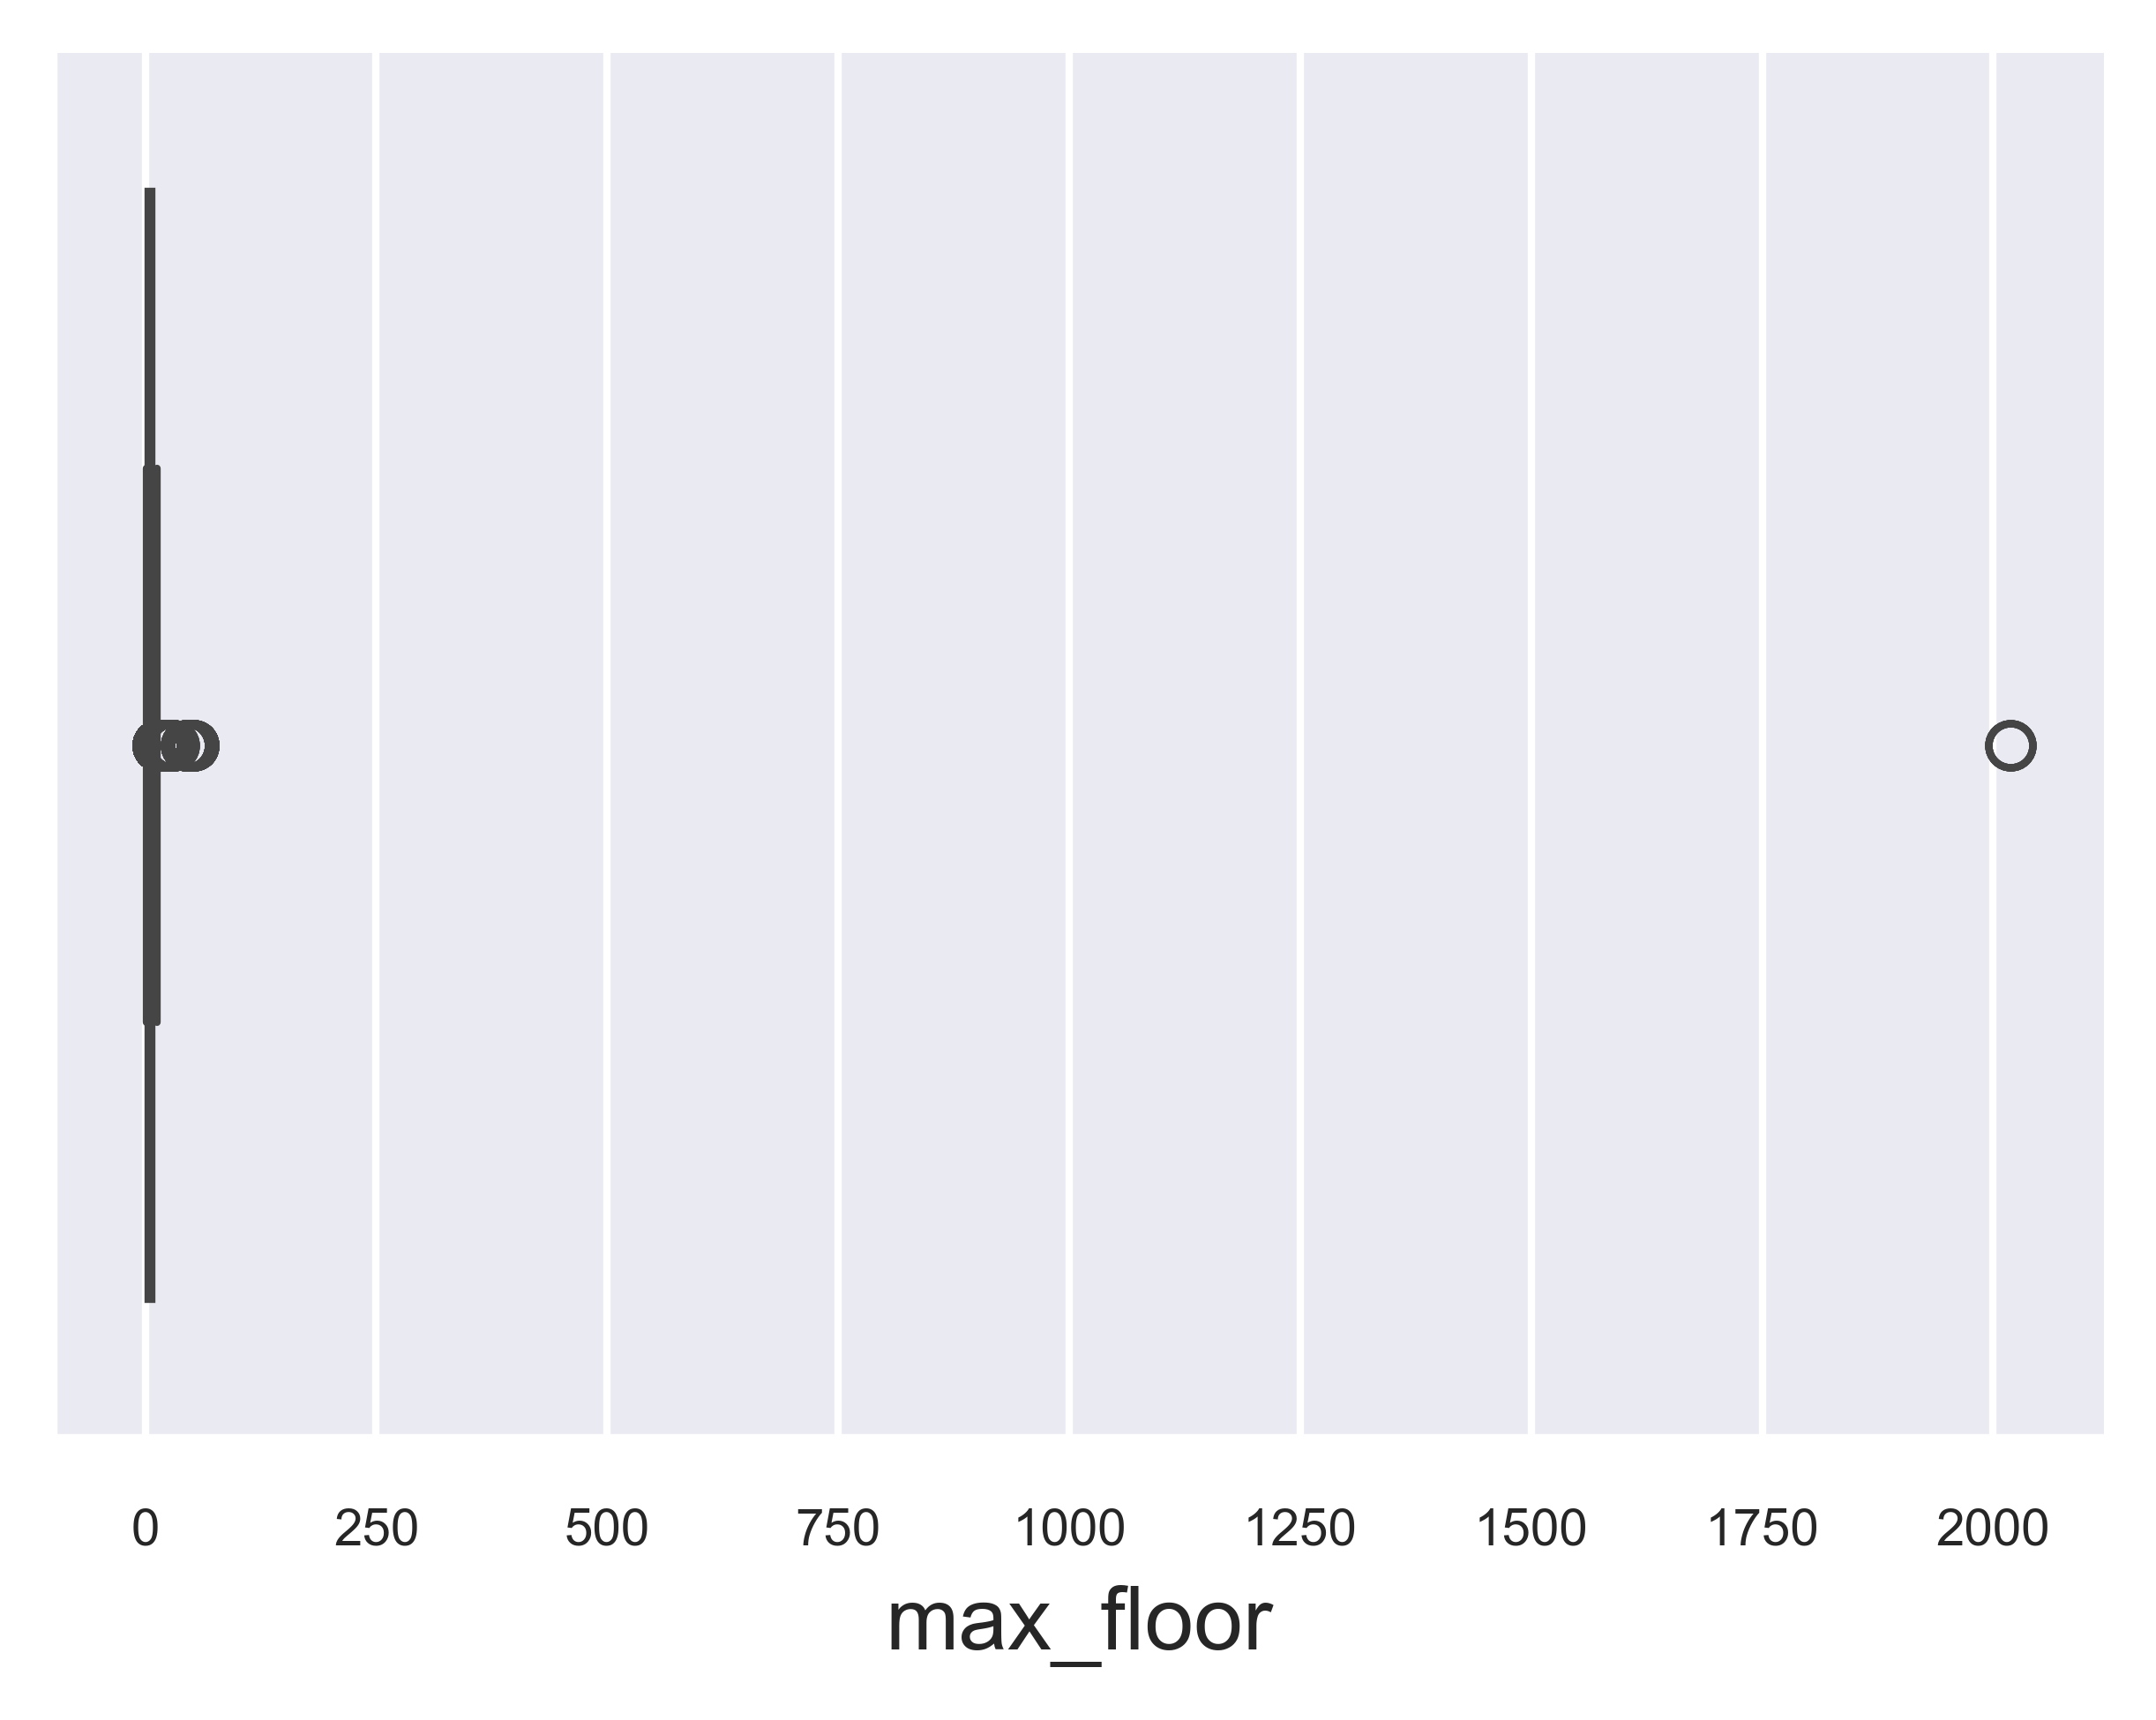

In [112]:
sns.boxplot(x=df['max_floor']);

In [114]:
condition = df['max_floor']>90
df.loc[condition, 'max_floor'] = 10

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28548 entries, 0 to 28551
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_price    28548 non-null  float64
 1   price_per_sqm  28548 non-null  float64
 2   area           28548 non-null  float64
 3   rooms          28548 non-null  int64  
 4   floor          28548 non-null  float64
 5   rent           28548 non-null  float64
 6   elevator       28548 non-null  float64
 7   built          28548 non-null  float64
 8   b_type         28548 non-null  object 
 9   link           28548 non-null  object 
 10  max_floor      28548 non-null  float64
 11  balcony        28548 non-null  float64
 12  terrace        28548 non-null  float64
 13  garden         28548 non-null  float64
 14  street         21464 non-null  object 
 15  district       28548 non-null  object 
 16  subdistrict    28548 non-null  object 
 17  distance       28548 non-null  float64
dtypes: float64(

In [116]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [118]:
df = df[['total_price',
        'price_per_sqm', 
        'area', 
        'rooms', 
        'floor', 
        'rent', 
        'elevator', 
        'built', 
        'b_type', 
        'max_floor', 
        'balcony', 
        'garden', 
        'terrace', 
        'district', 
        'distance']]

In [119]:
df.to_csv('clean_df.csv', index=False)